In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import math

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period_2000_2021/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
#     stats_data.columns = [
#         'return_mean1', 'return_mean2',
#         'return_sd1', 'return_sd2',
#         'return_skew1', 'return_skew2',
#         'return_kurtosis1', 'return_kurtosis2',
        
#         'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
#         'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
#         'return_correlation_ts1_lag_0',
#         'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
#         'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
#         'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
#         'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
#         'sqreturn_correlation_ts1_lag_0',
#         'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
#         'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data



def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[4], mu12=params[5], 
        mu21=params[6], mu22=params[7], 
        sigma11=params[8], sigma12=params[9], 
        sigma21=params[10], sigma22=params[11],
        j11=params[12], j12=params[13], 
        j21=params[14], j22=params[15],
        
        alpha=2*params[0]*params[1]+0.5, 
        beta1=params[0], beta2=params[1], 
        delta0=params[2], 
        mu1=0, mu2=0, 
        lambda11=params[3], lambda12=0, 
        lambda21=0, lambda22=1/params[3],

        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)

    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss


real_price = pd.read_csv(real_data_folder + "pair_prices_cal.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_cal.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 2, real_price.shape[0]
n_real_stats = real_stats




initial0 = [1, 1, 
            1, 
            1,
            
            1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='powell',
               tol=1e-6, 
               options={'disp': True},
               bounds=[                       
                   (0, None), (0, None), 
                   (0, None), 
                   (0, None),
                   
                   (0, None), (0, None), (0, None), (0, None),
                   (None, None), (None, None), (None, None), (None, None),
                   (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)


 [1]  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1
[16]  0.1

0      98.129723
1      93.534993
2     400.756840
3     391.775100
4     167.675358
5     177.687202
6     162.408885
7     178.095320
8      16.545422
9      14.336564
10     14.499319
11     16.350081
12     14.788469
13     14.783358
14    166.466628
15     14.334188
16     14.418730
17     15.002752
18     15.638136
19     12.225569
20     14.616981
21     28.315056
22     24.627958
23     22.700965
24     30.521555
25     26.389428
26     22.843071
27    166.466628
28     14.334188
29     14.418730
30     15.002752
31     15.638136
32     12.225569
33     14.616981
dtype: float64
2422.170633115911
----------
 [1]  1.115092  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
 [8]  1.000000 -1.000000 -1.000000 -1.000000 -1.000000  0.100000  0.100000
[15]  0.100000  0.100000

0     100.761791
1      95.031270
2     392.258646
3     384.421587
4     166.700614
5     178.790414
6     156

0     100.359592
1      94.868665
2     388.830746
3     380.834515
4     143.756048
5     157.430102
6     155.622200
7     173.191753
8      16.797290
9      14.367972
10     13.739039
11     16.375594
12     14.959413
13     14.764751
14    166.459915
15     13.987876
16     14.102723
17     14.328142
18     16.057764
19     12.880468
20     14.279947
21     26.109909
22     24.740078
23     22.107714
24     28.327330
25     27.224409
26     21.382184
27    166.459915
28     13.987876
29     14.102723
30     14.328142
31     16.057764
32     12.880468
33     14.279947
dtype: float64
2339.982976653043
----------
 [1]  3.517022  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
 [8]  1.000000 -1.000000 -1.000000 -1.000000 -1.000000  0.100000  0.100000
[15]  0.100000  0.100000

0      97.872712
1      92.450361
2     386.399790
3     378.518149
4     143.464142
5     154.314518
6     156.155585
7     173.758329
8      16.005241
9      15.197691
10     14.336640
11     16.29244

0      99.619857
1      93.903925
2     384.645804
3     376.996347
4     146.491732
5     153.087755
6     155.762310
7     173.445046
8      16.341905
9      14.432256
10     14.676729
11     16.771330
12     16.239978
13     15.731227
14    166.458992
15     14.915335
16     14.268735
17     14.585843
18     15.109175
19     13.531345
20     14.696636
21     27.001997
22     25.522650
23     22.531231
24     29.403846
25     27.486061
26     21.960229
27    166.458992
28     14.915335
29     14.268735
30     14.585843
31     15.109175
32     13.531345
33     14.696636
dtype: float64
2339.1843391502
----------
 [1]  3.517061  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
 [8]  1.000000 -1.000000 -1.000000 -1.000000 -1.000000  0.100000  0.100000
[15]  0.100000  0.100000

0     100.068468
1      94.513580
2     390.611335
3     381.402873
4     146.061144
5     153.407048
6     156.045663
7     173.656964
8      17.252843
9      14.727441
10     13.376397
11     16.943761


0     102.767479
1      97.959619
2     384.476540
3     375.821755
4     144.067585
5     155.786646
6     156.202850
7     173.879613
8      16.927320
9      14.818820
10     15.008515
11     16.087646
12     15.108611
13     14.223181
14    166.459136
15     14.278712
16     14.057499
17     14.518720
18     14.701022
19     12.999149
20     14.666491
21     28.200506
22     24.901811
23     21.223571
24     29.947765
25     26.454674
26     21.915847
27    166.459136
28     14.278712
29     14.057499
30     14.518720
31     14.701022
32     12.999149
33     14.666491
dtype: float64
2339.1418107641452
----------
 [1]  3.517028  2.408655  1.000000  1.000000  1.000000  1.000000  1.000000
 [8]  1.000000 -1.000000 -1.000000 -1.000000 -1.000000  0.100000  0.100000
[15]  0.100000  0.100000

0     103.269373
1      98.311886
2     383.043439
3     372.984253
4     145.093382
5     154.572979
6     156.052137
7     173.648204
8      15.207069
9      14.820344
10     14.349494
11     16.6045

0     101.674840
1      95.911015
2     382.088180
3     374.555146
4     142.025427
5     156.173682
6     156.750808
7     174.390651
8      16.854659
9      14.815011
10     13.783751
11     15.981532
12     15.103068
13     14.871510
14    166.459338
15     14.962510
16     14.063426
17     14.595372
18     15.848428
19     13.431688
20     13.950449
21     27.050647
22     26.290926
23     21.853600
24     28.982267
25     27.632391
26     21.200978
27    166.459338
28     14.962510
29     14.063426
30     14.595372
31     15.848428
32     13.431688
33     13.950449
dtype: float64
2334.612511212728
----------
 [1]  3.517028  2.606714  1.000000  1.000000  1.000000  1.000000  1.000000
 [8]  1.000000 -1.000000 -1.000000 -1.000000 -1.000000  0.100000  0.100000
[15]  0.100000  0.100000

0      99.959530
1      94.787209
2     383.951452
3     375.241203
4     145.085333
5     153.568620
6     156.232127
7     173.842007
8      17.306185
9      16.308122
10     14.111375
11     16.66920

0     102.373378
1      96.710670
2     384.981159
3     376.536063
4     141.080565
5     152.716173
6     156.039710
7     173.724124
8      16.442426
9      14.452166
10     14.360004
11     16.378798
12     15.748562
13     15.301376
14    166.460110
15     14.482762
16     14.838849
17     14.798098
18     15.602699
19     13.537435
20     13.124747
21     26.783326
22     25.443710
23     21.853977
24     28.717753
25     26.775949
26     21.598406
27    166.460110
28     14.482762
29     14.838849
30     14.798098
31     15.602699
32     13.537435
33     13.124747
dtype: float64
2333.7076926706104
----------
 [1]  3.517028  2.608501  1.000000  1.000000  1.000000  1.000000  1.000000
 [8]  1.000000 -1.000000 -1.000000 -1.000000 -1.000000  0.100000  0.100000
[15]  0.100000  0.100000

0     101.735349
1      96.513532
2     386.731661
3     378.082669
4     143.641210
5     153.084172
6     156.402884
7     174.000900
8      16.323708
9      15.345442
10     16.024435
11     16.9583

0     102.792844
1      97.107478
2     384.231681
3     374.560769
4     144.748399
5     153.490831
6     156.899729
7     174.441434
8      16.552048
9      15.270812
10     14.017752
11     17.744920
12     15.320430
13     13.543064
14    166.458942
15     15.796533
16     14.861699
17     13.892831
18     15.885606
19     13.958088
20     13.785611
21     27.893162
22     25.986434
23     22.468361
24     30.173469
25     27.893149
26     21.243638
27    166.458942
28     15.796533
29     14.861699
30     13.892831
31     15.885606
32     13.958088
33     13.785611
dtype: float64
2345.659026582954
----------
 [1]  3.5170282  2.6084953  0.7914687  1.0000000  1.0000000  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0     100.445499
1      95.447084
2     385.433608
3     376.629977
4     148.609069
5     153.698452
6     156.758941
7     174.299846
8      16.591465
9      14.930462
10     14.822354

0     102.943627
1      97.278565
2     384.227530
3     375.398188
4     143.305766
5     151.663179
6     156.198992
7     173.866039
8      16.775318
9      14.442903
10     14.557997
11     17.140403
12     14.756218
13     14.860650
14    166.458640
15     14.012719
16     14.568602
17     14.699145
18     16.347860
19     12.840071
20     13.726721
21     27.073291
22     24.798513
23     22.307453
24     29.746966
25     26.601796
26     21.988863
27    166.458640
28     14.012719
29     14.568602
30     14.699145
31     16.347860
32     12.840071
33     13.726721
dtype: float64
2335.2397729433683
----------
 [1]  3.5170282  2.6084953  0.7620537  1.0000000  1.0000000  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0     102.399779
1      97.098074
2     384.264661
3     377.085353
4     144.994249
5     153.731539
6     156.142900
7     173.825624
8      17.337165
9      14.863196
10     15.04570

0     100.553707
1      95.069671
2     383.938580
3     377.370894
4     146.595341
5     155.568716
6     155.750191
7     173.375333
8      16.699388
9      14.667824
10     13.492707
11     17.579174
12     15.068078
13     14.080164
14    166.458402
15     15.131483
16     14.122297
17     13.785559
18     15.517786
19     13.502515
20     13.617313
21     26.174806
22     24.741581
23     21.226994
24     29.024908
25     27.455566
26     21.115564
27    166.458402
28     15.131483
29     14.122297
30     13.785559
31     15.517786
32     13.502515
33     13.617313
dtype: float64
2333.819892923428
----------
 [1]  3.5170282  2.6084953  0.7619514  1.0000000  1.0000000  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0     100.937006
1      95.319196
2     382.162657
3     374.655681
4     142.598146
5     151.192200
6     156.814478
7     174.465065
8      15.902385
9      14.706770
10     14.967819

0     101.629734
1      96.473511
2     382.161915
3     375.277130
4     144.261320
5     155.762015
6     156.396256
7     174.057964
8      18.316261
9      15.177079
10     14.693430
11     16.654850
12     15.619500
13     15.183533
14    166.460202
15     15.735050
16     14.821254
17     14.902125
18     16.225427
19     13.599766
20     14.565732
21     26.474657
22     24.630209
23     21.367210
24     28.537142
25     26.110175
26     21.714129
27    166.460202
28     15.735050
29     14.821254
30     14.902125
31     16.225427
32     13.599766
33     14.565732
dtype: float64
2343.117129163564
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7672781  1.0000000  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0     102.441577
1      96.409967
2     383.403624
3     373.727893
4     145.671824
5     154.704199
6     156.936906
7     174.605668
8      15.717641
9      16.245414
10     13.931643

0      99.816973
1      94.397706
2     381.987988
3     374.070194
4     147.269833
5     155.889253
6     156.536474
7     174.207888
8      16.404411
9      15.027671
10     14.504673
11     16.907320
12     15.298678
13     14.117156
14    166.459152
15     15.302424
16     14.174198
17     14.182338
18     15.710722
19     13.530859
20     14.652502
21     26.107588
22     26.137093
23     20.418288
24     28.360331
25     28.257541
26     20.426113
27    166.459152
28     15.302424
29     14.174198
30     14.182338
31     15.710722
32     13.530859
33     14.652502
dtype: float64
2334.167561387995
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667304  1.0000000  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      99.613387
1      94.089455
2     384.405132
3     376.391486
4     142.841927
5     152.827279
6     156.419613
7     174.149224
8      16.770698
9      15.174053
10     14.415910

0      36.170082
1      94.392456
2     389.541427
3     375.374302
4     145.268344
5     154.420415
6     156.511917
7     174.192831
8      18.241714
9      16.048405
10     15.094976
11     16.396253
12     15.038578
13     15.030794
14    166.148835
15     14.946612
16     15.425383
17     14.911049
18     16.496300
19     14.047950
20     14.388361
21     26.998377
22     26.410813
23     21.848790
24     29.331650
25     28.003510
26     21.204465
27    166.148835
28     14.946612
29     15.425383
30     14.911049
31     16.496300
32     14.047950
33     14.388361
dtype: float64
2288.2490778317574
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6005771  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      37.287587
1      97.836428
2     387.734142
3     375.175338
4     143.577167
5     155.678911
6     156.108906
7     173.760520
8      18.492920
9      15.853147
10     15.70575

0      36.818886
1      96.583999
2     385.162978
3     372.308695
4     142.948641
5     155.211254
6     156.335963
7     174.013907
8      17.599905
9      14.914762
10     16.197848
11     16.367582
12     14.846395
13     14.920134
14    166.149039
15     14.801539
16     14.363538
17     15.098142
18     15.716746
19     13.105198
20     15.118261
21     26.994425
22     24.049155
23     22.948024
24     29.755372
25     27.370136
26     22.040990
27    166.149039
28     14.801539
29     14.363538
30     15.098142
31     15.716746
32     13.105198
33     15.118261
dtype: float64
2276.0939752789222
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6089430  1.0000000
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      36.906298
1      96.619603
2     387.118788
3     373.365848
4     143.489746
5     154.768706
6     155.054643
7     172.717784
8      18.472678
9      16.843855
10     15.86683

0      74.042662
1      96.956228
2     398.158797
3     374.844072
4     141.221938
5     154.504178
6     156.703718
7     174.405465
8      22.465700
9      20.421223
10     17.649611
11     16.927482
12     15.690095
13     14.666760
14    164.766369
15     15.729407
16     15.480915
17     14.591651
18     17.190210
19     15.166604
20     14.339083
21     25.902385
22     23.705483
23     20.194545
24     29.648604
25     26.685039
26     21.207701
27    164.766369
28     15.729407
29     15.480915
30     14.591651
31     17.190210
32     15.166604
33     14.339083
dtype: float64
2340.5301626754776
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.7667255
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      39.428087
1      97.196607
2     387.080555
3     375.095529
4     146.035658
5     153.373160
6     156.844389
7     174.503853
8      18.059728
9      15.532838
10     15.79302

0      35.397298
1      95.055338
2     389.077059
3     375.744494
4     146.515230
5     152.265758
6     156.369172
7     174.013487
8      17.722472
9      15.359985
10     16.632479
11     15.787723
12     15.035315
13     16.214723
14    166.189706
15     14.745119
16     15.301634
17     15.510976
18     15.440705
19     13.697081
20     15.840908
21     28.523799
22     25.269634
23     22.845733
24     29.818919
25     26.491467
26     21.676931
27    166.189706
28     14.745119
29     15.301634
30     15.510976
31     15.440705
32     13.697081
33     15.840908
dtype: float64
2289.269274457863
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9603667
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      33.937985
1      97.277959
2     387.691966
3     375.357348
4     143.216248
5     154.342006
6     155.897282
7     173.588083
8      18.327715
9      16.801086
10     15.561728

0      35.682867
1      98.143074
2     388.138202
3     376.231403
4     143.566143
5     157.628581
6     155.921548
7     173.675540
8      18.062624
9      16.683252
10     14.764833
11     15.919179
12     15.093542
13     14.348666
14    166.187902
15     14.995748
16     15.427014
17     14.744660
18     16.403306
19     13.261461
20     14.701354
21     26.666773
22     25.513255
23     22.721357
24     29.438525
25     26.628641
26     22.386030
27    166.187902
28     14.995748
29     15.427014
30     14.744660
31     16.403306
32     13.261461
33     14.701354
dtype: float64
2288.656923926678
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600490
 [7]  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      35.687554
1      94.714492
2     388.529523
3     375.899000
4     142.665221
5     154.147752
6     156.887240
7     174.498248
8      18.829955
9      17.001601
10     15.034716

0      35.224957
1      34.610100
2     386.338247
3     378.172065
4     144.406214
5     154.640988
6     156.139345
7     173.791727
8      17.267034
9      17.072626
10     16.747100
11     17.563840
12     17.577948
13     17.344933
14    166.467727
15     14.884633
16     16.923072
17     16.121210
18     15.767790
19     14.926161
20     15.962437
21     26.918408
22     25.417224
23     22.337114
24     28.442936
25     27.158039
26     23.037759
27    166.467727
28     14.884633
29     16.923072
30     16.121210
31     15.767790
32     14.926161
33     15.962437
dtype: float64
2242.314664977308
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.7008224  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      36.300531
1      35.753993
2     387.089107
3     379.559391
4     142.399951
5     154.440087
6     155.681711
7     173.255698
8      18.270954
9      16.999550
10     15.256335

0      35.162701
1      36.812662
2     389.198608
3     379.979840
4     143.019130
5     153.392845
6     156.593231
7     174.273082
8      17.814551
9      16.338481
10     16.039473
11     17.291453
12     17.062767
13     15.214840
14    166.468754
15     15.575253
16     15.496055
17     15.244262
18     17.743522
19     14.563788
20     15.312916
21     26.682267
22     25.400777
23     22.184436
24     29.222292
25     26.760313
26     22.209119
27    166.468754
28     15.575253
29     15.496055
30     15.244262
31     17.743522
32     14.563788
33     15.312916
dtype: float64
2241.4619691689095
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898617  1.0000000 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      35.385229
1      36.561789
2     390.286587
3     383.573468
4     144.518628
5     152.958526
6     156.416887
7     174.123568
8      17.790853
9      16.830980
10     16.43458

0      35.430805
1      41.940939
2     388.391504
3     378.884609
4     145.800564
5     154.713170
6     156.917863
7     174.526004
8      17.627026
9      15.798850
10     15.723857
11     16.422671
12     16.184942
13     14.773151
14    166.476931
15     14.745790
16     15.251320
17     15.340023
18     15.849366
19     14.085893
20     14.969421
21     27.564034
22     25.310047
23     20.725945
24     29.178058
25     25.922930
26     21.529686
27    166.476931
28     14.745790
29     15.251320
30     15.340023
31     15.849366
32     14.085893
33     14.969421
dtype: float64
2236.8041393301637
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.4965302 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      37.765905
1      86.197682
2     389.398666
3     377.047917
4     146.534078
5     154.407162
6     156.256990
7     173.967069
8      17.527869
9      16.571564
10     14.97746

0      37.095909
1      43.182887
2     387.748646
3     378.842138
4     146.290164
5     152.434898
6     155.644603
7     173.300629
8      19.436150
9      18.420923
10     14.932769
11     18.024905
12     17.045181
13     14.163222
14    166.478452
15     15.509955
16     17.296896
17     15.134637
18     17.072263
19     15.323364
20     14.265808
21     25.298923
22     24.872334
23     23.375766
24     28.110129
25     27.455046
26     22.738620
27    166.478452
28     15.509955
29     17.296896
30     15.134637
31     17.072263
32     15.323364
33     14.265808
dtype: float64
2250.576588788688
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7853303 -1.0000000 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      36.472641
1      39.359824
2     388.530838
3     378.879431
4     144.197381
5     155.696832
6     156.658941
7     174.316448
8      18.928551
9      15.749515
10     16.223257

0      35.105188
1      42.399680
2     219.365646
3     378.152458
4     143.068146
5     156.481307
6     156.630729
7     174.489063
8      21.954224
9      19.598815
10     19.040938
11     17.800476
12     15.579585
13     15.677462
14    125.853953
15     16.323622
16     15.736070
17     16.704236
18     18.182249
19     14.478876
20     15.922344
21     26.771365
22     25.131746
23     22.061305
24     28.961656
25     27.365833
26     22.575091
27    125.853953
28     16.323622
29     15.736070
30     16.704236
31     18.182249
32     14.478876
33     15.922344
dtype: float64
2014.6134128196184
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -2.1037279 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      33.715005
1      40.090346
2     235.034486
3     380.356340
4     143.627848
5     156.514779
6     155.589502
7     173.667933
8      22.099153
9      19.680175
10     18.14404

0      35.879677
1      41.467954
2     214.083502
3     379.472172
4     142.035206
5     153.491035
6     156.354876
7     174.144978
8      22.391647
9      21.935806
10     18.255548
11     17.967954
12     16.824263
13     16.173858
14     97.743558
15     17.565170
16     17.580131
17     16.328526
18     18.605449
19     16.349141
20     15.072295
21     27.400347
22     25.043985
23     21.967055
24     29.058728
25     26.493779
26     22.346010
27     97.743558
28     17.565170
29     17.580131
30     16.328526
31     18.605449
32     16.349141
33     15.072295
dtype: float64
1961.276919554172
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      35.081744
1      42.598665
2     212.868196
3     374.965046
4     142.358951
5     154.571863
6     156.346062
7     173.851378
8      22.056996
9      20.004248
10     18.091950

0      34.586304
1      42.782362
2     214.649938
3     378.624167
4     147.150566
5     154.831903
6     156.825316
7     174.573775
8      22.506969
9      19.722998
10     18.681452
11     17.676609
12     15.457125
13     15.025399
14     98.242634
15     16.711108
16     16.381032
17     16.399604
18     17.925004
19     15.604201
20     15.737314
21     26.002369
22     24.257477
23     21.635359
24     28.478404
25     27.567784
26     20.566299
27     98.242634
28     16.711108
29     16.381032
30     16.399604
31     17.925004
32     15.604201
33     15.737314
dtype: float64
1955.6043675416986
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.0000000 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      34.449138
1      40.783590
2     212.766911
3     377.948597
4     142.240148
5     156.489421
6     155.895851
7     173.263604
8      21.956613
9      19.639269
10     18.65756

0      33.266547
1      43.619548
2     172.811759
3     378.346585
4     141.675212
5     155.393568
6     156.985865
7     174.486197
8      29.673473
9      25.220546
10     23.758237
11     18.465456
12     16.502629
13     15.512568
14     98.116491
15     18.597087
16     17.560169
17     17.111918
18     19.555876
19     15.649631
20     16.797542
21     25.817377
22     25.473834
23     20.782576
24     30.471194
25     27.306581
26     21.938382
27     98.116491
28     18.597087
29     17.560169
30     17.111918
31     19.555876
32     15.649631
33     16.797542
dtype: float64
1944.2855596565844
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.2049591 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      34.697359
1      41.632669
2     172.941160
3     383.194494
4     144.450620
5     152.513427
6     156.816831
7     174.211879
8      27.301178
9      25.660027
10     23.14198

0      33.685398
1      39.990660
2     175.917187
3     377.185082
4     140.621826
5     154.096986
6     156.061955
7     174.926694
8      28.208107
9      24.746758
10     22.346738
11     18.209404
12     16.104101
13     15.417882
14     98.148112
15     18.371479
16     17.890305
17     17.076048
18     20.018772
19     16.002772
20     15.972710
21     26.161704
22     25.747261
23     21.857180
24     30.647125
25     26.587108
26     20.828284
27     98.148112
28     18.371479
29     17.890305
30     17.076048
31     20.018772
32     16.002772
33     15.972710
dtype: float64
1936.307834364109
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1996754 -1.0000000 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      33.692152
1      43.554120
2     176.195778
3     382.658672
4     144.103087
5     153.800607
6     156.566008
7     174.334710
8      26.381375
9      25.417894
10     22.715243

0      34.703728
1      40.405180
2     174.781871
3     248.470846
4     143.482022
5     153.609829
6     156.395878
7     174.033797
8      27.870477
9      25.516726
10     23.118104
11     19.508466
12     19.108498
13     17.670487
14    148.852100
15     19.945475
16     20.127588
17     19.392197
18     21.750149
19     18.441994
20     18.029711
21     26.427119
22     25.236713
23     21.911102
24     30.302819
25     26.879533
26     22.287296
27    148.852100
28     19.945475
29     20.127588
30     19.392197
31     21.750149
32     18.441994
33     18.029711
dtype: float64
1944.7989188977815
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7057235 -1.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      34.013637
1      41.451643
2     174.867573
3     258.217590
4     142.440862
5     155.177111
6     156.346492
7     174.290763
8      27.814473
9      25.693779
10     23.21056

0      34.165054
1      41.877156
2     176.203451
3     255.151281
4     144.032365
5     155.697143
6     156.400948
7     174.514193
8      27.220290
9      23.915104
10     23.652600
11     19.608645
12     18.179524
13     17.823583
14    145.944349
15     19.346235
16     19.420692
17     20.117412
18     21.099533
19     17.955412
20     19.169777
21     25.723451
22     24.874095
23     21.852858
24     28.761604
25     26.195682
26     21.560211
27    145.944349
28     19.346235
29     19.420692
30     20.117412
31     21.099533
32     17.955412
33     19.169777
dtype: float64
1943.5160571986314
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281  0.0000000
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0       33.728958
1       52.697166
2      175.915604
3     1098.244883
4      145.631896
5      155.814194
6      156.237989
7      173.842446
8       27.552180
9       25.242968
10   

0      33.976742
1      41.068966
2     176.611082
3     188.563127
4     142.515223
5     156.047294
6     156.431884
7     174.212156
8      27.361605
9      24.521396
10     22.611334
11     25.070492
12     24.633831
13     22.361072
14    126.989648
15     23.582965
16     23.134610
17     21.881765
18     24.512055
19     22.252370
20     20.765675
21     26.257323
22     26.098551
23     20.982974
24     29.617063
25     27.331832
26     21.092525
27    126.989648
28     23.582965
29     23.134610
30     21.881765
31     24.512055
32     22.252370
33     20.765675
dtype: float64
1893.6046458255942
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5118558
[13]  0.1000000  0.1000000  0.1000000  0.1000000

0      34.427329
1      39.065285
2     173.317007
3     184.930502
4     142.407341
5     153.960291
6     156.140642
7     173.512217
8      26.760596
9      25.561180
10     22.25713

0      34.506945
1      40.174450
2     175.030479
3     184.448599
4     144.416611
5     153.706465
6     156.440725
7     174.059244
8      29.083560
9      25.308744
10     21.966470
11     26.708235
12     25.782619
13     21.874084
14    121.874969
15     25.295492
16     23.889172
17     21.087778
18     25.677332
19     22.545346
20     20.557053
21     26.486132
22     24.825198
23     21.799485
24     28.681101
25     27.751789
26     22.378135
27    121.874969
28     25.295492
29     23.889172
30     21.087778
31     25.677332
32     22.545346
33     20.557053
dtype: float64
1887.2833532748327
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13]  1.1000000  0.1000000  0.1000000  0.1000000

0      34.107092
1      39.520932
2     206.693940
3     183.840228
4     213.216082
5     155.264845
6     153.032476
7     174.143917
8      22.855536
9      21.040491
10     19.20442

0      36.459615
1      39.477562
2     218.075749
3     183.931450
4     204.962033
5     154.011684
6     149.851428
7     174.138853
8      22.342990
9      21.433885
10     18.982003
11     26.919287
12     27.593683
13     23.276497
14     79.584495
15     21.923587
16     22.494201
17     21.020965
18     22.694461
19     20.634725
20     19.035846
21     25.802294
22     24.551249
23     21.928202
24     29.289628
25     25.855503
26     22.314452
27     79.584495
28     21.923587
29     22.494201
30     21.020965
31     22.694461
32     20.634725
33     19.035846
dtype: float64
1865.97460525342
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1592161  0.1000000  0.1000000  0.1000000

0      35.129066
1      39.646566
2     216.643776
3     183.948710
4     225.591568
5     152.934361
6     172.414348
7     174.088072
8      23.869269
9      20.961238
10     19.348057


0      34.976043
1      40.529395
2     217.646523
3     184.474648
4     202.775829
5     154.655801
6     148.700417
7     174.557105
8      23.998040
9      21.265111
10     17.805554
11     26.637655
12     25.573663
13     23.840881
14     80.404060
15     22.195194
16     21.718767
17     20.976120
18     23.574712
19     20.495482
20     19.626723
21     27.126763
22     24.700473
23     21.270092
24     28.488796
25     26.227214
26     21.547687
27     80.404060
28     22.195194
29     21.718767
30     20.976120
31     23.574712
32     20.495482
33     19.626723
dtype: float64
1864.7798054390273
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.1000000  0.1000000  0.1000000

0      36.240515
1      40.107475
2     215.989046
3     184.091672
4     206.726424
5     152.201616
6     145.658315
7     174.320220
8      23.017115
9      20.556802
10     19.48365

0      36.089832
1      39.667010
2     234.217266
3     184.505068
4     215.765641
5     152.166401
6     172.000760
7     174.412846
8      21.948564
9      19.342927
10     18.235349
11     27.203642
12     26.041409
13     23.758138
14     77.778808
15     22.010613
16     20.494223
17     19.234732
18     22.469102
19     19.317862
20     19.448936
21     25.897585
22     24.812273
23     21.255952
24     28.813121
25     26.396205
26     20.679584
27     77.778808
28     22.010613
29     20.494223
30     19.234732
31     22.469102
32     19.317862
33     19.448936
dtype: float64
1894.7181221169396
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4606798  0.1000000  0.1000000

0      34.037014
1      39.260543
2     225.816445
3     184.681512
4     207.126032
5     155.109371
6     159.844685
7     174.493920
8      22.025469
9      18.901790
10     19.12717

0      36.117332
1      39.447135
2     230.249363
3     185.391930
4     220.973135
5     155.152090
6     172.147554
7     173.275900
8      22.905402
9      20.348704
10     17.480730
11     26.421248
12     26.131118
13     22.741388
14     79.329127
15     21.222853
16     21.042006
17     19.615921
18     22.849874
19     20.896967
20     18.588546
21     27.029744
22     23.941996
23     22.331837
24     29.329056
25     26.407400
26     21.347989
27     79.329127
28     21.222853
29     21.042006
30     19.615921
31     22.849874
32     20.896967
33     18.588546
dtype: float64
1906.2616332248233
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4820730  0.1000000  0.1000000

0      35.919545
1      40.203791
2     231.384265
3     183.958029
4     207.493602
5     154.564176
6     164.417715
7     173.181463
8      22.446790
9      20.657560
10     18.21807

0      35.014467
1      40.655925
2     224.210424
3     188.216183
4     229.201979
5     162.906607
6     161.561802
7     166.293882
8      23.310667
9      21.963584
10     18.826865
11     24.364329
12     25.362971
13     22.653662
14     46.732175
15     21.196897
16     22.240639
17     20.394411
18     21.685668
19     20.150195
20     18.641757
21     26.438347
22     25.021630
23     21.307719
24     29.740206
25     27.681796
26     20.922925
27     46.732175
28     21.196897
29     22.240639
30     20.394411
31     21.685668
32     20.150195
33     18.641757
dtype: float64
1837.7394545423044
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.3360680  0.1000000

0      35.153828
1      41.531861
2     231.434105
3     186.154852
4     215.023578
5     152.638416
6     152.698379
7     172.280922
8      21.514008
9      18.682501
10     17.33145

0      35.285837
1      40.439729
2     225.192385
3     187.103313
4     195.266376
5     156.606195
6     146.083430
7     166.760116
8      22.066847
9      20.296648
10     19.053398
11     25.117781
12     24.084433
13     22.018484
14     54.495863
15     20.587745
16     20.472947
17     19.657528
18     22.369493
19     19.835367
20     18.707919
21     26.098849
22     23.913929
23     21.236697
24     28.384969
25     26.538987
26     21.137029
27     54.495863
28     20.587745
29     20.472947
30     19.657528
31     22.369493
32     19.835367
33     18.707919
dtype: float64
1784.9391576526414
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4614129  0.1000000

0      35.259793
1      39.350990
2     230.273216
3     187.970783
4     215.777727
5     164.930225
6     167.646712
7     166.827732
8      21.692367
9      20.657104
10     18.06464

0      35.593340
1      37.223893
2     228.574968
3     217.196936
4     208.579707
5     221.583233
6     156.227307
7     160.651021
8      22.467266
9      18.841304
10     17.340739
11     22.142786
12     21.013126
13     19.081658
14     38.992491
15     19.281400
16     20.065799
17     18.684801
18     20.683542
19     17.214974
20     17.345794
21     27.309186
22     24.559145
23     22.016432
24     29.510746
25     25.364763
26     21.402367
27     38.992491
28     19.281400
29     20.065799
30     18.684801
31     20.683542
32     17.214974
33     17.345794
dtype: float64
1841.2175243852748
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.2498490

0      35.800681
1      39.345957
2     228.262156
3     188.184442
4     222.374607
5     157.631388
6     169.371278
7     165.927481
8      22.740988
9      19.989094
10     17.41706

0      35.637426
1      36.943429
2     228.277508
3     204.393924
4     194.521708
5     202.677518
6     152.011858
7     163.444572
8      22.662879
9      19.212697
10     18.416197
11     22.633191
12     21.576313
13     19.820575
14     39.478997
15     18.902723
16     19.844730
17     18.106843
18     20.675117
19     18.574799
20     17.459009
21     25.700903
22     24.248159
23     21.726094
24     29.183655
25     26.803443
26     21.251369
27     39.478997
28     18.902723
29     19.844730
30     18.106843
31     20.675117
32     18.574799
33     17.459009
dtype: float64
1797.2278542558852
----------
 [1]  3.5170282  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7478907

0      35.349232
1      37.132457
2     229.658868
3     205.491879
4     213.419958
5     196.366010
6     163.186084
7     153.149865
8      21.668169
9      19.496586
10     18.90427

0      34.829851
1      38.946115
2     211.752646
3     198.684355
4     189.682175
5     176.149420
6     150.328081
7     150.893433
8      24.060011
9      21.439883
10     18.194596
11     22.989920
12     22.604163
13     21.596060
14     38.503134
15     20.527865
16     21.302444
17     19.110608
18     22.599711
19     19.576126
20     17.536766
21     26.976331
22     24.429831
23     21.600453
24     28.393354
25     25.380200
26     21.560282
27     38.503134
28     20.527865
29     21.302444
30     19.110608
31     22.599711
32     19.576126
33     17.536766
dtype: float64
1748.8044684792483
----------
 [1]  4.6715579  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.141965
1      37.724201
2     214.771169
3     200.239919
4     189.233870
5     181.716134
6     139.315146
7     153.667346
8      22.144905
9      20.910366
10     18.23333

0      33.729104
1      38.999359
2     216.703648
3     200.558636
4     185.591512
5     165.896747
6     134.839439
7     153.289580
8      22.337979
9      20.620655
10     19.475048
11     23.109084
12     21.950725
13     20.010569
14     35.828572
15     20.676804
16     20.723513
17     20.088042
18     21.422150
19     18.874307
20     18.217794
21     26.889550
22     25.615280
23     21.685711
24     28.812138
25     26.933456
26     20.853111
27     35.828572
28     20.676804
29     20.723513
30     20.088042
31     21.422150
32     18.874307
33     18.217794
dtype: float64
1719.563695245962
----------
 [1]  4.3125897  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.085857
1      38.503687
2     219.817268
3     202.914770
4     203.493253
5     178.495173
6     156.021865
7     152.071527
8      23.052734
9      21.734748
10     18.873482

0      36.252902
1      38.661796
2     214.681788
3     201.703781
4     193.324223
5     180.831306
6     148.631665
7     153.057134
8      23.675896
9      20.040113
10     18.265589
11     22.504015
12     22.480600
13     19.479392
14     37.427351
15     19.945093
16     21.150153
17     19.350479
18     21.971741
19     19.328371
20     18.492741
21     26.459461
22     24.840386
23     21.749984
24     29.326623
25     25.990584
26     21.043293
27     37.427351
28     19.945093
29     21.150153
30     19.350479
31     21.971741
32     19.328371
33     18.492741
dtype: float64
1758.3323867323338
----------
 [1]  4.3144893  2.6084953  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.233324
1      37.795612
2     219.266787
3     204.220689
4     178.355259
5     179.473609
6     132.539238
7     150.663036
8      21.969136
9      19.667606
10     19.28813

0      35.179446
1      38.630299
2     202.879683
3     197.699940
4     168.313008
5     171.822381
6     137.262388
7     157.483138
8      22.543338
9      20.497034
10     19.443317
11     23.898380
12     24.000877
13     20.884436
14     39.253756
15     19.537352
16     21.302621
17     20.034030
18     22.287248
19     20.972034
20     18.803029
21     26.629449
22     25.351798
23     22.061907
24     28.769901
25     25.665814
26     21.642052
27     39.253756
28     19.537352
29     21.302621
30     20.034030
31     22.287248
32     20.972034
33     18.803029
dtype: float64
1715.0387246989453
----------
 [1]  4.3144798  2.8749217  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.034609
1      38.220461
2     210.338798
3     197.386067
4     170.856186
5     179.846118
6     136.777855
7     157.854390
8      22.864376
9      21.601554
10     18.73946

0      34.238569
1      38.744785
2     207.217476
3     198.070380
4     173.548933
5     170.671857
6     132.558815
7     154.109046
8      22.951313
9      20.945668
10     19.829790
11     23.047565
12     23.103102
13     19.791063
14     38.411327
15     20.214992
16     20.007910
17     20.594388
18     22.005094
19     19.725650
20     18.774036
21     27.500730
22     24.650706
23     21.542036
24     29.133661
25     26.502594
26     21.171344
27     38.411327
28     20.214992
29     20.007910
30     20.594388
31     22.005094
32     19.725650
33     18.774036
dtype: float64
1708.796225444321
----------
 [1]  4.3144798  3.0500745  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.519552
1      38.831982
2     207.693820
3     199.339529
4     175.447573
5     169.071830
6     144.379919
7     153.493333
8      23.437592
9      21.083432
10     20.010070

0      35.409598
1      38.019857
2     211.748136
3     199.581189
4     175.744588
5     170.209649
6     138.005293
7     155.446662
8      23.992742
9      20.290879
10     19.902277
11     23.576878
12     22.695862
13     21.272659
14     42.833764
15     20.426783
16     21.517375
17     20.221858
18     21.920437
19     19.141347
20     20.118404
21     26.168510
22     25.115477
23     21.486230
24     29.287137
25     25.604441
26     21.968260
27     42.833764
28     20.426783
29     21.517375
30     20.221858
31     21.920437
32     19.141347
33     20.118404
dtype: float64
1737.8862608034547
----------
 [1]  4.3144798  3.0491414  0.7619519  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      33.890200
1      39.249530
2     209.294601
3     197.855955
4     174.591746
5     170.150692
6     134.889085
7     154.984172
8      24.423528
9      20.785110
10     18.57310

0      35.418507
1      37.938978
2     230.156748
3     210.594242
4     170.805557
5     169.541198
6     126.252550
7     143.391048
8      21.968129
9      18.966941
10     17.741384
11     22.918924
12     21.541000
13     18.969424
14     36.335323
15     19.735871
16     19.707044
17     17.662137
18     20.876319
19     17.941567
20     18.010778
21     27.121164
22     24.985331
23     21.127278
24     28.767168
25     26.145114
26     22.500869
27     36.335323
28     19.735871
29     19.707044
30     17.662137
31     20.876319
32     17.941567
33     18.010778
dtype: float64
1697.389635159569
----------
 [1]  4.3144798  3.0491490  1.3577663  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      37.480898
1      37.169225
2     243.665399
3     213.034599
4     183.923765
5     178.749152
6     136.632671
7     148.166364
8      20.964716
9      19.659648
10     16.276277

0      34.331660
1      37.801509
2     233.132620
3     207.708214
4     174.330081
5     171.224113
6     126.866140
7     146.173953
8      21.879683
9      20.263074
10     19.009421
11     22.138080
12     21.693537
13     18.959201
14     37.377340
15     19.436558
16     19.402022
17     17.859923
18     20.604814
19     19.796540
20     17.292831
21     26.570719
22     24.881923
23     21.837477
24     29.024807
25     26.027176
26     21.311211
27     37.377340
28     19.436558
29     19.402022
30     17.859923
31     20.604814
32     19.796540
33     17.292831
dtype: float64
1708.704651811689
----------
 [1]  4.3144798  3.0491490  1.1815796  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      36.680564
1      38.315956
2     236.414531
3     212.103657
4     177.644031
5     174.970520
6     130.540940
7     148.547583
8      22.251797
9      19.734108
10     18.493095

0      36.127796
1      36.017113
2     231.385853
3     208.907274
4     175.995471
5     176.282813
6     134.696479
7     147.948987
8      22.125787
9      19.587354
10     18.398216
11     21.651556
12     20.954787
13     19.864426
14     36.210583
15     19.602057
16     19.349559
17     19.323952
18     20.457867
19     18.309751
20     17.128530
21     26.418354
22     25.399181
23     21.181958
24     29.148335
25     25.900479
26     21.025034
27     36.210583
28     19.602057
29     19.349559
30     19.323952
31     20.457867
32     18.309751
33     17.128530
dtype: float64
1719.7818509506412
----------
 [1]  4.3144798  3.0491490  1.1823157  0.7667307  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.248617
1      38.301534
2     236.940711
3     213.543252
4     180.440005
5     158.945910
6     142.508101
7     146.986527
8      21.253305
9      20.713105
10     19.25365

0      35.670514
1      35.533802
2     220.629699
3     230.395640
4     166.833358
5     186.812793
6     130.638273
7     140.441229
8      22.345482
9      19.536246
10     18.108606
11     21.292917
12     20.640627
13     18.589221
14     45.244679
15     19.294165
16     19.209656
17     18.978327
18     20.633074
19     17.437148
20     17.529857
21     27.095972
22     25.711310
23     21.613962
24     28.008558
25     26.902271
26     20.992832
27     45.244679
28     19.294165
29     19.209656
30     18.978327
31     20.633074
32     17.437148
33     17.529857
dtype: float64
1734.4471258544452
----------
 [1]  4.3144798  3.0491490  1.1823116  0.5453454  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.632496
1      36.010393
2     221.585916
3     220.677852
4     168.088798
5     190.725878
6     131.079710
7     152.028505
8      22.656514
9      19.548757
10     17.74486

0      36.000135
1      37.678203
2     227.191181
3     209.819030
4     183.463838
5     170.037982
6     134.118011
7     139.943324
8      21.156302
9      20.278109
10     17.367143
11     22.523564
12     21.268663
13     19.133669
14     37.534870
15     19.877916
16     18.912195
17     19.184569
18     20.320988
19     18.794150
20     16.904562
21     25.345413
22     24.170507
23     22.754171
24     28.833120
25     27.003324
26     21.460869
27     37.534870
28     19.877916
29     18.912195
30     19.184569
31     20.320988
32     18.794150
33     16.904562
dtype: float64
1712.6050578077131
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371242  2.6090303  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.874927
1      37.669708
2     222.565965
3     211.997777
4     167.806634
5     173.640908
6     129.592180
7     140.872794
8      22.051578
9      18.784842
10     18.23950

0      41.667151
1      35.998927
2     226.558169
3     212.531835
4     174.448575
5     179.092372
6     132.363517
7     142.761160
8      21.382470
9      18.242451
10     16.441107
11     22.015544
12     20.228938
13     19.664131
14     40.037705
15     19.283692
16     18.027102
17     18.101444
18     20.546474
19     16.937795
20     17.050950
21     26.782956
22     25.372140
23     22.017604
24     28.590958
25     26.623490
26     22.332981
27     40.037705
28     19.283692
29     18.027102
30     18.101444
31     20.546474
32     16.937795
33     17.050950
dtype: float64
1715.086801638617
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3726253  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      39.489561
1      36.350846
2     228.969703
3     211.834388
4     170.747623
5     185.238073
6     132.302827
7     152.015286
8      20.296060
9      19.411129
10     18.204677

0      38.770007
1      37.477569
2     226.477151
3     216.016838
4     170.649102
5     173.560537
6     130.347978
7     139.991481
8      21.104023
9      19.969313
10     16.653182
11     21.786670
12     20.694521
13     18.210456
14     38.209559
15     18.615369
16     18.406722
17     19.522707
18     21.233326
19     18.479985
20     17.465810
21     26.447944
22     24.211070
23     21.737777
24     29.475699
25     26.491154
26     20.901441
27     38.209559
28     18.615369
29     18.406722
30     19.522707
31     21.233326
32     18.479985
33     17.465810
dtype: float64
1704.8408685325574
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3705858  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      38.380147
1      37.761410
2     227.464634
3     213.771794
4     171.873626
5     172.035731
6     132.554839
7     150.436323
8      21.932615
9      19.968942
10     18.35353

0      39.814239
1      36.747247
2     227.478975
3     211.210804
4     172.461138
5     185.380426
6     141.031064
7     143.625604
8      21.137119
9      19.907029
10     17.799072
11     21.512340
12     21.162214
13     19.137196
14     39.063902
15     20.382176
16     18.586377
17     17.406151
18     19.864449
19     18.096976
20     17.372788
21     26.212304
22     24.631993
23     21.485767
24     29.388683
25     27.150203
26     21.639245
27     39.063902
28     20.382176
29     18.586377
30     17.406151
31     19.864449
32     18.096976
33     17.372788
dtype: float64
1730.458296231405
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706400  0.9600486
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      38.230278
1      37.228435
2     225.146126
3     213.279542
4     166.827461
5     180.506108
6     132.855783
7     146.518657
8      21.604948
9      19.252809
10     18.092719

0      35.363986
1      37.255909
2     225.506569
3     213.239877
4     172.398095
5     185.201337
6     124.886923
7     157.065938
8      21.431070
9      18.703112
10     16.637457
11     22.098449
12     19.832109
13     19.293013
14     39.260203
15     18.896009
16     17.797963
17     17.339569
18     19.804320
19     16.881099
20     16.294417
21     26.586014
22     24.847223
23     20.604065
24     28.533415
25     26.347806
26     21.212050
27     39.260203
28     18.896009
29     17.797963
30     17.339569
31     19.804320
32     16.881099
33     16.294417
dtype: float64
1709.5915768496043
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8770652
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.589111
1      36.704566
2     228.106310
3     213.167640
4     174.154706
5     172.139699
6     136.536538
7     145.476354
8      20.005563
9      18.237861
10     17.36252

0      34.066399
1      37.176258
2     224.233839
3     214.776781
4     177.279060
5     169.246428
6     137.123644
7     144.112393
8      20.533289
9      17.261893
10     17.258090
11     22.440835
12     22.538020
13     20.608808
14     36.787121
15     19.534415
16     18.786062
17     18.145971
18     19.813136
19     17.388123
20     17.256208
21     25.713045
22     25.015132
23     21.787685
24     30.034301
25     27.908870
26     21.584415
27     36.787121
28     19.534415
29     18.786062
30     18.145971
31     19.813136
32     17.388123
33     17.256208
dtype: float64
1706.1212583467857
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753260
 [7]  2.6898954  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.009757
1      37.700736
2     227.409079
3     215.047434
4     173.965323
5     161.446818
6     131.984336
7     142.169830
8      20.513000
9      18.868189
10     16.75444

0      34.373354
1      36.988672
2     227.100046
3     215.131526
4     172.400373
5     175.958986
6     128.030376
7     146.559459
8      20.605050
9      17.561394
10     16.793468
11     20.181171
12     19.359378
13     18.301880
14     38.081055
15     18.698361
16     17.745872
17     16.941362
18     19.303240
19     17.352326
20     16.008299
21     26.674420
22     24.832760
23     21.363088
24     29.547810
25     26.508665
26     22.125333
27     38.081055
28     18.698361
29     17.745872
30     16.941362
31     19.303240
32     17.352326
33     16.008299
dtype: float64
1688.6582451468348
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.8766141  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      36.153884
1      39.894340
2     231.000737
3     211.253498
4     168.536723
5     180.783791
6     123.750708
7     148.010647
8      20.902633
9      18.325425
10     17.51522

0      35.666331
1      39.303160
2     224.678457
3     212.873140
4     173.746638
5     179.643831
6     126.584965
7     144.094441
8      20.409949
9      18.788948
10     16.254796
11     18.877142
12     19.795829
13     17.488637
14     37.783385
15     17.202693
16     18.039922
17     17.589756
18     19.155474
19     16.134760
20     16.867528
21     26.778074
22     24.771795
23     22.023901
24     29.002106
25     26.543837
26     21.996473
27     37.783385
28     17.202693
29     18.039922
30     17.589756
31     19.155474
32     16.134760
33     16.867528
dtype: float64
1684.8694887601143
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9543130  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.690485
1      39.069171
2     221.911278
3     212.516348
4     171.170573
5     171.003935
6     128.758523
7     146.164308
8      20.580360
9      19.223399
10     16.39556

0      34.065651
1      38.484742
2     223.854632
3     211.879018
4     174.461424
5     189.179570
6     132.350634
7     144.720529
8      22.038284
9      19.051913
10     17.707152
11     19.843682
12     18.373803
13     17.441849
14     39.319305
15     17.507491
16     18.095976
17     16.611998
18     18.526339
19     16.708485
20     16.487602
21     27.270713
22     24.688751
23     21.366566
24     28.223292
25     26.657190
26     20.369238
27     39.319305
28     17.507491
29     18.095976
30     16.611998
31     18.526339
32     16.708485
33     16.487602
dtype: float64
1698.54302651529
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9533025  0.7856270 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      33.432341
1      38.264367
2     225.762367
3     212.018257
4     175.944040
5     179.766704
6     132.682986
7     142.607538
8      20.751384
9      19.645618
10     18.267935


0      35.060030
1      31.693647
2     226.258978
3     209.930108
4     175.989551
5     189.481654
6     132.134078
7     146.827311
8      20.868638
9      18.290086
10     18.137258
11     19.687622
12     17.486630
13     16.170995
14     38.828690
15     17.045955
16     16.296479
17     16.624522
18     18.726087
19     15.324140
20     16.084225
21     26.604007
22     25.172943
23     21.227674
24     29.448193
25     26.182999
26     21.038612
27     38.828690
28     17.045955
29     16.296479
30     16.624522
31     18.726087
32     15.324140
33     16.084225
dtype: float64
1685.551209671697
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.7723746 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.789549
1      38.739439
2     225.881018
3     211.999509
4     171.233943
5     181.292190
6     127.817937
7     147.134257
8      20.719895
9      18.598469
10     18.145013

0      35.667572
1      31.741779
2     225.671910
3     208.546800
4     167.434551
5     172.487980
6     135.246284
7     143.489670
8      20.726975
9      19.410475
10     17.633435
11     18.639313
12     18.459462
13     18.135589
14     38.906255
15     17.766736
16     17.646098
17     17.252312
18     17.703465
19     17.134225
20     16.104712
21     27.240010
22     24.650404
23     20.797305
24     28.958694
25     26.284012
26     21.849948
27     38.906255
28     17.766736
29     17.646098
30     17.252312
31     17.703465
32     17.134225
33     16.104712
dtype: float64
1668.09977513666
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6584358 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.021122
1      31.058888
2     226.023751
3     212.045165
4     172.473175
5     169.842434
6     128.705620
7     148.371107
8      20.568620
9      18.319150
10     17.651178


0      35.340413
1      32.054542
2     226.418180
3     211.754512
4     168.746480
5     179.165334
6     126.442076
7     139.296563
8      20.848577
9      17.842977
10     17.963939
11     20.668211
12     18.857771
13     16.768284
14     40.763788
15     18.584234
16     17.870131
17     16.455038
18     19.624200
19     15.840431
20     16.271281
21     26.892207
22     24.561820
23     22.402734
24     28.689102
25     27.056892
26     21.139622
27     40.763788
28     18.584234
29     17.870131
30     16.455038
31     19.624200
32     15.840431
33     16.271281
dtype: float64
1673.7284421383479
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581934 -5.3562567 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.409098
1      32.982166
2     222.944320
3     209.735104
4     178.030311
5     162.643931
6     137.150563
7     142.543544
8      21.993705
9      18.966466
10     18.23435

0      36.003548
1      32.457473
2     226.682293
3     212.704670
4     169.872401
5     179.248819
6     129.509484
7     144.921492
8      20.557388
9      18.791118
10     17.955007
11     18.850648
12     17.373600
13     16.943738
14     37.434007
15     18.230729
16     17.556812
17     16.665992
18     18.379161
19     16.178768
20     15.707361
21     27.352219
22     25.086934
23     21.451890
24     28.458306
25     26.926155
26     22.815369
27     37.434007
28     18.230729
29     17.556812
30     16.665992
31     18.379161
32     16.178768
33     15.707361
dtype: float64
1674.2682134470656
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.6824947 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      33.794224
1      30.494797
2     225.969972
3     208.149018
4     166.781860
5     174.636923
6     128.117832
7     141.099438
8      19.616880
9      17.947107
10     16.31942

0      35.342144
1      32.339912
2     226.373392
3     208.619460
4     165.093992
5     169.582723
6     137.113729
7     141.760445
8      20.731406
9      19.229261
10     16.693132
11     18.642975
12     17.484858
13     16.618797
14     36.748552
15     17.236344
16     16.752588
17     16.980825
18     19.824878
19     16.731611
20     15.374404
21     26.140254
22     23.923399
23     21.604367
24     30.162350
25     26.960110
26     21.656721
27     36.748552
28     17.236344
29     16.752588
30     16.980825
31     19.824878
32     16.731611
33     15.374404
dtype: float64
1655.371832060026
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7384346 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.059177
1      31.850259
2     227.103904
3     211.720107
4     170.481136
5     177.627847
6     127.613146
7     152.969268
8      20.858763
9      19.368806
10     16.921805

0      34.387812
1      31.602488
2     216.007551
3     209.411379
4     176.903032
5     173.007000
6     135.465432
7     141.922417
8      21.428402
9      18.683477
10     17.458284
11     19.998659
12     17.742283
13     17.065662
14     40.145856
15     16.554717
16     17.776638
17     16.479534
18     19.169580
19     15.330275
20     15.987697
21     26.676977
22     24.967965
23     21.654103
24     29.132202
25     27.591400
26     21.847586
27     40.145856
28     16.554717
29     17.776638
30     16.479534
31     19.169580
32     15.330275
33     15.987697
dtype: float64
1665.8427059207866
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.2129701 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.079728
1      31.438419
2     225.842375
3     210.872338
4     175.975341
5     183.972590
6     132.038087
7     148.788427
8      21.091555
9      17.948181
10     16.95030

0      34.040587
1      32.528421
2     227.168540
3     210.747573
4     165.173626
5     174.640423
6     132.709018
7     141.716738
8      19.946461
9      17.495620
10     17.816624
11     19.321779
12     18.438628
13     17.750578
14     39.188491
15     17.994304
16     17.748546
17     16.943323
18     18.836119
19     16.199383
20     16.736140
21     26.666660
22     23.838589
23     22.191556
24     27.662909
25     27.107967
26     22.082052
27     39.188491
28     17.994304
29     17.748546
30     16.943323
31     18.836119
32     16.199383
33     16.736140
dtype: float64
1666.3369596306586
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1996423 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.912124
1      33.262654
2     222.904559
3     213.357478
4     171.763522
5     176.606503
6     125.885188
7     142.325720
8      20.904444
9      19.214848
10     17.82420

0      35.280991
1      32.194790
2     227.280148
3     212.682741
4     181.254481
5     183.359108
6     133.272988
7     152.883065
8      20.728115
9      19.018971
10     16.686537
11     19.170681
12     18.284499
13     17.231592
14     39.165896
15     18.406927
16     18.447046
17     18.111713
18     18.388721
19     15.915960
20     15.584903
21     26.479145
22     24.171213
23     21.935228
24     28.478122
25     26.528539
26     21.586775
27     39.165896
28     18.406927
29     18.447046
30     18.111713
31     18.388721
32     15.915960
33     15.584903
dtype: float64
1706.5500589564137
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997004 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.862558
1      31.574402
2     228.739583
3     215.763463
4     177.701978
5     174.565646
6     133.161522
7     150.876284
8      20.966735
9      18.169201
10     17.55668

0      35.109767
1      31.741420
2     229.357261
3     209.817733
4     184.068889
5     186.422461
6     135.262181
7     143.537470
8      20.897107
9      19.721725
10     16.443216
11     19.313426
12     17.489830
13     17.348185
14     39.867786
15     17.438179
16     17.555892
17     16.705936
18     17.775041
19     15.870044
20     16.621888
21     27.509195
22     25.714030
23     21.400001
24     30.001012
25     26.630287
26     21.683010
27     39.867786
28     17.438179
29     17.555892
30     16.705936
31     17.775041
32     15.870044
33     16.621888
dtype: float64
1703.1377397632907
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.830260
1      32.235539
2     225.455211
3     212.218423
4     170.584020
5     173.907919
6     130.335560
7     144.173594
8      19.684204
9      18.917073
10     16.66673

0      35.461600
1      30.848846
2     225.810378
3     216.112208
4     167.108237
5     190.987989
6     127.663368
7     146.347503
8      21.422101
9      19.215224
10     17.207225
11     19.007897
12     18.497001
13     17.397820
14     35.967161
15     18.239738
16     17.682590
17     16.556240
18     18.166044
19     15.769274
20     15.669587
21     26.614436
22     25.793768
23     21.484340
24     28.755996
25     26.870007
26     22.236423
27     35.967161
28     18.239738
29     17.682590
30     16.556240
31     18.166044
32     15.769274
33     15.669587
dtype: float64
1680.9436309164935
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -1.7804281 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      36.170154
1      31.346690
2     227.390022
3     212.364928
4     174.027472
5     172.738013
6     125.967263
7     147.726903
8      21.108306
9      18.427652
10     17.32487

0      34.996663
1      31.296889
2     224.981421
3     197.198542
4     165.061453
5     187.696681
6     130.655007
7     138.316633
8      21.249653
9      18.199804
10     17.674320
11     19.967961
12     18.202424
13     16.754372
14     38.624657
15     18.543922
16     17.744522
17     16.177474
18     19.434672
19     16.741333
20     16.296489
21     25.503534
22     24.835192
23     22.079825
24     30.290398
25     26.024494
26     22.245581
27     38.624657
28     18.543922
29     17.744522
30     16.177474
31     19.434672
32     16.741333
33     16.296489
dtype: float64
1660.3569816697373
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566970 -1.5115508
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.404314
1      32.136098
2     226.453036
3     197.495720
4     176.587288
5     191.851312
6     128.151691
7     146.742197
8      19.936376
9      18.968307
10     17.27473

0      34.448602
1      30.392837
2     226.682501
3     189.051312
4     180.967777
5     188.346036
6     132.563110
7     141.525888
8      20.638930
9      18.130900
10     17.351158
11     21.481431
12     18.676711
13     16.846493
14     41.071888
15     17.804895
16     18.204818
17     16.807791
18     18.633705
19     16.383509
20     16.564800
21     26.496441
22     24.595774
23     22.345010
24     29.763973
25     25.752643
26     21.473350
27     41.071888
28     17.804895
29     18.204818
30     16.807791
31     18.633705
32     16.383509
33     16.564800
dtype: float64
1678.4736906073485
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5177199
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.996892
1      33.398009
2     224.685767
3     195.725907
4     172.799227
5     204.061054
6     132.890186
7     149.275060
8      21.554911
9      19.589854
10     16.46287

0      35.934885
1      31.739381
2     227.369778
3     195.534840
4     170.252330
5     183.575434
6     131.964049
7     137.150127
8      21.138273
9      19.036974
10     16.668593
11     19.649241
12     19.351791
13     17.254579
14     38.222992
15     17.369742
16     18.285583
17     16.798977
18     19.981062
19     16.882196
20     16.189073
21     26.785688
22     24.772547
23     22.049913
24     29.380736
25     26.529562
26     22.232977
27     38.222992
28     17.369742
29     18.285583
30     16.798977
31     19.981062
32     16.882196
33     16.189073
dtype: float64
1665.8309480700364
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139884
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      34.552226
1      31.144760
2     227.547711
3     199.607186
4     170.534874
5     191.945332
6     125.891779
7     153.362159
8      20.969357
9      19.583028
10     17.72929

0      34.726082
1      32.012758
2     226.619744
3     197.837937
4     172.559298
5     194.013908
6     125.344931
7     148.405103
8      20.607577
9      17.798863
10     16.738056
11     20.662815
12     17.453038
13     18.768971
14     37.894940
15     17.032905
16     17.011156
17     16.288539
18     18.559983
19     17.592637
20     16.720776
21     26.803426
22     25.440412
23     21.935903
24     29.124243
25     26.224139
26     21.235047
27     37.894940
28     17.032905
29     17.011156
30     16.288539
31     18.559983
32     17.592637
33     16.720776
dtype: float64
1676.5141190889824
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139068
[13] -1.1736768  0.4819660  0.4611329 -0.7489920

0      35.504006
1      31.586471
2     227.495219
3     196.378614
4     169.786595
5     202.071128
6     133.633011
7     153.692879
8      20.678487
9      18.520046
10     16.92393

0      32.538188
1      31.391148
2     186.036613
3     196.905333
4     160.105430
5     188.625913
6     138.615517
7     150.434409
8      22.369346
9      19.251024
10     18.731210
11     19.777852
12     19.822493
13     17.150420
14     45.842416
15     18.640114
16     18.806019
17     17.036590
18     20.199242
19     16.828788
20     17.295407
21     26.200288
22     25.083220
23     22.141044
24     28.826659
25     25.770349
26     21.210852
27     45.842416
28     18.640114
29     18.806019
30     17.036590
31     20.199242
32     16.828788
33     17.295407
dtype: float64
1660.2844590975458
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4801925  0.4819660  0.4611329 -0.7489920

0      34.103390
1      32.516110
2     193.733768
3     199.235959
4     162.934085
5     189.491833
6     144.338527
7     147.678039
8      21.776984
9      19.767575
10     18.89833

0      33.971558
1      31.056417
2     188.087401
3     197.145825
4     156.442349
5     182.628109
6     141.933641
7     142.898336
8      22.094650
9      20.060415
10     18.397855
11     19.168295
12     20.569917
13     17.846842
14     47.499638
15     19.022332
16     19.199747
17     17.608684
18     19.462066
19     17.373415
20     16.609321
21     24.951699
22     24.691779
23     22.133696
24     29.237365
25     27.187607
26     21.280226
27     47.499638
28     19.022332
29     19.199747
30     17.608684
31     19.462066
32     17.373415
33     16.609321
dtype: float64
1655.3343856837457
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  1.4819660  0.4611329 -0.7489920

0      35.626546
1      31.745228
2     362.819902
3     197.166514
4     259.260998
5     188.844445
6     169.987744
7     144.478333
8      17.394469
9      15.096278
10     14.72674

0      32.851396
1      31.008839
2     206.067222
3     195.305171
4     171.185479
5     186.513606
6     134.963326
7     154.411858
8      22.984033
9      19.760159
10     16.954001
11     20.300283
12     19.577618
13     18.538973
14     39.428297
15     19.042064
16     18.631299
17     17.678799
18     20.656584
19     17.103813
20     17.439012
21     27.308634
22     23.659421
23     21.640714
24     29.240407
25     26.281180
26     21.856785
27     39.428297
28     19.042064
29     18.631299
30     17.678799
31     20.656584
32     17.103813
33     17.439012
dtype: float64
1680.3688427034933
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6624073  0.4611329 -0.7489920

0      32.652130
1      31.427760
2     203.196674
3     192.833414
4     168.522317
5     184.638765
6     132.801057
7     140.215482
8      20.782163
9      19.354544
10     17.38061

0      33.310327
1      30.834432
2     205.348432
3     191.966875
4     172.686196
5     178.954142
6     134.295883
7     143.126980
8      19.865046
9      18.991345
10     18.172008
11     20.519965
12     19.053912
13     17.739455
14     37.443269
15     18.063401
16     17.469984
17     17.755201
18     18.093609
19     16.796096
20     17.549664
21     26.997644
22     25.511012
23     21.790806
24     28.928840
25     25.790298
26     21.852568
27     37.443269
28     18.063401
29     17.469984
30     17.755201
31     18.093609
32     16.796096
33     17.549664
dtype: float64
1642.078611828728
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.5388671 -0.7489920

0      33.107343
1      33.721756
2     204.298166
3     197.583214
4     172.748730
5     214.487164
6     134.205909
7     153.237883
8      20.647179
9      18.253676
10     18.094693

0      34.062896
1      31.093326
2     205.603669
3     195.751678
4     173.998290
5     184.810159
6     131.988833
7     146.695952
8      20.893703
9      19.071591
10     16.598690
11     20.192872
12     20.147721
13     18.063653
14     35.715100
15     17.674559
16     18.805136
17     17.255783
18     18.993937
19     17.085604
20     16.128025
21     25.798899
22     24.599852
23     21.169463
24     28.532022
25     27.241084
26     21.753838
27     35.715100
28     17.674559
29     18.805136
30     17.255783
31     18.993937
32     17.085604
33     16.128025
dtype: float64
1651.3844781528192
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1422860 -0.7489920

0      32.355587
1      31.454784
2     205.171413
3     193.780701
4     169.042257
5     186.505576
6     131.295561
7     145.184098
8      21.153256
9      17.126681
10     17.43870

0      33.090045
1      31.880703
2     206.070822
3     192.822705
4     167.744948
5     180.018861
6     135.925489
7     146.857333
8      21.820825
9      19.318783
10     17.896712
11     20.085661
12     18.890800
13     17.704703
14     35.525483
15     17.719802
16     18.211831
17     18.246160
18     20.441822
19     16.811640
20     17.261588
21     27.048254
22     26.766344
23     22.108081
24     28.931123
25     27.250275
26     22.257539
27     35.525483
28     17.719802
29     18.211831
30     18.246160
31     20.441822
32     16.811640
33     17.261588
dtype: float64
1652.9266574139149
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -1.3670260

0      33.303137
1      35.570979
2     203.864491
3     278.841571
4     173.836054
5     255.499187
6     131.448127
7     197.733964
8      19.330651
9      19.018170
10     17.39020

0      35.207029
1      30.846807
2     205.708421
3     186.994625
4     175.190602
5     171.125312
6     134.232283
7     138.065901
8      20.411887
9      19.501487
10     17.070949
11     19.812693
12     19.101046
13     19.364835
14     35.620635
15     16.589097
16     17.617938
17     16.938773
18     19.278691
19     17.422242
20     16.208795
21     26.564703
22     25.275354
23     21.950668
24     28.703496
25     26.152928
26     22.356501
27     35.620635
28     16.589097
29     17.617938
30     16.938773
31     19.278691
32     17.422242
33     16.208795
dtype: float64
1622.9898680679707
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7087529

0      33.343791
1      32.819233
2     207.619543
3     193.346854
4     167.745195
5     196.355583
6     131.075472
7     160.735067
8      21.510082
9      17.577380
10     18.29182

0      33.533704
1      32.333765
2     205.908352
3     194.269828
4     176.167028
5     181.730339
6     142.319357
7     151.169884
8      20.172687
9      19.698988
10     17.870195
11     20.792600
12     20.571602
13     19.205109
14     36.796487
15     17.931237
16     18.106504
17     17.746645
18     17.882695
19     17.195661
20     16.042609
21     26.663345
22     24.746063
23     21.942404
24     30.072616
25     26.829864
26     21.401923
27     36.796487
28     17.931237
29     18.106504
30     17.746645
31     17.882695
32     17.195661
33     16.042609
dtype: float64
1670.8033270104445
----------
 [1]  4.3144798  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107164

0      35.154062
1      33.131814
2     206.380810
3     192.214216
4     171.567920
5     182.950410
6     132.584958
7     152.304825
8      20.068783
9      17.682880
10     16.82643

0      31.918912
1      32.269421
2     198.175084
3     188.237527
4     168.528878
5     176.180091
6     139.952714
7     148.849972
8      22.422254
9      19.377698
10     18.319155
11     21.822987
12     20.909915
13     19.617492
14     35.537534
15     18.955638
16     19.393318
17     18.505182
18     20.569826
19     17.963426
20     16.986104
21     26.571464
22     24.940930
23     22.379078
24     29.103440
25     26.774914
26     22.138273
27     35.537534
28     18.955638
29     19.393318
30     18.505182
31     20.569826
32     17.963426
33     16.986104
dtype: float64
1654.312252937282
----------
 [1]  4.9362123  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.781146
1      29.684263
2     200.709522
3     188.249187
4     165.175581
5     180.697841
6     135.574160
7     153.693635
8      20.033396
9      19.323397
10     19.238701

0      34.225033
1      30.137304
2     198.374135
3     188.520134
4     159.928888
5     172.234153
6     133.685282
7     145.804370
8      21.095869
9      19.128963
10     18.263608
11     20.924528
12     19.626930
13     18.633416
14     35.260170
15     18.000598
16     18.644942
17     17.697420
18     20.090886
19     17.090248
20     17.140204
21     26.517170
22     24.686263
23     21.843959
24     27.767088
25     25.887576
26     21.772915
27     35.260170
28     18.000598
29     18.644942
30     17.697420
31     20.090886
32     17.090248
33     17.140204
dtype: float64
1616.9065181017784
----------
 [1]  5.0092657  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      32.616531
1      31.685391
2     199.538107
3     188.574050
4     164.928639
5     174.693529
6     140.972140
7     147.785586
8      21.355883
9      20.063144
10     18.69870

0      34.162404
1      31.991575
2     197.422024
3     186.733913
4     159.851277
5     167.431726
6     136.580187
7     146.508220
8      21.713217
9      19.645495
10     19.966685
11     21.926916
12     20.304801
13     18.382445
14     37.014687
15     18.384495
16     19.241192
17     17.768016
18     20.123813
19     17.482181
20     17.807815
21     26.646769
22     24.863452
23     21.354500
24     29.279375
25     26.432847
26     21.489842
27     37.014687
28     18.384495
29     19.241192
30     17.768016
31     20.123813
32     17.482181
33     17.807815
dtype: float64
1628.3320678242717
----------
 [1]  5.0095473  3.0491490  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.437308
1      32.990551
2     197.468966
3     188.761820
4     157.468904
5     160.186396
6     135.759561
7     144.753162
8      21.006135
9      19.863539
10     19.32738

0      34.122784
1      32.818797
2     192.727757
3     186.527797
4     149.487483
5     161.752781
6     141.241060
7     150.062779
8      21.973914
9      19.200946
10     18.411893
11     20.945065
12     20.544580
13     17.853432
14     42.536124
15     18.894254
16     18.483938
17     18.170854
18     19.280294
19     17.844729
20     17.881603
21     26.886839
22     24.316066
23     21.908530
24     29.651422
25     26.293615
26     21.393484
27     42.536124
28     18.894254
29     18.483938
30     18.170854
31     19.280294
32     17.844729
33     17.881603
dtype: float64
1624.3046167915204
----------
 [1]  5.0095459  3.5836083  1.1823116  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.022829
1      31.785443
2     194.114397
3     186.850110
4     159.249867
5     164.694760
6     141.334399
7     153.992011
8      22.199459
9      21.273098
10     18.31066

0      32.960194
1      32.960009
2     212.530272
3     194.706536
4     159.164319
5     157.209281
6     136.585389
7     144.476304
8      20.603612
9      18.207963
10     16.613395
11     20.271979
12     19.188890
13     18.075609
14     35.858364
15     17.566131
16     18.024445
17     17.699008
18     18.712422
19     15.739309
20     15.388888
21     27.336885
22     25.653039
23     21.958368
24     28.818147
25     26.409140
26     21.623258
27     35.858364
28     17.566131
29     18.024445
30     17.699008
31     18.712422
32     15.739309
33     15.388888
dtype: float64
1613.3297207277526
----------
 [1]  5.0095459  3.5849318  2.7223823  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      35.714173
1      33.564638
2     232.197423
3     207.198397
4     159.009524
5     161.548165
6     134.176706
7     142.000434
8      19.052108
9      17.070231
10     15.79458

0      33.775122
1      33.225659
2     203.121171
3     190.665199
4     154.821382
5     157.397683
6     139.205124
7     146.453265
8      21.232641
9      18.757929
10     16.978868
11     19.962290
12     20.369995
13     17.838682
14     31.200862
15     17.917138
16     18.631053
17     17.882254
18     20.671976
19     16.628982
20     16.327305
21     26.278370
22     24.684189
23     22.125285
24     29.474400
25     25.530443
26     19.990911
27     31.200862
28     17.917138
29     18.631053
30     17.882254
31     20.671976
32     16.628982
33     16.327305
dtype: float64
1600.40775324233
----------
 [1]  5.0095459  3.5849318  1.5763864  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.353538
1      31.430649
2     201.961177
3     191.971876
4     157.663886
5     155.633881
6     137.454193
7     145.170377
8      21.739309
9      18.566168
10     18.514448


0      34.597024
1      32.973001
2     203.625633
3     190.890804
4     157.003557
5     162.719575
6     137.875047
7     148.329884
8      19.749765
9      19.194156
10     17.306315
11     20.632260
12     19.852365
13     18.183981
14     35.932436
15     18.009712
16     18.675062
17     17.094344
18     19.492174
19     15.995470
20     16.778246
21     26.676633
22     24.089913
23     20.759729
24     29.424852
25     26.991095
26     20.829436
27     35.932436
28     18.009712
29     18.675062
30     17.094344
31     19.492174
32     15.995470
33     16.778246
dtype: float64
1615.659908961059
----------
 [1]  5.0095459  3.5849318  1.5762191  0.6371248  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.040383
1      32.910272
2     205.350285
3     192.754251
4     158.054691
5     156.421852
6     137.522510
7     148.016702
8      20.655324
9      18.996631
10     17.743802

0      32.219125
1      33.033484
2     203.544469
3     190.541995
4     163.060276
5     168.970251
6     136.733096
7     150.237101
8      19.616492
9      18.010218
10     18.137337
11     20.601960
12     19.203086
13     18.714450
14     34.497631
15     18.328258
16     17.542748
17     17.261103
18     18.410013
19     16.697228
20     16.534027
21     26.864464
22     25.601200
23     21.231937
24     28.745910
25     27.310206
26     21.632330
27     34.497631
28     18.328258
29     17.542748
30     17.261103
31     18.410013
32     16.697228
33     16.534027
dtype: float64
1622.5514012456388
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5579388  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.103045
1      33.413134
2     207.759419
3     192.915660
4     159.311203
5     170.816262
6     136.613492
7     146.136699
8      19.773798
9      18.712103
10     17.15633

0      32.550453
1      32.574330
2     206.784118
3     193.487614
4     163.128852
5     166.123845
6     138.528432
7     146.503656
8      20.816333
9      19.051321
10     18.112682
11     20.565397
12     20.191171
13     18.852523
14     33.624403
15     17.739631
16     18.759518
17     18.155990
18     19.629810
19     17.086412
20     17.058164
21     27.259815
22     24.723631
23     23.143084
24     29.372189
25     26.532764
26     21.695320
27     33.624403
28     17.739631
29     18.759518
30     18.155990
31     19.629810
32     17.086412
33     17.058164
dtype: float64
1634.1053840065802
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5744974  2.3706403  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.333040
1      32.423798
2     207.774282
3     190.179867
4     159.899123
5     161.754221
6     139.379775
7     143.591147
8      21.254742
9      20.212607
10     18.03419

0      39.487378
1      32.259901
2     204.959293
3     194.192034
4     156.547996
5     165.555450
6     139.078022
7     145.682387
8      19.198946
9      17.708844
10     16.085760
11     21.328969
12     18.965069
13     17.952467
14     33.331643
15     17.839038
16     17.038784
17     17.105126
18     18.722562
19     16.919991
20     16.765936
21     26.430589
22     25.505447
23     21.298397
24     29.412755
25     26.681393
26     20.784168
27     33.331643
28     17.839038
29     17.038784
30     17.105126
31     18.722562
32     16.919991
33     16.765936
dtype: float64
1614.5614257877821
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9113312  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      37.830844
1      32.066430
2     203.692771
3     191.730427
4     154.191799
5     165.710469
6     136.037348
7     144.024819
8      18.861855
9      16.851973
10     17.23613

0      39.766187
1      32.874549
2     203.082719
3     193.943467
4     157.071227
5     168.744672
6     136.867280
7     147.499512
8      19.633966
9      17.726528
10     16.773445
11     20.089690
12     19.763325
13     18.976859
14     34.571359
15     18.115379
16     16.917399
17     16.340224
18     19.059245
19     16.415356
20     15.923317
21     27.263745
22     25.571059
23     21.513547
24     29.670627
25     26.724244
26     21.788658
27     34.571359
28     18.115379
29     16.917399
30     16.340224
31     19.059245
32     16.415356
33     15.923317
dtype: float64
1620.029859880617
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9116001  0.8753162
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      39.493058
1      32.232065
2     205.674183
3     190.446556
4     156.469120
5     166.272400
6     137.584669
7     139.847361
8      20.378429
9      17.616360
10     16.665637

0      31.866748
1      32.829888
2     203.548596
3     190.703241
4     159.479952
5     162.358366
6     136.173959
7     141.577673
8      18.408996
9      16.387096
10     15.725050
11     20.983588
12     19.801582
13     17.975786
14     34.369765
15     17.333980
16     16.793290
17     17.093758
18     18.828324
19     14.947064
20     15.784581
21     27.203310
22     25.949398
23     22.084074
24     29.089386
25     26.712586
26     21.599356
27     34.369765
28     17.333980
29     16.793290
30     17.093758
31     18.828324
32     14.947064
33     15.784581
dtype: float64
1590.7601605486584
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.4567398
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      48.949644
1      34.244256
2     204.969730
3     195.117214
4     157.636408
5     170.121681
6     134.120607
7     145.842174
8      17.861967
9      15.643699
10     15.56328

0      34.271223
1      33.590084
2     203.899393
3     193.967468
4     165.326952
5     173.650850
6     141.714826
7     144.804185
8      17.606778
9      16.331940
10     14.534412
11     20.367262
12     19.503475
13     17.523893
14     31.699528
15     17.587084
16     17.104544
17     16.897044
18     17.059286
19     15.534083
20     15.346961
21     26.000771
22     25.595005
23     21.951540
24     29.086028
25     26.998424
26     21.327688
27     31.699528
28     17.587084
29     17.104544
30     16.897044
31     17.059286
32     15.534083
33     15.346961
dtype: float64
1610.509255140341
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827336
 [7]  1.9532960  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      35.236079
1      34.004404
2     203.330755
3     192.003305
4     162.666368
5     170.816680
6     140.411044
7     143.257182
8      17.221231
9      15.789443
10     15.574045

0      34.903444
1      56.964246
2     203.936839
3     189.134109
4     155.456340
5     161.344630
6     136.269354
7     146.672355
8      18.428231
9      16.418282
10     15.515097
11     18.522740
12     17.070779
13     16.617258
14     34.168326
15     15.814724
16     15.474492
17     15.617828
18     17.443181
19     13.979860
20     15.584357
21     27.263496
22     24.801206
23     20.621704
24     28.482722
25     26.999816
26     21.251987
27     34.168326
28     15.814724
29     15.474492
30     15.617828
31     17.443181
32     13.979860
33     15.584357
dtype: float64
1592.8401721906753
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.5013935  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.600117
1      50.395366
2     203.496171
3     191.336725
4     155.155989
5     165.023847
6     136.092242
7     145.996292
8      18.961005
9      16.738341
10     15.81595

0      34.564699
1      50.019423
2     204.309201
3     191.800063
4     163.382585
5     158.921036
6     136.001239
7     142.956725
8      17.376691
9      15.910122
10     15.669411
11     19.141638
12     17.734546
13     17.356446
14     34.947499
15     16.038819
16     16.772394
17     15.821871
18     17.762576
19     14.929967
20     14.381513
21     26.905208
22     25.349800
23     22.135122
24     28.756987
25     26.249113
26     21.942298
27     34.947499
28     16.038819
29     16.772394
30     15.821871
31     17.762576
32     14.929967
33     14.381513
dtype: float64
1597.7916322352016
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482234  0.6581926 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      35.091883
1      49.302956
2     202.638649
3     194.450061
4     155.187325
5     169.278641
6     136.873752
7     146.348276
8      18.077869
9      17.684333
10     16.14028

0      34.281416
1      28.169497
2     204.007908
3     191.723260
4     160.195676
5     155.153703
6     137.187367
7     142.990380
8      18.142125
9      16.376105
10     15.840938
11     17.024032
12     17.142808
13     15.820779
14     34.697489
15     15.631830
16     16.247257
17     15.253322
18     16.434605
19     14.390560
20     14.752376
21     26.732112
22     25.775437
23     22.755877
24     28.538340
25     27.030395
26     21.841971
27     34.697489
28     15.631830
29     16.247257
30     15.253322
31     16.434605
32     14.390560
33     14.752376
dtype: float64
1561.545007215685
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.3916951 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.359310
1      27.475019
2     202.585082
3     189.718232
4     156.422384
5     166.252800
6     137.255269
7     152.057820
8      18.256987
9      16.373069
10     15.875302

0      35.628456
1      29.236979
2     205.607488
3     190.072004
4     160.018315
5     162.272659
6     138.004099
7     147.515978
8      19.221489
9      16.098354
10     14.976220
11     17.076328
12     17.348304
13     15.401209
14     36.242797
15     16.672942
16     15.537949
17     14.988274
18     17.140785
19     14.683570
20     14.108309
21     26.586886
22     24.484105
23     21.440939
24     27.963877
25     27.254514
26     21.549881
27     36.242797
28     16.672942
29     15.537949
30     14.988274
31     17.140785
32     14.683570
33     14.108309
dtype: float64
1576.5073357281735
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168465 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.016720
1      28.507884
2     202.369602
3     189.470266
4     161.198865
5     157.659256
6     135.421469
7     142.235099
8      18.875310
9      16.765819
10     14.83471

0      35.859327
1      28.615470
2     202.637933
3     191.882499
4     158.538721
5     161.975057
6     137.708655
7     145.714729
8      17.614240
9      16.278421
10     16.486154
11     17.973170
12     16.369215
13     15.452499
14     35.325332
15     15.180591
16     14.776211
17     15.511386
18     16.119397
19     14.329445
20     15.500167
21     27.356631
22     25.492168
23     21.948643
24     28.724003
25     27.496272
26     21.894692
27     35.325332
28     15.180591
29     14.776211
30     15.511386
31     16.119397
32     14.329445
33     15.500167
dtype: float64
1569.5035554919768
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168087 -3.7382228 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.276038
1      28.336344
2     201.150008
3     190.465702
4     159.549201
5     172.450286
6     138.554571
7     144.738965
8      18.282142
9      16.688497
10     15.70866

0      34.158970
1      27.127882
2     209.889445
3     194.426397
4     159.995077
5     166.983826
6     137.661990
7     151.108895
8      17.427196
9      15.967387
10     16.556562
11     17.117212
12     16.314905
13     15.809986
14     34.442898
15     14.942285
16     15.916872
17     15.349431
18     17.238494
19     14.868663
20     14.861623
21     26.825155
22     25.355448
23     21.806607
24     29.442696
25     26.983555
26     21.485950
27     34.442898
28     14.942285
29     15.916872
30     15.349431
31     17.238494
32     14.868663
33     14.861623
dtype: float64
1587.6856737932196
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8369492 -1.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.515069
1      27.895231
2     205.254547
3     189.958666
4     163.029445
5     170.623049
6     136.623879
7     147.114214
8      17.475097
9      17.177182
10     15.53018

0      33.347341
1      29.935184
2     206.794021
3     190.687325
4     156.801917
5     163.554403
6     134.466292
7     144.951987
8      16.767664
9      16.004075
10     16.371382
11     17.791998
12     16.366396
13     15.323001
14     34.597728
15     15.560502
16     16.856828
17     14.912258
18     16.021610
19     14.766174
20     15.064846
21     26.460006
22     24.683811
23     22.405735
24     29.680253
25     26.723482
26     21.406470
27     34.597728
28     15.560502
29     16.856828
30     14.912258
31     16.021610
32     14.766174
33     15.064846
dtype: float64
1566.0826344204456
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -0.1997000 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      41.332973
1      28.131067
2     850.810778
3     191.702159
4     143.625157
5     168.362765
6     155.811149
7     143.826328
8      15.241873
9      13.487830
10     13.75401

0      35.119885
1      29.531770
2     182.192390
3     190.341634
4     163.269786
5     162.816795
6     133.503870
7     140.008856
8      18.152480
9      15.854585
10     16.199202
11     18.338488
12     16.433621
13     16.119786
14     35.418877
15     15.776463
16     15.557806
17     15.411524
18     17.340867
19     14.396937
20     15.299219
21     26.503874
22     25.948077
23     21.459486
24     28.535736
25     26.764365
26     21.196967
27     35.418877
28     15.776463
29     15.557806
30     15.411524
31     17.340867
32     14.396937
33     15.299219
dtype: float64
1546.6950398143597
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3415260 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.233369
1      28.512946
2     187.273615
3     190.910643
4     170.658898
5     172.371176
6     132.218188
7     151.090328
8      18.285706
9      16.588691
10     15.98517

0      33.888597
1      29.117746
2     184.194428
3     189.287880
4     161.930943
5     167.888709
6     132.221782
7     141.386095
8      18.865795
9      16.235513
10     16.319624
11     18.409428
12     16.774865
13     16.506390
14     36.442644
15     16.519350
16     16.940874
17     15.526793
18     17.124706
19     14.450308
20     15.210044
21     27.855119
22     23.948799
23     22.649703
24     28.480379
25     26.427151
26     21.530767
27     36.442644
28     16.519350
29     16.940874
30     15.526793
31     17.124706
32     14.450308
33     15.210044
dtype: float64
1558.3491523003463
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406174 -2.3566015 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.115672
1      26.474847
2     184.873852
3     191.797988
4     161.535393
5     160.446438
6     130.279886
7     146.391011
8      19.151709
9      16.824558
10     15.74638

0      34.941994
1      29.251340
2     186.684997
3     191.799813
4     167.027130
5     176.753037
6     135.239037
7     145.940234
8      18.114042
9      17.521695
10     16.606056
11     17.244578
12     16.477194
13     16.217851
14     35.760543
15     15.489622
16     16.082525
17     16.002472
18     16.252947
19     15.557058
20     15.158675
21     27.105633
22     24.902621
23     21.572447
24     29.015178
25     26.070567
26     20.918489
27     35.760543
28     15.489622
29     16.082525
30     16.002472
31     16.252947
32     15.557058
33     15.158675
dtype: float64
1580.0116157214368
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.985309
1      27.708866
2     185.092255
3     191.428303
4     165.160358
5     159.256857
6     129.524675
7     138.416332
8      18.800426
9      17.302838
10     16.27539

0      34.838228
1      29.569414
2     187.097055
3     195.280395
4     166.777820
5     173.751785
6     131.599900
7     145.798340
8      19.533798
9      16.318086
10     15.715477
11     18.140240
12     16.333113
13     16.055804
14     36.095805
15     16.191105
16     15.635822
17     16.358999
18     17.394562
19     15.548031
20     15.548938
21     27.289197
22     25.244592
23     21.296357
24     29.598130
25     26.930277
26     21.872307
27     36.095805
28     16.191105
29     15.635822
30     16.358999
31     17.394562
32     15.548031
33     15.548938
dtype: float64
1584.5868408840938
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1449661 -1.5139072
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      34.071014
1      28.019476
2     184.384414
3     193.619865
4     158.436390
5     158.177989
6     130.358312
7     146.779308
8      18.938788
9      17.359353
10     16.13326

0      34.462741
1      27.891051
2     185.164517
3     186.345528
4     155.739346
5     168.213608
6     132.347587
7     141.285616
8      18.857466
9      16.848084
10     16.016007
11     17.470595
12     16.562594
13     14.401851
14     43.046401
15     16.772413
16     16.354031
17     16.322545
18     17.326049
19     14.915875
20     14.931169
21     26.442356
22     25.212580
23     21.077043
24     28.426153
25     26.706458
26     21.510634
27     43.046401
28     16.772413
29     16.354031
30     16.322545
31     17.326049
32     14.915875
33     14.931169
dtype: float64
1560.318782666123
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6255830
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.472914
1      28.537406
2     184.494614
3     186.347427
4     167.548927
5     178.577509
6     134.377845
7     146.784341
8      19.556093
9      16.623326
10     15.135175

0      33.947043
1      28.995224
2     187.764320
3     188.502619
4     172.257034
5     181.159040
6     136.907726
7     152.137433
8      18.319968
9      17.285295
10     16.367117
11     18.473739
12     17.240397
13     15.964279
14     41.497731
15     16.688236
16     15.910340
17     16.335740
18     17.271679
19     15.226733
20     16.076528
21     27.050652
22     25.100535
23     20.916434
24     29.391037
25     27.134841
26     21.654990
27     41.497731
28     16.688236
29     15.910340
30     16.335740
31     17.271679
32     15.226733
33     16.076528
dtype: float64
1614.5836985209785
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6380030
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      32.560328
1      29.450143
2     184.147199
3     187.842615
4     157.843952
5     168.967463
6     132.353450
7     144.686554
8      18.189544
9      16.550529
10     15.33331

0      34.325629
1      27.584260
2     196.868476
3     186.238319
4     185.560134
5     169.948828
6     133.250809
7     148.385987
8      19.132876
9      15.257920
10     15.641760
11     17.431578
12     16.886693
13     17.152616
14     43.574504
15     15.866142
16     15.847832
17     16.598509
18     16.959110
19     15.006179
20     14.729082
21     26.726502
22     25.151390
23     22.514027
24     30.013115
25     26.192028
26     21.892822
27     43.574504
28     15.866142
29     15.847832
30     16.598509
31     16.959110
32     15.006179
33     14.729082
dtype: float64
1613.3184871433546
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.2347493  0.6605214 -0.1417529 -0.7107098

0      32.996045
1      27.636151
2     181.581441
3     186.469839
4     165.313511
5     175.425821
6     133.018261
7     140.971044
8      17.750217
9      15.671832
10     15.83257

0      33.633658
1      26.720583
2     186.220945
3     188.842182
4     161.610830
5     167.785140
6     131.813678
7     138.023586
8      20.008678
9      16.796836
10     15.828430
11     18.126357
12     16.991913
13     15.324503
14     39.808824
15     16.146091
16     16.150861
17     16.072274
18     17.343878
19     15.163309
20     14.785656
21     26.992600
22     25.721517
23     21.481311
24     29.147243
25     27.103206
26     21.902657
27     39.808824
28     16.146091
29     16.150861
30     16.072274
31     17.343878
32     15.163309
33     14.785656
dtype: float64
1561.017639963019
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4468073  0.6605214 -0.1417529 -0.7107098

0      33.476311
1      27.879597
2     184.708605
3     186.935581
4     164.177484
5     166.334415
6     135.324773
7     142.326063
8      18.400355
9      16.536131
10     16.452195

0      33.747656
1      28.354221
2     187.052197
3     187.278910
4     168.535979
5     180.957686
6     135.973304
7     144.720148
8      18.735561
9      16.421313
10     16.130950
11     16.466843
12     16.343242
13     15.843665
14     42.278170
15     16.769145
16     16.245097
17     14.322882
18     16.600936
19     14.614521
20     14.858429
21     26.557214
22     24.547070
23     22.222644
24     28.815586
25     27.166614
26     21.138660
27     42.278170
28     16.769145
29     16.245097
30     14.322882
31     16.600936
32     14.614521
33     14.858429
dtype: float64
1588.3878244347648
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463505  0.6605214 -0.1417529 -0.7107098

0      33.558117
1      28.487437
2     186.276138
3     187.753584
4     171.129969
5     177.366648
6     134.068103
7     143.535778
8      19.337274
9      17.302015
10     16.69947

0      34.409751
1      27.312521
2     185.797917
3     187.207627
4     162.659262
5     173.459921
6     127.475637
7     140.434547
8      18.146371
9      15.759253
10     16.055288
11     17.976531
12     17.010528
13     15.172594
14     39.317372
15     15.327577
16     16.244427
17     15.005415
18     18.372102
19     14.342255
20     15.254095
21     27.343202
22     24.653636
23     22.475790
24     29.377170
25     25.991484
26     22.937915
27     39.317372
28     15.327577
29     16.244427
30     15.005415
31     18.372102
32     14.342255
33     15.254095
dtype: float64
1559.3834318082127
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      33.839892
1      28.136147
2     183.280487
3     187.857550
4     173.563402
5     165.819254
6     130.149400
7     140.370940
8      18.548512
9      16.890909
10     16.48864

0      33.635313
1      29.275444
2     187.730346
3     188.409778
4     172.939437
5     167.014665
6     133.734021
7     145.695404
8      18.665610
9      17.751268
10     15.656564
11     17.281132
12     16.740014
13     16.116478
14     41.223679
15     15.962582
16     17.159599
17     15.970701
18     17.826141
19     14.539471
20     15.081120
21     26.906756
22     26.194579
23     21.773244
24     28.650017
25     25.875687
26     21.709056
27     41.223679
28     15.962582
29     17.159599
30     15.970701
31     17.826141
32     14.539471
33     15.081120
dtype: float64
1587.2813953503771
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.6605214 -0.1417529 -0.7107098

0      32.433162
1      27.432867
2     187.462947
3     187.485285
4     163.285392
5     166.202031
6     132.376662
7     148.794304
8      18.740276
9      17.257862
10     15.76838

0      29.997862
1      27.758555
2     165.812819
3     187.738320
4     143.995374
5     166.979781
6     155.427640
7     143.750352
8      22.664037
9      18.960502
10     17.559399
11     17.688925
12     17.198893
13     15.159750
14     81.030211
15     18.230390
16     16.958795
17     15.817006
18     18.263478
19     15.481985
20     15.333825
21     26.348840
22     25.751311
23     21.752150
24     28.667161
25     27.447853
26     21.329149
27     81.030211
28     18.230390
29     16.958795
30     15.817006
31     18.263478
32     15.481985
33     15.333825
dtype: float64
1644.2200549785216
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  1.0424874 -0.1417529 -0.7107098

0      39.329138
1      27.478594
2     240.858975
3     189.285357
4     203.597489
5     171.039284
6     130.040749
7     148.007086
8      16.736101
9      15.824676
10     15.03709

0      32.937441
1      28.288821
2     179.344331
3     187.217926
4     162.436914
5     168.831018
6     139.014216
7     145.672148
8      19.509829
9      17.318219
10     16.015008
11     18.204438
12     17.020833
13     16.391002
14     34.617448
15     15.769298
16     17.310377
17     16.633408
18     16.913585
19     14.846683
20     16.038342
21     26.415834
22     25.325450
23     22.209859
24     28.085191
25     26.105315
26     21.596404
27     34.617448
28     15.769298
29     17.310377
30     16.633408
31     16.913585
32     14.846683
33     16.038342
dtype: float64
1562.1984791128937
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5565554 -0.1417529 -0.7107098

0      31.891780
1      28.196839
2     176.371801
3     186.355745
4     157.693320
5     162.567761
6     137.696654
7     140.226588
8      19.120975
9      17.619184
10     15.68239

0      32.463524
1      28.054377
2     176.662958
3     186.802588
4     161.151852
5     167.599924
6     139.266452
7     140.651822
8      19.577915
9      17.368466
10     17.133761
11     19.115417
12     17.053648
13     16.325458
14     33.019601
15     15.585773
16     15.351261
17     15.297976
18     18.271779
19     14.395157
20     15.319391
21     27.776487
22     24.992066
23     21.270721
24     29.251442
25     26.553652
26     20.855340
27     33.019601
28     15.585773
29     15.351261
30     15.297976
31     18.271779
32     14.395157
33     15.319391
dtype: float64
1544.409745826453
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943 -0.1417529 -0.7107098

0      32.998459
1      28.539418
2     178.661792
3     187.039380
4     159.203189
5     166.374554
6     141.597051
7     140.993444
8      18.248823
9      18.009072
10     16.002974

0      32.543021
1      28.048562
2     175.217860
3     190.084138
4     160.260133
5     174.468052
6     137.970158
7     136.296777
8      19.565539
9      16.853848
10     16.031714
11     17.940853
12     16.562379
13     14.623561
14     33.725934
15     17.264567
16     16.384348
17     14.629808
18     16.563756
19     15.139268
20     14.287649
21     26.534541
22     25.887255
23     22.514089
24     30.024962
25     28.039428
26     21.749545
27     33.725934
28     17.264567
29     16.384348
30     14.629808
31     16.563756
32     15.139268
33     14.287649
dtype: float64
1547.207074324642
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4788308 -0.7107098

0      32.719153
1      27.761889
2     176.060230
3     193.041050
4     160.661152
5     173.256643
6     138.819594
7     143.046997
8      20.180396
9      16.827433
10     15.465591

0      33.081919
1      29.458621
2     180.083230
3     193.386772
4     160.594674
5     176.519398
6     138.759467
7     144.970554
8      17.763411
9      17.728707
10     16.998515
11     17.829243
12     16.250159
13     15.104494
14     35.782526
15     15.003300
16     16.472859
17     16.157731
18     16.218968
19     14.754441
20     15.119502
21     26.134013
22     24.230949
23     21.336109
24     28.733705
25     25.890190
26     21.539313
27     35.782526
28     15.003300
29     16.472859
30     16.157731
31     16.218968
32     14.754441
33     15.119502
dtype: float64
1565.412094022526
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.5694365

0      32.839991
1      27.858224
2     178.277892
3     183.711111
4     159.635553
5     167.762327
6     137.221160
7     142.564365
8      19.033597
9      18.183571
10     16.734237

0      33.837175
1      28.074768
2     177.550667
3     189.726538
4     159.895736
5     176.862877
6     138.659393
7     144.030369
8      19.996313
9      17.031194
10     16.251266
11     17.411768
12     16.731544
13     15.725412
14     37.004743
15     16.368430
16     15.272345
17     16.078159
18     17.162961
19     14.755489
20     15.519581
21     26.940289
22     25.021207
23     20.865356
24     29.385981
25     27.946349
26     21.704468
27     37.004743
28     16.368430
29     15.272345
30     16.078159
31     17.162961
32     14.755489
33     15.519581
dtype: float64
1567.972085823255
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7109475

0      33.003654
1      28.515363
2     178.217823
3     188.734165
4     161.148054
5     174.865508
6     135.026514
7     145.315597
8      19.391272
9      17.511503
10     15.572337

0      32.361427
1      28.844991
2     175.857199
3     190.967557
4     158.731757
5     173.435045
6     137.652648
7     140.658479
8      19.590347
9      17.761312
10     16.999252
11     17.843579
12     16.604344
13     15.751692
14     34.861604
15     15.344755
16     15.661520
17     15.949675
18     16.683654
19     15.007360
20     14.424566
21     25.751865
22     25.373881
23     21.620997
24     29.599094
25     26.903969
26     22.905192
27     34.861604
28     15.344755
29     15.661520
30     15.949675
31     16.683654
32     15.007360
33     14.424566
dtype: float64
1551.0808960183315
----------
 [1]  5.0095459  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      32.386324
1      26.952314
2     175.777807
3     189.997786
4     153.674609
5     155.413175
6     138.014934
7     138.974127
8      20.510098
9      18.064767
10     16.04122

0      32.270544
1      28.794629
2     177.560678
3     190.113558
4     157.267519
5     175.040890
6     137.473537
7     142.617087
8      17.996997
9      16.364940
10     16.758621
11     18.242175
12     16.383604
13     15.762464
14     33.069957
15     14.782773
16     15.479766
17     16.118016
18     17.069823
19     14.393508
20     14.798218
21     27.045705
22     25.214839
23     22.033109
24     29.312902
25     25.600414
26     22.210609
27     33.069957
28     14.782773
29     15.479766
30     16.118016
31     17.069823
32     14.393508
33     14.798218
dtype: float64
1545.4889396391122
----------
 [1]  5.7046120  4.1207147  1.9701300  0.5118776  1.4525419  0.2901144
 [7]  0.9431437  0.1754240 -1.9544658 -1.4815714 -1.9333997 -1.7623023
[13]  0.4463542  0.4480671  1.1025661 -0.7105761

0      48.744168
1      26.044767
2     169.422875
3     202.618050
4     149.055717
5     166.292881
6     148.058294
7     132.815592
8      16.952806
9      14.545467
10     14.57496

0      32.598773
1      28.289329
2     178.175905
3     188.550751
4     163.926918
5     174.561396
6     138.427229
7     144.941898
8      19.777826
9      18.224390
10     15.233631
11     17.619766
12     16.391290
13     15.425905
14     35.582594
15     16.315645
16     16.057512
17     15.800258
18     17.763291
19     14.400566
20     14.561974
21     27.041490
22     25.125007
23     22.086299
24     28.571783
25     26.460577
26     21.333063
27     35.582594
28     16.315645
29     16.057512
30     15.800258
31     17.763291
32     14.400566
33     14.561974
dtype: float64
1563.7269079420525
----------
 [1]  5.0645096  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      33.833737
1      26.249832
2     175.194107
3     187.681760
4     155.021354
5     176.299222
6     138.623034
7     138.841664
8      18.947537
9      18.564309
10     15.63794

0      33.416760
1      27.622484
2     178.652299
3     193.612345
4     160.850076
5     178.073358
6     137.086732
7     147.977151
8      18.855004
9      17.247365
10     17.126092
11     18.482264
12     16.495878
13     16.127528
14     33.638022
15     16.271910
16     15.958393
17     16.373945
18     17.001891
19     14.278761
20     16.094168
21     26.723423
22     25.620454
23     22.413916
24     28.194814
25     26.851973
26     21.245490
27     33.638022
28     16.271910
29     15.958393
30     16.373945
31     17.001891
32     14.278761
33     16.094168
dtype: float64
1571.9095859515658
----------
 [1]  5.0603377  3.5849318  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      31.820967
1      28.289126
2     177.264985
3     188.851904
4     163.187281
5     175.606872
6     133.761046
7     139.556141
8      19.124518
9      16.802855
10     16.83004

0      31.944314
1      26.575866
2     179.114839
3     192.589370
4     159.580928
5     174.168571
6     140.201167
7     143.733691
8      19.574170
9      16.605533
10     15.781422
11     17.468755
12     16.379456
13     15.686411
14     32.381423
15     15.753134
16     16.246849
17     16.573409
18     16.907875
19     13.847485
20     14.822317
21     26.946298
22     25.118143
23     22.234060
24     29.554751
25     26.891803
26     21.525306
27     32.381423
28     15.753134
29     16.246849
30     16.573409
31     16.907875
32     13.847485
33     14.822317
dtype: float64
1554.7398406246111
----------
 [1]  5.0603530  4.0988513  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      33.078566
1      28.782732
2     175.965938
3     186.272657
4     153.842914
5     161.758362
6     141.029290
7     143.436036
8      19.814561
9      17.909014
10     16.08854

0      32.351137
1      26.511959
2     174.890267
3     187.791033
4     155.432410
5     164.015778
6     143.523420
7     143.342808
8      20.439552
9      17.253784
10     16.548445
11     17.636049
12     16.483452
13     15.575405
14     37.054624
15     16.252958
16     16.036266
17     15.471364
18     17.004742
19     15.123289
20     14.883685
21     26.652065
22     24.015002
23     22.364329
24     30.379402
25     26.753822
26     22.014943
27     37.054624
28     16.252958
29     16.036266
30     15.471364
31     17.004742
32     15.123289
33     14.883685
dtype: float64
1547.6289171334035
----------
 [1]  5.0603530  4.0945772  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      32.455544
1      28.185239
2     175.505498
3     188.142044
4     155.683706
5     164.960713
6     142.718563
7     149.681707
8      20.438658
9      17.989538
10     15.98613

0      32.628085
1      25.546148
2     174.388096
3     186.995056
4     150.697331
5     168.503964
6     142.803711
7     143.828422
8      19.550022
9      18.163625
10     16.447086
11     17.881138
12     16.817451
13     14.985603
14     36.039630
15     16.278080
16     16.355968
17     15.481745
18     17.119387
19     15.080821
20     14.849768
21     26.893870
22     25.101201
23     22.382142
24     29.086062
25     27.027394
26     21.743825
27     36.039630
28     16.278080
29     16.355968
30     15.481745
31     17.119387
32     15.080821
33     14.849768
dtype: float64
1543.8810245157626
----------
 [1]  5.0603530  4.0988647  1.5762208  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      33.326996
1      27.871470
2     175.750309
3     187.465694
4     155.481790
5     164.799322
6     143.461470
7     145.229530
8      19.411541
9      18.020433
10     16.32019

0      37.791814
1      29.094484
2     193.120617
3     213.343285
4     157.051044
5     161.395684
6     138.026437
7     140.974266
8      17.922312
9      16.374598
10     15.800059
11     15.873525
12     16.066160
13     15.184955
14     48.023295
15     15.983427
16     16.369266
17     15.324701
18     17.081586
19     14.318014
20     14.491633
21     27.275120
22     24.732519
23     21.064094
24     29.470354
25     26.528871
26     21.266847
27     48.023295
28     15.983427
29     16.369266
30     15.324701
31     17.081586
32     14.318014
33     14.491633
dtype: float64
1601.5408859973509
----------
 [1]  5.0603530  4.0988513  1.8844520  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      33.303436
1      28.194671
2     177.743161
3     189.104431
4     155.677912
5     170.587747
6     139.327602
7     141.048477
8      19.029799
9      17.562458
10     16.63876

0      33.874300
1      27.424692
2     179.923328
3     191.817093
4     156.192354
5     165.856796
6     138.613668
7     143.550646
8      18.297923
9      17.036709
10     15.928851
11     17.991705
12     16.423462
13     15.056780
14     32.643022
15     16.844119
16     15.272358
17     15.302949
18     16.199350
19     14.147839
20     14.190468
21     26.740369
22     25.292103
23     22.209636
24     29.802829
25     26.309257
26     22.147395
27     32.643022
28     16.844119
29     15.272358
30     15.302949
31     16.199350
32     14.147839
33     14.190468
dtype: float64
1539.6901057922066
----------
 [1]  5.0603530  4.0988513  2.0478397  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      34.492993
1      27.579700
2     179.964078
3     192.987839
4     160.701261
5     163.939023
6     139.807415
7     141.796316
8      19.829004
9      16.835823
10     16.84871

0      33.941397
1      27.275258
2     178.922421
3     193.737274
4     151.784867
5     160.368380
6     139.232808
7     141.476642
8      18.210567
9      17.399313
10     15.949922
11     17.786082
12     17.826458
13     15.489899
14     34.726251
15     15.492797
16     16.077653
17     15.908733
18     16.916949
19     15.328527
20     14.390834
21     27.371945
22     24.704707
23     22.581116
24     29.058372
25     26.453312
26     22.176543
27     34.726251
28     15.492797
29     16.077653
30     15.908733
31     16.916949
32     15.328527
33     14.390834
dtype: float64
1539.4307689226032
----------
 [1]  5.0603530  4.0988513  2.0463715  0.5745012  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      33.833204
1      28.999892
2     180.884585
3     194.184554
4     158.506605
5     163.888272
6     141.487155
7     143.791964
8      19.327090
9      17.880619
10     15.63409

0      34.425436
1      27.144214
2     177.534963
3     190.549010
4     151.003180
5     162.202917
6     141.368493
7     146.577649
8      19.173092
9      17.619055
10     16.648631
11     18.712306
12     16.150396
13     15.142669
14     32.971653
15     17.368357
16     15.795558
17     15.125768
18     16.907540
19     13.914087
20     15.220270
21     27.632635
22     24.189594
23     21.298743
24     29.338165
25     27.029366
26     22.100755
27     32.971653
28     17.368357
29     15.795558
30     15.125768
31     16.907540
32     13.914087
33     15.220270
dtype: float64
1540.4477364148531
----------
 [1]  5.0603530  4.0988513  2.0463768  0.7410414  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      34.569105
1      27.284048
2     176.863082
3     187.765474
4     155.191173
5     165.041121
6     142.769339
7     148.718191
8      18.945067
9      17.271646
10     15.64006

0      33.322900
1      28.628864
2     179.602885
3     191.031488
4     156.208603
5     168.490365
6     140.942083
7     147.453904
8      20.122318
9      16.812697
10     16.225399
11     17.001746
12     16.086377
13     15.182501
14     34.560551
15     15.325126
16     15.922618
17     15.920173
18     16.973971
19     14.464659
20     15.005303
21     26.279777
22     25.324552
23     21.654345
24     28.202713
25     27.310324
26     22.180023
27     34.560551
28     15.325126
29     15.922618
30     15.920173
31     16.973971
32     14.464659
33     15.005303
dtype: float64
1554.4086667077331
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6141972  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      32.719367
1      29.676203
2     179.227170
3     191.026849
4     150.342325
5     164.926201
6     141.628457
7     146.531842
8      18.266312
9      17.059848
10     16.78371

0      33.420993
1      27.980450
2     179.132021
3     191.069027
4     154.055629
5     160.568534
6     140.227980
7     140.087189
8      20.340986
9      17.753540
10     15.960967
11     17.816499
12     16.339729
13     16.147828
14     34.080816
15     15.701729
16     16.465245
17     15.945035
18     16.911179
19     14.849874
20     15.546972
21     27.342902
22     25.302721
23     22.019910
24     29.428651
25     26.734478
26     21.274262
27     34.080816
28     15.701729
29     16.465245
30     15.945035
31     16.911179
32     14.849874
33     15.546972
dtype: float64
1542.00599366963
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148634  1.9115911  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      33.447151
1      27.261365
2     181.402307
3     191.906080
4     157.297371
5     166.068208
6     140.367800
7     141.180512
8      19.295848
9      16.583584
10     15.153649


0      30.246429
1      27.782690
2     178.460032
3     189.530650
4     155.581721
5     163.701229
6     140.494700
7     145.633611
8      18.065174
9      16.082441
10     14.901716
11     17.162970
12     16.181392
13     16.560855
14     34.237246
15     15.175300
16     15.439978
17     15.447959
18     16.896597
19     14.264079
20     14.388852
21     26.975470
22     24.827279
23     22.461775
24     29.818079
25     26.426335
26     21.240791
27     34.237246
28     15.175300
29     15.439978
30     15.447959
31     16.896597
32     14.264079
33     14.388852
dtype: float64
1533.8353584909812
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.6712717  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      29.860198
1      28.043528
2     179.413314
3     192.106359
4     156.625854
5     168.688468
6     141.465072
7     141.424299
8      19.690747
9      15.745524
10     15.84343

0      30.122169
1      27.674497
2     179.362881
3     190.673880
4     157.490298
5     160.658950
6     142.205275
7     142.140749
8      18.372892
9      17.127298
10     16.610678
11     16.939678
12     16.588406
13     15.054162
14     32.478628
15     14.663805
16     15.417855
17     16.444292
18     15.981940
19     14.030108
20     14.672896
21     26.905679
22     24.899452
23     21.377174
24     29.069575
25     27.618132
26     21.697693
27     32.478628
28     14.663805
29     15.417855
30     16.444292
31     15.981940
32     14.030108
33     14.672896
dtype: float64
1529.9685661395
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5657379  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      30.922054
1      28.558886
2     178.743047
3     192.899923
4     161.284911
5     168.791462
6     141.716051
7     144.682712
8      18.525603
9      16.255477
10     15.199457
1

0      30.311685
1      27.881329
2     178.397655
3     191.432193
4     152.663271
5     163.063847
6     138.441304
7     146.111316
8      18.232797
9      16.152570
10     15.914314
11     17.679208
12     16.358074
13     15.026921
14     32.563876
15     16.269014
16     15.176452
17     15.420860
18     16.076451
19     14.846631
20     15.076326
21     26.768359
22     25.482009
23     21.961678
24     29.723828
25     27.457772
26     22.089017
27     32.563876
28     16.269014
29     15.176452
30     15.420860
31     16.076451
32     14.846631
33     15.076326
dtype: float64
1532.0083683782575
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648849  0.5827153
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      29.769344
1      26.568009
2     178.932456
3     194.028629
4     156.018350
5     166.081357
6     140.717453
7     141.280637
8      18.533178
9      16.698506
10     15.90724

0      36.071236
1      27.217607
2     178.475854
3     188.396554
4     159.421413
5     162.277317
6     138.143655
7     142.958511
8      18.499012
9      16.617529
10     16.433610
11     17.613650
12     16.269973
13     15.325516
14     31.968251
15     15.768182
16     15.256526
17     14.844112
18     16.709501
19     14.988599
20     15.099280
21     27.303262
22     24.991788
23     21.405082
24     29.423273
25     26.545828
26     21.793025
27     31.968251
28     15.768182
29     15.256526
30     14.844112
31     16.709501
32     14.988599
33     15.099280
dtype: float64
1534.45259558606
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.7509935
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      42.126069
1      27.522954
2     178.378902
3     191.584042
4     154.987433
5     162.739870
6     140.741561
7     147.535812
8      19.090721
9      17.354561
10     17.044712


0      36.888749
1      28.323464
2     178.435192
3     191.561817
4     154.426427
5     161.860197
6     141.329697
7     140.751254
8      18.420053
9      16.482309
10     14.460043
11     18.446607
12     15.853389
13     16.265998
14     34.445335
15     16.155722
16     15.698709
17     15.091878
18     16.747917
19     14.089675
20     14.818478
21     26.581847
22     25.015473
23     22.017890
24     30.400301
25     27.174608
26     21.837803
27     34.445335
28     16.155722
29     15.698709
30     15.091878
31     16.747917
32     14.089675
33     14.818478
dtype: float64
1540.6285421241016
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6936334
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      37.040959
1      27.535100
2     180.069297
3     192.634760
4     152.672504
5     170.406127
6     138.232360
7     145.499732
8      18.178703
9      16.835793
10     15.33633

0      36.099136
1      26.522429
2     178.596228
3     191.492219
4     156.394215
5     164.745512
6     140.134858
7     144.371815
8      18.834840
9      17.213954
10     15.984969
11     18.582825
12     17.074332
13     15.961092
14     34.305306
15     15.495521
16     15.858385
17     15.750837
18     16.618416
19     14.507660
20     14.965274
21     27.360751
22     25.632413
23     22.097553
24     29.906259
25     27.016599
26     21.463116
27     34.305306
28     15.495521
29     15.858385
30     15.750837
31     16.618416
32     14.507660
33     14.965274
dtype: float64
1550.4879133601055
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932947
 [7]  1.4482199  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      35.992272
1      27.829259
2     177.879503
3     192.125138
4     152.517362
5     165.156234
6     142.966572
7     145.164459
8      18.546442
9      16.984936
10     15.79660

0      37.033514
1      32.810337
2     178.649958
3     190.106423
4     158.215965
5     162.628391
6     140.448498
7     142.887283
8      18.606892
9      17.196669
10     15.895698
11     16.798310
12     15.470521
13     15.215965
14     33.943314
15     15.497637
16     14.944940
17     14.120541
18     17.122163
19     14.463521
20     14.894130
21     27.841613
22     24.971058
23     22.434338
24     30.514184
25     27.107776
26     21.715491
27     33.943314
28     15.497637
29     14.944940
30     14.120541
31     17.122163
32     14.463521
33     14.894130
dtype: float64
1546.5213759038718
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2671208  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.991633
1      32.115578
2     177.739819
3     193.701533
4     159.221844
5     166.753189
6     139.494617
7     146.484860
8      18.878274
9      15.935484
10     14.11382

0      36.772795
1      32.887889
2     177.333179
3     191.658361
4     157.034702
5     161.466646
6     140.964601
7     146.231410
8      19.543583
9      17.520038
10     16.633394
11     17.617673
12     15.579401
13     14.787982
14     31.377287
15     15.553346
16     15.435015
17     15.179473
18     16.198719
19     14.410408
20     14.296190
21     26.729660
22     25.003791
23     22.284909
24     29.611571
25     27.156914
26     21.927800
27     31.377287
28     15.553346
29     15.435015
30     15.179473
31     16.198719
32     14.410408
33     14.296190
dtype: float64
1543.6471777918296
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701760  0.4168083 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      37.403097
1      30.163487
2     179.119312
3     190.656292
4     153.234152
5     169.718138
6     138.525368
7     144.036182
8      18.845454
9      17.639679
10     16.67586

0      37.010816
1      29.943612
2     178.063974
3     191.379630
4     151.093536
5     161.141567
6     140.693953
7     142.102723
8      17.588905
9      16.765232
10     16.404882
11     17.304686
12     15.655234
13     15.885435
14     32.716034
15     15.177491
16     13.863978
17     15.585836
18     15.862748
19     14.798030
20     15.061684
21     26.986205
22     25.217717
23     20.907389
24     30.458043
25     26.776287
26     21.638780
27     32.716034
28     15.177491
29     13.863978
30     15.585836
31     15.862748
32     14.798030
33     15.061684
dtype: float64
1529.1502056918303
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2586583 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      35.922747
1      29.719597
2     178.676540
3     190.520578
4     153.822416
5     162.409725
6     141.470779
7     142.125425
8      18.124309
9      16.803277
10     16.05308

0      35.865365
1      29.736052
2     178.374112
3     189.616561
4     149.526286
5     158.834580
6     140.174360
7     139.772585
8      18.003061
9      17.049034
10     16.448007
11     17.404726
12     14.249481
13     14.997581
14     31.227499
15     15.602777
16     15.502240
17     15.501088
18     17.271091
19     13.931876
20     14.767846
21     26.429556
22     24.653990
23     21.769211
24     29.428663
25     27.551995
26     21.251866
27     31.227499
28     15.602777
29     15.502240
30     15.501088
31     17.271091
32     13.931876
33     14.767846
dtype: float64
1518.7459030601094
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2503284 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.509329
1      29.417397
2     179.911642
3     191.925307
4     157.712489
5     159.326111
6     141.899218
7     145.869815
8      19.067506
9      16.663803
10     15.01705

0      37.337196
1      29.768362
2     179.875320
3     191.630890
4     152.369656
5     161.179501
6     141.706243
7     146.324911
8      18.897142
9      16.611916
10     16.751090
11     15.710819
12     15.729074
13     15.729760
14     32.798188
15     15.092411
16     16.073483
17     15.976410
18     15.886257
19     14.000170
20     14.618786
21     26.495320
22     24.337774
23     21.915608
24     29.791314
25     27.022904
26     21.870760
27     32.798188
28     15.092411
29     16.073483
30     15.976410
31     15.886257
32     14.000170
33     14.618786
dtype: float64
1539.9469701551782
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -2.8463443 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.047436
1      28.503091
2     178.343019
3     191.240015
4     156.709948
5     170.387922
6     142.637055
7     148.397334
8      17.291263
9      17.201082
10     15.64527

0      36.629572
1      28.174966
2     177.737791
3     190.470151
4     159.483010
5     162.586980
6     138.932888
7     144.361139
8      19.116507
9      16.982552
10     16.762242
11     18.149102
12     14.970701
13     14.910105
14     33.730248
15     15.679989
16     16.238382
17     15.962813
18     15.492512
19     12.656954
20     14.075901
21     26.464938
22     25.725941
23     22.307060
24     28.566375
25     26.818406
26     22.137719
27     33.730248
28     15.679989
29     16.238382
30     15.962813
31     15.492512
32     12.656954
33     14.075901
dtype: float64
1538.9617443417173
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.4007596 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      37.223621
1      29.635306
2     176.840545
3     190.570133
4     158.063245
5     169.667825
6     140.209583
7     145.565898
8      18.027070
9      15.754337
10     15.98918

0      35.462057
1      28.268083
2     176.939142
3     191.474566
4     154.446109
5     158.831009
6     141.226704
7     141.474565
8      19.287229
9      16.146721
10     17.492141
11     17.048174
12     15.918990
13     15.666091
14     32.411468
15     16.039671
16     15.613853
17     14.812491
18     16.206889
19     13.800543
20     14.747231
21     27.678944
22     24.839658
23     21.068935
24     29.099135
25     26.122174
26     20.917873
27     32.411468
28     16.039671
29     15.613853
30     14.812491
31     16.206889
32     13.800543
33     14.747231
dtype: float64
1526.6725888628584
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3615926 -1.3406357 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.465870
1      28.391005
2     175.196334
3     191.347107
4     155.045349
5     165.944037
6     142.606924
7     145.119110
8      18.902768
9      16.361147
10     15.57175

0      36.730939
1      30.558706
2     174.961970
3     190.062081
4     155.839124
5     166.145134
6     137.673264
7     137.975029
8      18.306366
9      15.949957
10     16.820675
11     16.980692
12     15.977058
13     15.746600
14     34.444917
15     16.372038
16     15.650319
17     15.262380
18     15.948178
19     14.515449
20     15.203566
21     26.563592
22     24.995869
23     22.361842
24     29.314258
25     26.612933
26     22.176903
27     34.444917
28     16.372038
29     15.650319
30     15.262380
31     15.948178
32     14.515449
33     15.203566
dtype: float64
1536.546685714326
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3539592 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.016978
1      29.118072
2     175.378000
3     191.131729
4     154.537028
5     171.341169
6     141.908574
7     149.412895
8      19.923761
9      16.746709
10     16.027491

0      36.714761
1      27.969026
2     176.476755
3     192.502659
4     155.305529
5     167.200450
6     138.843374
7     144.398389
8      18.506598
9      16.562492
10     15.609330
11     16.932958
12     16.368897
13     16.164965
14     33.984116
15     16.303363
16     16.881772
17     14.923780
18     16.427803
19     14.748910
20     14.191718
21     26.682328
22     24.621089
23     21.763937
24     28.677281
25     26.434409
26     21.139837
27     33.984116
28     16.303363
29     16.881772
30     14.923780
31     16.427803
32     14.748910
33     14.191718
dtype: float64
1543.7979873475927
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511877 -2.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      34.615567
1      29.366519
2     174.005476
3     192.042946
4     161.677553
5     163.975246
6     138.934618
7     139.266716
8      19.657228
9      17.226661
10     16.41044

0      37.223963
1      28.944327
2     174.996172
3     184.539515
4     158.773861
5     163.929723
6     139.877473
7     140.580820
8      18.225911
9      17.205352
10     16.070937
11     17.531172
12     16.226482
13     15.439682
14     33.069780
15     15.475390
16     14.298927
17     15.720856
18     17.622170
19     14.891648
20     15.236521
21     26.351305
22     24.692838
23     21.440647
24     28.952349
25     26.248511
26     22.830286
27     33.069780
28     15.475390
29     14.298927
30     15.720856
31     17.622170
32     14.891648
33     15.236521
dtype: float64
1532.7119112806151
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1450006 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      35.805180
1      29.984178
2     175.736154
3     181.681763
4     154.632430
5     164.893245
6     137.012847
7     139.564895
8      18.683826
9      17.666599
10     16.87596

0      36.528655
1      28.622595
2     177.144567
3     183.538424
4     153.754496
5     165.022568
6     139.031624
7     144.474485
8      18.969107
9      17.007555
10     15.887021
11     17.896042
12     16.355780
13     15.274985
14     34.657084
15     15.226459
16     16.241074
17     13.577595
18     16.937961
19     14.726794
20     15.021623
21     26.845097
22     25.332598
23     22.316895
24     30.127793
25     26.384687
26     22.691752
27     34.657084
28     15.226459
29     16.241074
30     13.577595
31     16.937961
32     14.726794
33     15.021623
dtype: float64
1535.9839032304226
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1802555 -1.6381048
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.743911
1      28.537352
2     173.127280
3     183.720686
4     158.072928
5     165.862255
6     141.432212
7     143.123851
8      18.771333
9      17.372034
10     15.62558

0      35.698470
1      29.042520
2     176.084961
3     216.921162
4     160.876833
5     160.954043
6     137.153070
7     152.276260
8      18.551369
9      17.012874
10     15.447513
11     17.779591
12     14.872567
13     14.414511
14     40.399016
15     14.883670
16     15.569809
17     15.104826
18     16.168525
19     14.119100
20     14.578257
21     27.372165
22     25.811827
23     22.199045
24     30.333656
25     26.765766
26     21.687821
27     40.399016
28     14.883670
29     15.569809
30     15.104826
31     16.168525
32     14.119100
33     14.578257
dtype: float64
1582.9024290274717
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6825887
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.472186
1      29.783164
2     176.288768
3     184.828665
4     159.888760
5     167.778071
6     139.430645
7     139.693855
8      18.314737
9      17.410729
10     15.04568

0      35.473209
1      30.329392
2     178.613930
3     184.265248
4     154.584318
5     174.225558
6     140.644795
7     140.789998
8      18.930648
9      16.683665
10     15.886917
11     17.401009
12     16.304176
13     14.641984
14     32.616221
15     15.471978
16     15.092945
17     15.068027
18     16.542663
19     14.441931
20     14.876690
21     26.783784
22     26.137790
23     21.488587
24     28.844867
25     27.870742
26     21.530728
27     32.616221
28     15.471978
29     15.092945
30     15.068027
31     16.542663
32     14.441931
33     14.876690
dtype: float64
1539.652255587891
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6384665
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      36.306369
1      29.121942
2     175.114363
3     183.622949
4     157.817634
5     174.496680
6     140.054745
7     137.568396
8      18.703339
9      16.523859
10     15.709909

0      36.226826
1      29.633817
2     175.134845
3     185.908425
4     159.432849
5     162.106535
6     139.911181
7     136.598333
8      18.389661
9      18.092642
10     16.051345
11     16.991189
12     16.037578
13     16.500938
14     34.346160
15     14.916317
16     16.127532
17     15.719459
18     16.940101
19     15.259901
20     14.938026
21     26.570042
22     25.371118
23     22.232273
24     28.698374
25     26.312748
26     21.410169
27     34.346160
28     14.916317
29     16.127532
30     15.719459
31     16.940101
32     15.259901
33     14.938026
dtype: float64
1534.1058772481588
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379438
[13]  0.4463542  0.5542943  0.4804066 -0.7106430

0      35.191711
1      29.186317
2     176.337605
3     187.565100
4     158.405123
5     168.058126
6     135.268302
7     137.185938
8      19.757812
9      17.261902
10     15.58259

0      36.308773
1      29.159142
2     174.468819
3     187.061097
4     153.849961
5     174.465767
6     142.183008
7     133.557217
8      19.378342
9      17.295463
10     16.084345
11     16.603447
12     15.731031
13     15.713015
14     32.777273
15     14.782127
16     16.201910
17     16.551975
18     15.597548
19     14.789923
20     15.256970
21     27.169039
22     25.161842
23     21.433339
24     28.694526
25     26.995550
26     22.152881
27     32.777273
28     14.782127
29     16.201910
30     16.551975
31     15.597548
32     14.789923
33     15.256970
dtype: float64
1535.382058385807
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  1.4463542  0.5542943  0.4804066 -0.7106430

0      35.044943
1      27.880637
2     232.921858
3     184.380579
4     179.489777
5     167.888705
6     123.380399
7     139.181578
8      16.698552
9      16.062507
10     14.063665

0      36.209031
1      28.262978
2     174.563663
3     184.969887
4     158.505586
5     164.515718
6     137.475578
7     141.831046
8      19.064018
9      18.262140
10     15.768558
11     17.665408
12     17.406132
13     15.242412
14     33.698336
15     16.776519
16     16.015301
17     15.198655
18     15.431158
19     13.578604
20     14.367139
21     26.462466
22     24.853819
23     21.737455
24     29.989993
25     26.541733
26     21.034059
27     33.698336
28     16.776519
29     16.015301
30     15.198655
31     15.431158
32     13.578604
33     14.367139
dtype: float64
1530.4931004572863
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4535688  0.5542943  0.4804066 -0.7106430

0      36.610733
1      27.893639
2     175.781416
3     185.412401
4     149.537133
5     171.272098
6     140.401690
7     134.147859
8      18.284686
9      16.951613
10     15.81600

0      35.478955
1      29.935853
2     175.570228
3     185.077411
4     158.866359
5     166.535466
6     139.962502
7     136.150509
8      18.672971
9      16.491675
10     16.531407
11     17.482579
12     15.944890
13     15.691119
14     32.469656
15     15.846275
16     15.079209
17     16.580400
18     17.180832
19     14.254205
20     15.069776
21     26.551369
22     24.778783
23     21.128485
24     30.384980
25     27.577313
26     21.416864
27     32.469656
28     15.846275
29     15.079209
30     16.580400
31     17.180832
32     14.254205
33     15.069776
dtype: float64
1533.1904216473242
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474956  0.5542943  0.4804066 -0.7106430

0      37.424056
1      29.609385
2     174.714295
3     184.639021
4     156.337363
5     175.990956
6     142.011748
7     139.794337
8      17.951265
9      18.259859
10     15.58413

0      36.643616
1      30.337560
2     174.802849
3     183.372273
4     154.414419
5     169.824661
6     141.506808
7     140.387533
8      18.262481
9      17.111870
10     16.830304
11     16.931138
12     15.594592
13     14.599021
14     34.798812
15     17.095781
16     15.488579
17     15.903720
18     17.068396
19     15.066992
20     14.255144
21     27.655404
22     23.885818
23     21.108897
24     29.918451
25     26.962174
26     21.762285
27     34.798812
28     17.095781
29     15.488579
30     15.903720
31     17.068396
32     15.066992
33     14.255144
dtype: float64
1541.267003446072
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474574  0.5542943  0.4804066 -0.7106430

0      36.772540
1      27.287078
2     176.744682
3     185.184886
4     155.451102
5     165.710101
6     140.651932
7     139.581797
8      19.390517
9      16.291584
10     16.671007

0      35.909726
1      28.653781
2     176.812921
3     186.976103
4     157.764726
5     173.613906
6     141.183951
7     142.716655
8      19.287138
9      16.639698
10     16.897351
11     16.950031
12     15.652044
13     15.350524
14     33.992449
15     15.344099
16     15.994951
17     14.819368
18     16.444964
19     15.407416
20     15.095467
21     27.777625
22     26.688533
23     21.468755
24     28.756854
25     27.133263
26     21.760562
27     33.992449
28     15.344099
29     15.994951
30     14.819368
31     16.444964
32     15.407416
33     15.095467
dtype: float64
1552.191575592139
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5834822  0.4804066 -0.7106430

0      35.586832
1      28.615746
2     179.060205
3     185.983236
4     155.270519
5     169.122591
6     135.974071
7     142.777891
8      19.142054
9      17.417781
10     14.876092

0      35.647039
1      27.889977
2     177.759922
3     186.301793
4     154.912892
5     165.003843
6     138.265855
7     137.440201
8      19.882125
9      17.193155
10     16.360018
11     18.106628
12     15.411579
13     16.008907
14     34.179359
15     15.780185
16     15.309443
17     15.583506
18     16.372048
19     12.935363
20     14.009661
21     27.308109
22     24.698147
23     22.731591
24     29.851602
25     26.390155
26     21.544604
27     34.179359
28     15.780185
29     15.309443
30     15.583506
31     16.372048
32     12.935363
33     14.009661
dtype: float64
1527.047270541776
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5747813  0.4804066 -0.7106430

0      36.502779
1      28.406081
2     178.641965
3     182.868894
4     160.208398
5     176.020703
6     139.705890
7     136.713982
8      19.856662
9      17.802029
10     15.067879

0      36.679681
1      28.452056
2     176.808055
3     185.311807
4     153.884842
5     180.008587
6     138.342729
7     135.387767
8      19.605379
9      17.365477
10     16.588339
11     17.605411
12     15.225805
13     15.111414
14     35.986207
15     15.936516
16     15.094525
17     15.396147
18     16.982013
19     14.239235
20     14.115549
21     26.533979
22     24.327129
23     21.511037
24     28.997837
25     27.665583
26     21.691484
27     35.986207
28     15.936516
29     15.094525
30     15.396147
31     16.982013
32     14.239235
33     14.115549
dtype: float64
1542.604781248477
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  1.4804066 -0.7106430

0      36.835058
1      37.099280
2     177.520229
3     229.473623
4     153.749879
5     202.021109
6     138.365844
7     140.856729
8      19.345727
9      16.546041
10     16.402956

0      36.391977
1      28.489937
2     177.426470
3     185.124407
4     155.286700
5     172.620213
6     137.646153
7     143.294619
8      18.824029
9      17.357706
10     15.633250
11     16.488028
12     16.525099
13     15.059861
14     33.818497
15     15.532419
16     15.985831
17     15.250967
18     16.292470
19     14.500892
20     14.934559
21     25.914218
22     25.255882
23     21.236953
24     29.575925
25     27.642315
26     22.391844
27     33.818497
28     15.532419
29     15.985831
30     15.250967
31     16.292470
32     14.500892
33     14.934559
dtype: float64
1540.8168567265618
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.5078967 -0.7106430

0      35.811608
1      28.809268
2     177.288120
3     183.826838
4     153.758520
5     169.807423
6     138.930672
7     146.814971
8      18.168123
9      17.060867
10     16.28658

0      37.029642
1      27.139440
2     175.674499
3     183.159379
4     161.813457
5     177.060136
6     137.854940
7     135.834478
8      19.952972
9      16.285519
10     15.615225
11     17.235328
12     15.944981
13     15.774057
14     33.502448
15     15.786051
16     15.237604
17     14.966162
18     16.603421
19     15.374995
20     14.805135
21     27.367248
22     24.583975
23     21.619997
24     29.501542
25     27.244423
26     22.318611
27     33.502448
28     15.786051
29     15.237604
30     14.966162
31     16.603421
32     15.374995
33     14.805135
dtype: float64
1541.5614858802405
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4821621 -0.7106430

0      35.010662
1      28.717271
2     177.981054
3     185.756317
4     156.165550
5     167.736036
6     138.717530
7     139.742859
8      20.145531
9      17.451308
10     16.17524

0      36.858617
1      28.624366
2     177.328764
3     186.089843
4     158.940038
5     173.178023
6     139.173458
7     141.532785
8      18.304850
9      17.183678
10     14.966526
11     17.072723
12     16.195901
13     16.074027
14     33.887045
15     15.292493
16     16.016973
17     14.289574
18     15.987943
19     14.657673
20     14.910087
21     26.129538
22     25.517683
23     21.823721
24     29.249485
25     26.210640
26     21.229996
27     33.887045
28     15.292493
29     16.016973
30     14.289574
31     15.987943
32     14.657673
33     14.910087
dtype: float64
1541.7682356843736
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823009 -0.7106430

0      35.190112
1      28.374619
2     178.938630
3     186.342890
4     156.819039
5     170.075504
6     139.101322
7     142.216876
8      18.882237
9      17.263534
10     15.54776

0      36.419833
1      28.841425
2     176.283316
3     183.578285
4     156.845318
5     167.404228
6     139.860976
7     137.686283
8      18.655283
9      16.058161
10     15.513594
11     16.397211
12     16.211483
13     14.851384
14     35.328039
15     16.043473
16     15.074281
17     16.002968
18     16.142753
19     13.815920
20     14.797855
21     25.325088
22     25.428236
23     20.934920
24     29.924872
25     26.673686
26     21.426917
27     35.328039
28     16.043473
29     15.074281
30     16.002968
31     16.142753
32     13.815920
33     14.797855
dtype: float64
1528.7310811999764
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.9627442

0      36.379048
1      26.814457
2     179.596158
3     207.258313
4     161.783797
5     178.091269
6     136.791127
7     139.341965
8      18.517282
9      17.356018
10     16.13214

0      37.024369
1      26.568390
2     174.478315
3     188.774034
4     152.871167
5     183.214626
6     138.998723
7     134.956649
8      17.846799
9      17.635096
10     14.957962
11     17.604569
12     15.872484
13     16.134857
14     36.378167
15     16.123380
16     16.693567
17     15.889077
18     17.433445
19     14.608154
20     15.094251
21     27.297392
22     24.739594
23     22.126766
24     29.274503
25     26.365427
26     21.438257
27     36.378167
28     16.123380
29     16.693567
30     15.889077
31     17.433445
32     14.608154
33     15.094251
dtype: float64
1552.6200605192469
----------
 [1]  5.0603530  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7711010

0      35.891057
1      28.213666
2     175.844627
3     188.146535
4     160.594107
5     170.639803
6     140.103827
7     138.022081
8      18.944721
9      16.987373
10     15.67779

0      58.902739
1      46.593119
2     178.820873
3     195.274176
4     152.704316
5     159.238882
6     139.001597
7     137.625241
8      19.044613
9      16.783685
10     15.636177
11     17.071026
12     15.092824
13     15.874715
14     44.724994
15     14.644604
16     16.819410
17     15.368163
18     16.604813
19     13.426004
20     14.450735
21     25.309548
22     24.842121
23     21.449899
24     29.651312
25     27.410004
26     22.185231
27     44.724994
28     14.644604
29     16.819410
30     15.368163
31     16.604813
32     13.426004
33     14.450735
dtype: float64
1590.5895446591396
----------
 [1]  4.8047600  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.426755
1      28.857107
2     179.074445
3     191.928425
4     161.790132
5     175.936833
6     140.106942
7     141.863101
8      18.417065
9      17.259692
10     17.33768

0      36.956326
1      28.819352
2     171.304449
3     182.188814
4     147.527465
5     163.427789
6     148.554112
7     146.602351
8      19.956430
9      17.234783
10     16.959329
11     17.564252
12     15.566576
13     15.163241
14     34.274815
15     15.935058
16     15.698718
17     15.140732
18     17.374820
19     14.292794
20     15.731513
21     26.786463
22     25.007871
23     21.649287
24     28.501034
25     27.135633
26     21.768993
27     34.274815
28     15.935058
29     15.698718
30     15.140732
31     17.374820
32     14.292794
33     15.731513
dtype: float64
1535.5714531254023
----------
 [1]  7.2092879  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      37.274285
1      29.690838
2     170.389784
3     183.258636
4     145.355229
5     162.309714
6     148.543687
7     146.500755
8      18.645439
9      17.185622
10     15.94377

0      37.825908
1      31.527329
2     170.999512
3     181.163380
4     147.361961
5     161.141916
6     147.823655
7     146.261765
8      19.138329
9      17.959626
10     17.251600
11     16.723592
12     16.610723
13     15.496727
14     34.868669
15     15.197232
16     15.910941
17     16.057200
18     17.339998
19     14.683925
20     15.606913
21     26.685661
22     24.364314
23     22.584780
24     29.692481
25     25.859997
26     22.913977
27     34.868669
28     15.197232
29     15.910941
30     16.057200
31     17.339998
32     14.683925
33     15.606913
dtype: float64
1538.7169873987418
----------
 [1]  7.2416128  4.0988513  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.839027
1      29.742327
2     170.619236
3     182.699448
4     149.644988
5     155.030204
6     148.205651
7     149.283249
8      18.874748
9      17.708496
10     16.84290

0      36.855328
1      31.019889
2     172.495916
3     183.506456
4     150.132582
5     156.935736
6     147.730071
7     145.579193
8      19.589839
9      17.481834
10     15.432344
11     16.885060
12     14.957471
13     15.163377
14     32.530060
15     15.263422
16     15.955076
17     15.889660
18     18.167360
19     14.668297
20     13.891819
21     26.083031
22     25.920659
23     22.456628
24     29.287241
25     26.427492
26     22.092242
27     32.530060
28     15.263422
29     15.955076
30     15.889660
31     18.167360
32     14.668297
33     13.891819
dtype: float64
1528.763777331509
----------
 [1]  7.2414509  4.5970652  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      38.273942
1      30.052153
2     170.669357
3     180.415890
4     146.151767
5     157.453599
6     150.276241
7     151.456505
8      19.840649
9      17.707108
10     16.029725

0      36.606393
1      30.027760
2     171.239630
3     182.815203
4     154.301778
5     157.555242
6     145.223425
7     142.363274
8      19.419824
9      16.802888
10     15.556631
11     17.002125
12     16.016869
13     15.095808
14     32.469029
15     16.086594
16     15.674318
17     15.926220
18     17.233602
19     14.301534
20     13.662023
21     26.757258
22     24.781885
23     21.574869
24     28.880749
25     27.215226
26     21.651819
27     32.469029
28     16.086594
29     15.674318
30     15.926220
31     17.233602
32     14.301534
33     13.662023
dtype: float64
1521.5952970198584
----------
 [1]  7.2414509  3.6445555  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.079327
1      30.695199
2     172.543148
3     182.938434
4     147.778071
5     161.052339
6     146.392435
7     143.053676
8      19.328839
9      17.414314
10     16.06864

0      37.546470
1      29.209485
2     170.959047
3     184.728585
4     151.701314
5     160.488982
6     145.597564
7     146.396114
8      19.060137
9      17.385087
10     16.567092
11     17.184210
12     17.136846
13     15.813373
14     32.887365
15     15.610335
16     14.824597
17     15.703696
18     17.056407
19     13.829056
20     14.707687
21     25.904121
22     24.001602
23     22.087661
24     29.230977
25     26.895344
26     22.342489
27     32.887365
28     15.610335
29     14.824597
30     15.703696
31     17.056407
32     13.829056
33     14.707687
dtype: float64
1529.4747863257144
----------
 [1]  7.2414509  3.6493559  2.0463768  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.783610
1      31.319189
2     172.599191
3     182.772061
4     151.371485
5     166.743692
6     144.195384
7     144.244661
8      20.667603
9      17.397901
10     16.37532

0      37.613975
1      30.377242
2     172.666775
3     181.903605
4     153.295040
5     165.185419
6     145.235866
7     141.942144
8      19.037819
9      17.815914
10     16.909490
11     17.233359
12     15.980000
13     15.381789
14     33.132482
15     15.517056
16     15.561935
17     16.391096
18     17.798826
19     15.520269
20     14.594995
21     25.482901
22     25.250874
23     22.183005
24     30.092792
25     26.166350
26     21.161465
27     33.132482
28     15.517056
29     15.561935
30     16.391096
31     17.798826
32     15.520269
33     14.594995
dtype: float64
1537.94913905634
----------
 [1]  7.2414509  3.6493320  2.6518498  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.509442
1      27.776994
2     173.113427
3     187.538529
4     149.638876
5     164.241388
6     144.950941
7     142.551346
8      17.686515
9      16.200776
10     15.606754


0      35.923544
1      32.386867
2     176.025083
3     186.913093
4     147.126299
5     162.610168
6     144.494220
7     141.868435
8      17.800579
9      17.426766
10     16.443930
11     16.577179
12     16.253477
13     14.706041
14     36.465795
15     15.081455
16     15.771716
17     15.408964
18     16.696278
19     13.593002
20     15.361847
21     26.277097
22     24.904030
23     22.843275
24     29.807598
25     26.940311
26     22.331366
27     36.465795
28     15.081455
29     15.771716
30     15.408964
31     16.696278
32     13.593002
33     15.361847
dtype: float64
1536.4174701960912
----------
 [1]  7.2414509  3.6493320  2.6562143  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      35.289722
1      31.362204
2     176.015939
3     189.619354
4     151.143101
5     165.202611
6     144.280188
7     142.105295
8      18.215049
9      17.591378
10     16.02461

0      37.063560
1      29.284827
2     176.417650
3     190.239361
4     148.634759
5     165.847701
6     144.795910
7     144.404945
8      19.851498
9      17.560999
10     16.009250
11     17.073422
12     14.174559
13     14.975707
14     35.916172
15     15.566334
16     15.277846
17     15.325480
18     16.648580
19     14.084005
20     13.209459
21     27.810117
22     25.402573
23     21.939682
24     29.835210
25     27.128996
26     20.961074
27     35.916172
28     15.566334
29     15.277846
30     15.325480
31     16.648580
32     14.084005
33     13.209459
dtype: float64
1541.4675527213058
----------
 [1]  7.2414509  3.6493320  2.6518259  0.6148655  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      35.522938
1      29.296072
2     176.339570
3     189.628220
4     149.997074
5     166.131013
6     144.788868
7     142.992533
8      19.801866
9      16.714961
10     15.31702

0      34.067435
1      49.772222
2     173.628752
3     182.302103
4     151.977128
5     171.920850
6     147.033640
7     150.653702
8      18.714848
9      17.029104
10     15.814034
11     17.248012
12     15.900674
13     15.665287
14     78.417891
15     14.934461
16     16.377240
17     15.655200
18     17.583333
19     14.190586
20     14.285835
21     26.298824
22     24.565037
23     21.082159
24     29.131069
25     27.069780
26     20.247480
27     78.417891
28     14.934461
29     16.377240
30     15.655200
31     17.583333
32     14.190586
33     14.285835
dtype: float64
1653.0112310025227
----------
 [1]  7.2414509  3.6493320  2.6518498  0.5644985  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.456024
1      29.777768
2     177.442754
3     192.967328
4     152.896144
5     168.396902
6     143.785047
7     143.687667
8      18.299149
9      16.959171
10     14.57531

0      35.007503
1      34.465983
2     173.683304
3     184.176811
4     151.734569
5     169.658034
6     145.441097
7     145.169255
8      18.958254
9      17.490316
10     15.899199
11     17.072074
12     16.224768
13     15.202856
14     33.766292
15     15.868082
16     16.270908
17     14.847980
18     16.950379
19     14.145461
20     14.630669
21     27.139251
22     25.508983
23     22.298850
24     28.684308
25     26.831091
26     21.737156
27     33.766292
28     15.868082
29     16.270908
30     14.847980
31     16.950379
32     14.145461
33     14.630669
dtype: float64
1545.343204656628
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8022337  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      37.182833
1      34.860027
2     175.265068
3     184.854158
4     147.551487
5     161.283886
6     146.822382
7     146.089272
8      19.039407
9      16.745488
10     15.812361

0      36.586642
1      33.668427
2     175.107467
3     185.263338
4     149.389703
5     160.749334
6     146.180515
7     146.192999
8      18.673426
9      17.707786
10     14.946211
11     17.100781
12     15.612294
13     14.539963
14     33.911537
15     14.813953
16     16.084643
17     15.959613
18     17.013704
19     14.467605
20     13.486792
21     25.454899
22     25.244988
23     21.679168
24     30.406223
25     27.127914
26     22.031070
27     33.911537
28     14.813953
29     16.084643
30     15.959613
31     17.013704
32     14.467605
33     13.486792
dtype: float64
1535.138845282275
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010949  1.5648810  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      36.316737
1      35.278092
2     175.260999
3     183.542517
4     153.313979
5     158.672013
6     145.445476
7     146.307045
8      18.687002
9      16.855226
10     14.939455

0      42.920908
1      33.824681
2     175.805305
3     184.466308
4     152.347410
5     163.846854
6     146.088955
7     146.718458
8      23.200010
9      19.215061
10     19.244347
11     16.534302
12     16.376081
13     15.717029
14     33.948922
15     16.300917
16     17.088162
17     15.994387
18     17.357358
19     14.555363
20     16.476043
21     26.934933
22     26.250809
23     21.738253
24     29.826078
25     26.803355
26     22.058351
27     33.948922
28     16.300917
29     17.088162
30     15.994387
31     17.357358
32     14.555363
33     16.476043
dtype: float64
1573.3597932592404
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.0798280  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      32.753479
1      33.536424
2     174.362203
3     186.061115
4     151.956914
5     158.482228
6     146.866713
7     147.872184
8      21.144411
9      18.824105
10     17.12654

0      33.082418
1      35.581232
2     177.226485
3     185.362466
4     155.536124
5     161.216121
6     145.234207
7     147.883715
8      20.553561
9      18.616351
10     17.612676
11     17.603377
12     15.101894
13     14.816405
14     34.422680
15     15.850986
16     16.182447
17     16.110735
18     17.404675
19     13.096945
20     14.028322
21     27.508893
22     24.647912
23     21.685266
24     30.131336
25     26.309172
26     23.142306
27     34.422680
28     15.850986
29     16.182447
30     16.110735
31     17.404675
32     13.096945
33     14.028322
dtype: float64
1553.0454973234648
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1361961  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      34.408728
1      34.312726
2     176.237026
3     185.176559
4     149.704977
5     161.345997
6     145.717508
7     148.004269
8      21.362825
9      18.107495
10     18.50595

0      33.877624
1      34.304335
2     173.657701
3     184.194433
4     149.718491
5     162.142469
6     146.372845
7     147.843900
8      19.933918
9      19.018498
10     18.107436
11     16.808801
12     16.474603
13     15.145481
14     33.464177
15     15.491846
16     16.079310
17     16.053515
18     17.194091
19     14.775342
20     15.019055
21     26.257623
22     24.810159
23     21.892687
24     30.032104
25     25.222046
26     22.962067
27     33.464177
28     15.491846
29     16.079310
30     16.053515
31     17.194091
32     14.775342
33     15.019055
dtype: float64
1544.931890345214
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349875  0.6932964
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      34.833184
1      35.243624
2     177.195622
3     185.599003
4     148.748103
5     166.645421
6     146.844876
7     146.230220
8      21.004527
9      18.900174
10     16.861371

0      31.644637
1      33.253389
2     177.311767
3     187.132629
4     150.205915
5     154.387068
6     145.670691
7     145.968819
8      21.423611
9      19.242168
10     19.024272
11     17.167642
12     16.713599
13     14.690502
14     33.969584
15     16.072032
16     16.470070
17     16.514902
18     17.769895
19     15.069231
20     15.009263
21     26.299885
22     24.651782
23     21.464665
24     29.477591
25     26.471019
26     22.164029
27     33.969584
28     16.072032
29     16.470070
30     16.514902
31     17.769895
32     15.069231
33     15.009263
dtype: float64
1546.1156311346292
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8538661
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      33.423524
1      33.200556
2     176.590973
3     183.270466
4     148.646538
5     168.242018
6     147.574250
7     144.656876
8      22.412541
9      19.745327
10     18.49085

0      33.470561
1      33.139477
2     174.704660
3     185.511716
4     149.568638
5     163.818521
6     147.714233
7     147.201860
8      21.242557
9      18.692452
10     18.118625
11     16.609392
12     15.203104
13     15.696582
14     33.723199
15     15.474042
16     15.864418
17     16.051738
18     16.653218
19     15.124604
20     15.716153
21     26.242793
22     24.781711
23     22.488300
24     29.151890
25     27.136279
26     21.479408
27     33.723199
28     15.474042
29     15.864418
30     16.051738
31     16.653218
32     15.124604
33     15.716153
dtype: float64
1549.187504051853
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8110650
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      32.799834
1      34.086054
2     176.927926
3     182.595739
4     150.222518
5     157.085832
6     145.450029
7     146.189415
8      21.869933
9      19.994756
10     18.480391

0      32.964176
1      34.619658
2     176.943267
3     185.238237
4     153.081548
5     158.008934
6     148.121897
7     146.321553
8      21.677637
9      19.114031
10     18.183820
11     17.639748
12     16.089135
13     14.085906
14     33.867825
15     16.840280
16     16.492845
17     15.336755
18     16.968477
19     14.204440
20     15.038387
21     27.352813
22     25.109834
23     22.291881
24     29.739059
25     26.576666
26     22.373807
27     33.867825
28     16.840280
29     16.492845
30     15.336755
31     16.968477
32     14.204440
33     15.038387
dtype: float64
1553.0316244118042
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109302
 [7]  1.2701773  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      31.970856
1      33.839853
2     175.829161
3     186.500121
4     152.685341
5     161.312600
6     146.179616
7     146.368437
8      21.704517
9      19.866396
10     18.37140

0      32.960203
1      30.227614
2     176.297442
3     182.960075
4     150.768991
5     156.032186
6     145.622191
7     144.659143
8      22.369249
9      20.117836
10     19.287279
11     16.609516
12     14.335820
13     14.125528
14     32.086034
15     15.502703
16     15.175841
17     15.492922
18     15.032690
19     13.968520
20     14.454747
21     26.086070
22     25.008114
23     21.737651
24     28.172607
25     26.892599
26     22.959220
27     32.086034
28     15.502703
29     15.175841
30     15.492922
31     15.032690
32     13.968520
33     14.454747
dtype: float64
1520.656249638065
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.7007043  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      33.066346
1      30.726697
2     174.020281
3     184.449677
4     152.474054
5     163.565177
6     147.708339
7     145.929911
8      22.531185
9      19.690469
10     17.474677

0      31.940019
1      30.417851
2     176.494986
3     185.135374
4     146.467290
5     158.901183
6     148.321510
7     147.889269
8      23.611922
9      20.293528
10     17.769024
11     17.237625
12     14.847407
13     14.289058
14     32.656854
15     15.218055
16     15.474101
17     15.213954
18     15.724037
19     12.435101
20     15.253506
21     27.737573
22     25.987152
23     22.166393
24     29.505213
25     27.280004
26     22.171756
27     32.656854
28     15.218055
29     15.474101
30     15.213954
31     15.724037
32     12.435101
33     15.253506
dtype: float64
1532.4153499038841
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6878150  0.2502860 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      32.160517
1      30.978532
2     176.132135
3     185.163462
4     148.833125
5     159.034818
6     146.833966
7     146.185451
8      22.949379
9      20.108006
10     17.84534

0      32.170926
1      29.732878
2     176.056065
3     184.400308
4     148.593593
5     164.456458
6     146.397694
7     145.976353
8      22.810767
9      20.062541
10     18.560794
11     17.047486
12     15.072547
13     15.176169
14     32.492585
15     15.344503
16     15.603648
17     14.738342
18     16.341521
19     13.723841
20     15.212276
21     26.233848
22     24.345605
23     22.825246
24     29.560785
25     27.735065
26     22.092060
27     32.492585
28     15.344503
29     15.603648
30     14.738342
31     16.341521
32     13.723841
33     15.212276
dtype: float64
1536.2206221114254
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.7313930 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      33.108033
1      96.440248
2     175.793512
3     183.088008
4     151.407529
5     158.706389
6     147.486888
7     147.196033
8      21.429098
9      19.553139
10     17.28981

0      33.414174
1      23.463016
2     177.223997
3     185.021095
4     152.104913
5     158.315477
6     146.579632
7     145.914023
8      21.158300
9      19.638296
10     18.700005
11     15.755291
12     15.883459
13     15.568454
14     32.724348
15     15.170042
16     15.473691
17     14.127316
18     15.348800
19     13.412995
20     14.933870
21     26.765104
22     25.135867
23     21.916249
24     30.198042
25     26.931664
26     22.208555
27     32.724348
28     15.170042
29     15.473691
30     14.127316
31     15.348800
32     13.412995
33     14.933870
dtype: float64
1524.2777361018511
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1707781 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      31.898762
1      23.867673
2     176.040918
3     183.188692
4     147.160481
5     165.801864
6     148.063423
7     147.137259
8      20.979016
9      19.924335
10     18.93006

0      32.202761
1      23.425316
2     177.358030
3     183.561949
4     151.035718
5     161.042669
6     147.649477
7     148.119397
8      21.057492
9      19.896101
10     17.628652
11     16.890464
12     15.666456
13     14.806323
14     33.656726
15     14.799219
16     14.352453
17     14.262844
18     15.832039
19     14.144210
20     14.722129
21     26.529713
22     25.468364
23     21.576616
24     30.127778
25     26.337469
26     21.989338
27     33.656726
28     14.799219
29     14.352453
30     14.262844
31     15.832039
32     14.144210
33     14.722129
dtype: float64
1525.9093248219158
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694947 -4.3614411 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      32.644359
1      23.189584
2     176.271877
3     185.620846
4     152.568032
5     160.736370
6     146.523128
7     146.685697
8      22.070976
9      19.344647
10     18.09884

0      32.054639
1      23.728556
2     176.396878
3     182.869352
4     147.352441
5     162.305728
6     146.477190
7     147.007693
8      21.888727
9      19.523044
10     17.751349
11     16.320674
12     14.906901
13     14.625716
14     33.223052
15     15.481132
16     16.241882
17     15.286743
18     16.390095
19     13.524942
20     15.046870
21     25.760540
22     25.147532
23     21.760669
24     29.030936
25     26.730300
26     22.107993
27     33.223052
28     15.481132
29     16.241882
30     15.286743
31     16.390095
32     13.524942
33     15.046870
dtype: float64
1524.1362888458486
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694839 -5.2678226 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      33.059674
1      25.286331
2     176.740867
3     184.844564
4     148.580546
5     169.086472
6     146.585145
7     143.343512
8      21.870012
9      19.907882
10     18.59494

0      33.262280
1      22.728494
2     176.189238
3     184.262645
4     150.128014
5     155.515808
6     146.876682
7     146.025408
8      21.350661
9      19.407713
10     17.961373
11     15.573487
12     14.618387
13     14.220574
14     33.233596
15     13.892794
16     15.150479
17     14.631057
18     16.121898
19     13.001753
20     13.466229
21     26.668751
22     24.924015
23     20.982819
24     29.534159
25     27.008952
26     21.568577
27     33.233596
28     13.892794
29     15.150479
30     14.631057
31     16.121898
32     13.001753
33     13.466229
dtype: float64
1507.8036490803438
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694839 -3.9874223 -1.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      32.419797
1      23.983096
2     177.848162
3     184.027136
4     149.176225
5     162.434528
6     147.273732
7     144.878208
8      22.051312
9      20.172952
10     17.50695

0      32.860831
1      22.423521
2     177.841685
3     185.717703
4     150.208473
5     167.755649
6     145.952018
7     144.842224
8      22.431582
9      19.533074
10     17.806774
11     15.916399
12     14.224369
13     15.260402
14     31.090479
15     15.858359
16     14.717742
17     14.073179
18     16.262412
19     13.027209
20     15.043148
21     26.497234
22     25.179356
23     22.227429
24     29.082779
25     26.213654
26     21.891366
27     31.090479
28     15.858359
29     14.717742
30     14.073179
31     16.262412
32     13.027209
33     15.043148
dtype: float64
1524.0115772998263
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694839 -3.9843867 -0.3511968 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      37.852302
1      24.699646
2     669.129673
3     183.666549
4     141.766336
5     164.048273
6     156.152295
7     148.422760
8      15.734111
9      14.588181
10     14.33710

0      33.029350
1      22.779090
2     165.236098
3     183.076627
4     156.450185
5     161.131448
6     141.462656
7     146.117353
8      24.212384
9      22.354226
10     20.444551
11     17.011266
12     14.488318
13     14.486140
14     33.193603
15     14.985562
16     15.311858
17     14.854579
18     16.244445
19     13.027036
20     14.149096
21     26.291910
22     24.731209
23     21.150128
24     29.511941
25     27.158948
26     22.080700
27     33.193603
28     14.985562
29     15.311858
30     14.854579
31     16.244445
32     13.027036
33     14.149096
dtype: float64
1516.7368893808878
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694839 -3.9843867 -1.5181702 -3.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      30.984744
1      24.686710
2     166.049545
3     185.070654
4     147.188062
5     167.830908
6     143.016773
7     146.264309
8      23.258358
9      21.748623
10     19.55950

0      32.329056
1      22.386667
2     165.547623
3     184.390595
4     153.186574
5     171.086651
6     141.999551
7     146.484699
8      24.506977
9      21.152002
10     19.984452
11     15.889130
12     14.329822
13     14.790143
14     33.411069
15     14.197262
16     14.706275
17     16.147195
18     16.852090
19     13.796529
20     14.645907
21     25.844815
22     25.420953
23     22.269463
24     29.410752
25     26.070998
26     21.734636
27     33.411069
28     14.197262
29     14.706275
30     16.147195
31     16.852090
32     13.796529
33     14.645907
dtype: float64
1526.3282120643842
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694839 -3.9843867 -1.5227661 -2.1809516 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      32.939548
1      23.315138
2     168.675184
3     189.608576
4     151.216182
5     160.632606
6     142.065451
7     149.566712
8      25.625517
9      21.090262
10     20.13818

0      33.093623
1      24.435498
2     163.851885
3     184.093141
4     153.168014
5     153.629000
6     141.539323
7     145.236583
8      23.951556
9      22.731892
10     19.781555
11     15.415619
12     13.604358
13     15.222305
14     30.948678
15     15.470673
16     14.786346
17     15.422581
18     15.971178
19     13.466876
20     14.915719
21     27.497066
22     23.928340
23     21.969636
24     29.663868
25     26.053674
26     22.116505
27     30.948678
28     15.470673
29     14.786346
30     15.422581
31     15.971178
32     13.466876
33     14.915719
dtype: float64
1502.9475419631358
----------
 [1]  7.2414509  3.6493320  2.6518498  0.8010907  2.1349837  0.8109306
 [7]  0.6877504  0.1694839 -3.9843867 -1.5227661 -9.0350537 -1.6379424
[13]  0.4474576  0.5746584  0.4823002 -0.7715155

0      31.417069
1      23.612273
2     167.629409
3     183.484852
4     149.452186
5     169.966489
6     142.702420
7     147.916960
8      25.026222
9      20.012848
10     19.50722

0      32.925232
1      24.390401
2     168.135823
3     184.459295
4     149.804693
5     161.733722
6     141.873323
7     145.802481
8      24.300142
9      22.550285
10     21.166047
11     16.499381
12     14.861662
13     15.420141
14     33.902397
15     14.332234
16     15.400375
17     16.555043
18     16.365614
19     14.008020
20     15.050910
21     26.489369
22     25.462966
23     21.416891
24     30.049213
25     27.084355
26     21.654764
27     33.902397
28     14.332234
29     15.400375
30     16.555043
31     16.365614
32     14.008020
33     15.050910
dtype: float64
1527.3093728582664
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0269231  -1.6379424
[13]   0.4474576   0.5746584   0.4823002  -0.7715155

0      32.253157
1      23.675437
2     167.956893
3     182.813950
4     150.353943
5     172.377503
6     141.783209
7     145.639555
8      23.618671
9      22.264833

0      32.526890
1      24.657103
2     165.072824
3     181.067686
4     153.902283
5     166.670899
6     142.325463
7     141.763419
8      23.880499
9      22.421298
10     20.013417
11     15.483840
12     14.455249
13     14.143088
14     32.775022
15     14.484422
16     15.381745
17     14.541434
18     15.945108
19     13.374783
20     14.486246
21     26.876438
22     24.878412
23     22.580004
24     28.960336
25     27.407480
26     22.592445
27     32.775022
28     14.484422
29     15.381745
30     14.541434
31     15.945108
32     13.374783
33     14.486246
dtype: float64
1513.6565908817033
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -2.2559764
[13]   0.4474576   0.5746584   0.4823002  -0.7715155

0      33.293400
1      21.551403
2     165.707460
3     183.792102
4     152.542724
5     179.456911
6     141.635225
7     128.522034
8      22.729504
9      21.379800

0      34.367158
1      21.951639
2     166.745819
3     184.100031
4     153.351138
5     159.034143
6     142.153343
7     145.783532
8      23.505934
9      21.030406
10     20.010810
11     16.302768
12     14.699538
13     14.772397
14     33.285864
15     14.896805
16     14.944479
17     14.714546
18     16.174643
19     14.195106
20     14.790469
21     26.692333
22     25.256864
23     21.798424
24     30.109162
25     25.643513
26     21.622631
27     33.285864
28     14.896805
29     14.944479
30     14.714546
31     16.174643
32     14.195106
33     14.790469
dtype: float64
1514.935405369662
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6401512
[13]   0.4474576   0.5746584   0.4823002  -0.7715155

0      32.265574
1      22.383084
2     165.801350
3     184.753506
4     153.530124
5     165.657510
6     141.339718
7     146.160330
8      25.117627
9      21.313218


0      32.879150
1      22.567809
2     166.705590
3     184.232059
4     152.375143
5     160.853282
6     140.908502
7     144.222154
8      24.820950
9      21.195038
10     20.890314
11     17.438097
12     15.716551
13     14.550462
14     32.674321
15     15.398811
16     14.849087
17     14.615519
18     16.318416
19     12.771480
20     16.006706
21     26.446271
22     24.841358
23     21.619662
24     29.820386
25     27.689313
26     22.891197
27     32.674321
28     15.398811
29     14.849087
30     14.615519
31     16.318416
32     12.771480
33     16.006706
dtype: float64
1517.931966179132
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379715
[13]   0.4474576   0.5746584   0.4823002  -0.7715155

0      31.827294
1      22.133925
2     165.778263
3     184.233136
4     157.678601
5     169.669623
6     143.066185
7     149.574748
8      24.644225
9      22.238035


0      32.716000
1      23.672400
2     166.156096
3     183.110617
4     153.215681
5     166.870842
6     141.424604
7     146.414567
8      24.576384
9      22.054041
10     20.501702
11     16.557393
12     15.014568
13     14.175496
14     34.439460
15     15.581250
16     15.070539
17     15.126807
18     16.842625
19     13.932808
20     15.530426
21     26.186097
22     24.230830
23     21.980829
24     29.846157
25     26.644432
26     21.779149
27     34.439460
28     15.581250
29     15.070539
30     15.126807
31     16.842625
32     13.932808
33     15.530426
dtype: float64
1530.175716297592
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379938
[13]   0.4474576   0.5746584   0.4823002  -0.7715155

0      32.042413
1      24.500234
2     165.764468
3     180.875135
4     154.600684
5     156.061865
6     143.071447
7     142.541122
8      24.284393
9      23.218563


0      34.492120
1      22.934312
2     234.599324
3     182.334571
4     171.950467
5     161.375496
6     121.994712
7     145.301136
8      18.528540
9      16.840062
10     14.371625
11     15.230706
12     15.983947
13     14.838140
14     35.247778
15     14.294142
16     16.288282
17     14.853829
18     15.120706
19     14.057232
20     14.079841
21     26.975979
22     25.413641
23     22.682387
24     29.952005
25     26.385909
26     21.865954
27     35.247778
28     14.294142
29     16.288282
30     14.853829
31     15.120706
32     14.057232
33     14.079841
dtype: float64
1571.934654550784
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]  -1.1705764   0.5746584   0.4823002  -0.7715155

0      38.883621
1      21.704432
2     201.466224
3     184.632394
4     163.745506
5     162.401228
6     124.633590
7     146.149979
8      20.646297
9      19.523041


0      31.868585
1      23.098552
2     167.818168
3     181.580216
4     148.737131
5     165.652124
6     141.840381
7     144.187581
8      23.662785
9      22.566601
10     19.404185
11     16.624625
12     14.525223
13     13.952890
14     33.960695
15     15.085417
16     14.858793
17     14.993638
18     16.815210
19     14.303672
20     14.684266
21     26.922562
22     24.931397
23     21.957814
24     29.444202
25     27.296600
26     21.368675
27     33.960695
28     15.085417
29     14.858793
30     14.993638
31     16.815210
32     14.303672
33     14.684266
dtype: float64
1516.843677919357
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4782143   0.5746584   0.4823002  -0.7715155

0      32.420741
1      23.661073
2     166.215676
3     183.652868
4     154.810330
5     160.448712
6     138.927668
7     147.346369
8      22.704071
9      22.420758


0      33.160022
1      21.751120
2     167.039433
3     182.919687
4     153.279473
5     170.431973
6     140.295458
7     146.268147
8      23.969368
9      22.732615
10     20.537767
11     16.497896
12     14.563430
13     14.200589
14     32.931151
15     14.191108
16     13.691769
17     15.120364
18     16.122183
19     13.512099
20     15.446681
21     26.107957
22     24.597563
23     21.935447
24     29.298629
25     27.366348
26     21.420455
27     32.931151
28     14.191108
29     13.691769
30     15.120364
31     16.122183
32     13.512099
33     15.446681
dtype: float64
1520.4040865593238
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821842   0.5746584   0.4823002  -0.7715155

0      32.966832
1      24.250999
2     167.219450
3     183.966098
4     150.448359
5     169.508320
6     141.827632
7     147.303782
8      23.409109
9      22.332476

0      37.220882
1      24.684633
2     204.885754
3     184.256261
4     150.814422
5     171.164031
6     126.953032
7     146.096361
8      20.271938
9      19.743419
10     16.750033
11     15.745040
12     15.557804
13     14.193664
14    162.384763
15     13.465786
16     15.706957
17     13.889791
18     15.958579
19     14.046239
20     13.444737
21     26.458727
22     25.004279
23     21.851423
24     28.891217
25     27.248124
26     21.445563
27    162.384763
28     13.465786
29     15.706957
30     13.889791
31     15.958579
32     14.046239
33     13.444737
dtype: float64
1797.0303112122544
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5746584   0.4823002  -0.7715155

0      30.882616
1      22.827388
2     166.070794
3     184.611269
4     155.151899
5     171.941835
6     139.445920
7     144.947357
8      24.685527
9      22.487283

0      32.314147
1      24.371633
2     165.325894
3     184.006921
4     148.112163
5     162.634448
6     143.324012
7     143.417472
8      24.586236
9      22.028965
10     21.955770
11     16.032473
12     14.217674
13     13.786275
14     33.125821
15     15.583814
16     15.431577
17     15.311004
18     16.602491
19     14.154233
20     14.832923
21     26.674582
22     25.495192
23     22.200141
24     29.061442
25     26.860168
26     21.730462
27     33.125821
28     15.583814
29     15.431577
30     15.311004
31     16.602491
32     14.154233
33     14.832923
dtype: float64
1518.2197975369224
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5213031   0.4823002  -0.7715155

0      31.743115
1      23.572092
2     166.287467
3     183.678777
4     153.390522
5     161.273705
6     143.043492
7     144.549315
8      25.721995
9      22.538821

0      31.929400
1      23.246350
2     164.823129
3     185.532227
4     148.071384
5     170.211058
6     143.522208
7     146.236659
8      24.696739
9      23.196852
10     20.383782
11     17.254817
12     14.721112
13     14.728270
14     32.602263
15     15.959487
16     15.633843
17     14.246644
18     16.325034
19     13.696322
20     14.333323
21     26.358651
22     24.004926
23     22.399571
24     28.332948
25     26.111499
26     21.233790
27     32.602263
28     15.959487
29     15.633843
30     14.246644
31     16.325034
32     13.696322
33     14.333323
dtype: float64
1522.5891992149836
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247630   0.4823002  -0.7715155

0      32.345049
1      24.483119
2     165.278498
3     184.128926
4     156.728374
5     165.672104
6     143.729121
7     146.938496
8      24.462088
9      21.842799

0      32.515836
1      27.154842
2     165.323361
3     206.481433
4     147.426289
5     179.183056
6     141.947515
7     139.274803
8      25.422725
9      23.652981
10     20.878146
11     16.440877
12     13.818372
13     15.472816
14     35.089690
15     13.957375
16     13.794293
17     14.540725
18     15.907758
19     13.238468
20     13.765471
21     26.299467
22     24.147957
23     21.341551
24     29.068856
25     26.986868
26     21.287873
27     35.089690
28     13.957375
29     13.794293
30     14.540725
31     15.907758
32     13.238468
33     13.765471
dtype: float64
1544.713185955226
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.9544361  -0.7715155

0      31.757943
1      23.782053
2     165.811011
3     196.009962
4     150.938098
5     169.580159
6     142.046276
7     137.213138
8      24.263777
9      21.240071


0      32.208157
1      23.139119
2     164.694627
3     194.523830
4     152.657330
5     167.271439
6     142.392934
7     139.432998
8      24.777660
9      22.702360
10     20.625841
11     14.578097
12     14.353082
13     14.684154
14     34.262622
15     15.268816
16     14.625285
17     14.626969
18     15.990670
19     14.253845
20     13.731210
21     26.210563
22     24.693990
23     22.753665
24     29.183611
25     25.732398
26     21.861779
27     34.262622
28     15.268816
29     14.625285
30     14.626969
31     15.990670
32     14.253845
33     13.731210
dtype: float64
1523.9964683525952
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8766887  -0.7715155

0      32.240994
1      24.643194
2     165.653267
3     194.284990
4     155.376908
5     167.664283
6     143.746245
7     139.172367
8      25.254645
9      22.547082

0      32.681772
1      43.433802
2     165.995837
3     550.238450
4     150.323793
5     175.264549
6     142.433816
7     133.754811
8      24.980146
9      22.757592
10     20.376480
11     15.025478
12     15.277012
13     14.686816
14    103.804793
15     14.132780
16     14.493939
17     15.008255
18     14.904324
19     13.049207
20     13.328124
21     27.760816
22     23.728163
23     21.241677
24     30.418748
25     26.708245
26     22.676027
27    103.804793
28     14.132780
29     14.493939
30     15.008255
31     14.904324
32     13.049207
33     13.328124
dtype: float64
2037.2068741798848
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.7715155

0      33.663542
1      24.873671
2     163.804997
3     193.968781
4     149.154270
5     177.573591
6     142.483073
7     143.002410
8      24.387341
9      22.183872

0      31.481057
1      25.792539
2     165.353664
3     194.522902
4     154.465007
5     167.715044
6     142.323451
7     141.224174
8      24.891804
9      22.242041
10     20.717724
11     15.315843
12     14.184410
13     15.528304
14     32.661171
15     14.998088
16     14.284211
17     14.324133
18     15.427241
19     14.744060
20     13.665779
21     25.945810
22     26.140712
23     22.638603
24     29.951975
25     27.582002
26     22.190672
27     32.661171
28     14.998088
29     14.284211
30     14.324133
31     15.427241
32     14.744060
33     13.665779
dtype: float64
1530.4171025500436
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8031449

0      32.298523
1      25.290153
2     167.097315
3     198.693640
4     149.957141
5     173.384275
6     144.570642
7     138.350137
8      24.317249
9      22.091511

0      31.733360
1      24.053733
2     167.075910
3     194.625923
4     151.418446
5     167.923839
6     142.096518
7     137.871544
8      24.465975
9      22.192531
10     20.441311
11     15.130570
12     15.355446
13     13.942577
14     35.189845
15     14.890761
16     14.873752
17     14.980432
18     15.979542
19     13.750691
20     14.223303
21     26.721619
22     24.636640
23     21.441126
24     29.947383
25     26.386330
26     22.186808
27     35.189845
28     14.890761
29     14.873752
30     14.980432
31     15.979542
32     13.750691
33     14.223303
dtype: float64
1527.424244079025
----------
 [1]   7.2414509   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025435

0      32.671611
1      26.931178
2     165.339851
3     197.022270
4     152.880382
5     178.470205
6     143.310071
7     138.957035
8      24.548691
9      22.658743


0      32.532675
1      26.325392
2     167.337835
3     203.190398
4     150.730411
5     167.886038
6     143.562818
7     143.782980
8      24.506052
9      22.071045
10     20.175123
11     16.525176
12     14.230954
13     14.319902
14     33.865899
15     14.374010
16     15.744274
17     14.842162
18     15.861547
19     13.953643
20     14.709553
21     26.472225
22     24.608788
23     21.408855
24     29.243104
25     27.068470
26     21.481929
27     33.865899
28     14.374010
29     15.744274
30     14.842162
31     15.861547
32     13.953643
33     14.709553
dtype: float64
1544.1623479433133
----------
 [1]   6.8595203   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      31.849811
1      24.207822
2     164.992002
3     197.992000
4     149.128333
5     173.399914
6     140.649874
7     136.008716
8      23.943890
9      21.078510

0      33.677976
1      24.757049
2     165.650761
3     201.278319
4     152.474693
5     174.871823
6     143.238961
7     139.599892
8      25.327257
9      22.240775
10     19.937565
11     15.124720
12     14.687072
13     13.942223
14     33.208060
15     13.856471
16     14.815512
17     15.103912
18     16.260166
19     13.686434
20     14.814543
21     25.982955
22     24.773892
23     21.888734
24     28.741152
25     26.676029
26     22.070862
27     33.208060
28     13.856471
29     14.815512
30     15.103912
31     16.260166
32     13.686434
33     14.814543
dtype: float64
1540.432907547164
----------
 [1]   6.9477013   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.647534
1      25.340777
2     164.833400
3     196.897600
4     156.570608
5     168.701016
6     141.121683
7     135.043703
8      24.884498
9      22.686714


0      31.894724
1      24.306561
2     166.137743
3     200.000049
4     153.157618
5     176.983757
6     144.472103
7     138.746028
8      24.350923
9      23.083244
10     18.514895
11     16.356555
12     14.068125
13     13.426412
14     34.097743
15     13.281082
16     15.299623
17     13.902961
18     15.808442
19     14.087489
20     14.118725
21     26.051552
22     25.080336
23     21.148306
24     28.730590
25     27.195430
26     22.224273
27     34.097743
28     13.281082
29     15.299623
30     13.902961
31     15.808442
32     14.087489
33     14.118725
dtype: float64
1537.121357459413
----------
 [1]   6.9473870   3.6493320   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.218080
1      24.743816
2     165.820398
3     198.812820
4     152.789937
5     175.573744
6     139.215610
7     135.496124
8      24.344885
9      21.435150


0      33.079973
1      24.435211
2     167.245492
3     196.774466
4     158.293938
5     167.446472
6     143.235936
7     137.921996
8      23.994258
9      21.565622
10     20.231203
11     16.644527
12     15.446743
13     14.742169
14     33.707256
15     14.143513
16     14.801923
17     14.991044
18     16.125740
19     14.614527
20     14.961294
21     27.334570
22     24.317650
23     22.125169
24     29.099180
25     27.665003
26     22.303201
27     33.707256
28     14.143513
29     14.801923
30     14.991044
31     16.125740
32     14.614527
33     14.961294
dtype: float64
1540.5933750745246
----------
 [1]   6.9473844   3.2664224   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.228958
1      26.343356
2     165.814936
3     204.321398
4     156.881736
5     174.395055
6     138.570641
7     138.105821
8      24.003665
9      21.597413

0      33.376139
1      26.842754
2     165.735184
3     203.167597
4     150.757834
5     179.503254
6     140.954677
7     133.597996
8      24.368030
9      21.814247
10     20.778383
11     15.986521
12     15.146466
13     14.756850
14     33.167424
15     15.125289
16     14.505896
17     14.857858
18     17.390608
19     13.659868
20     14.605420
21     26.416283
22     24.275477
23     21.434759
24     28.424965
25     27.322901
26     21.261876
27     33.167424
28     15.125289
29     14.505896
30     14.857858
31     17.390608
32     13.659868
33     14.605420
dtype: float64
1542.5469187070205
----------
 [1]   6.9473844   3.4395126   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.931538
1      27.203996
2     166.919979
3     201.276814
4     147.624902
5     168.411797
6     141.918008
7     135.904089
8      23.173762
9      20.882594

0      31.628459
1      25.565258
2     166.343974
3     202.320213
4     154.032295
5     181.016792
6     140.578355
7     133.869293
8      23.790521
9      22.141574
10     20.197079
11     16.399121
12     15.276266
13     14.855567
14     33.119565
15     15.670802
16     14.919150
17     15.365734
18     14.590522
19     13.333759
20     15.292994
21     26.072480
22     25.752116
23     22.011981
24     29.381122
25     26.281710
26     21.611496
27     33.119565
28     15.670802
29     14.919150
30     15.365734
31     14.590522
32     13.333759
33     15.292994
dtype: float64
1543.7107236951238
----------
 [1]   6.9473844   3.4395236   2.6518498   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      31.843406
1      26.957354
2     165.341364
3     204.182212
4     158.962845
5     174.199619
6     140.773133
7     132.922835
8      24.520124
9      22.138122

0      32.147436
1      28.650974
2     170.130077
3     215.118836
4     154.809401
5     180.332045
6     139.435365
7     134.752938
8      23.368430
9      21.040699
10     18.492193
11     15.787367
12     14.367909
13     13.796544
14     34.224956
15     15.662479
16     14.315790
17     14.198667
18     15.117938
19     13.453902
20     13.588606
21     25.439156
22     24.833800
23     21.858475
24     28.715824
25     27.545019
26     21.863161
27     34.224956
28     15.662479
29     14.315790
30     14.198667
31     15.117938
32     13.453902
33     13.588606
dtype: float64
1553.610325541317
----------
 [1]   6.9473844   3.4395126   2.0336585   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      31.400835
1      22.972966
2     166.864345
3     191.995427
4     147.804307
5     175.052208
6     142.102709
7     136.880021
8      24.393823
9      23.664434


0      33.020111
1      25.564726
2     166.217528
3     190.594721
4     150.889225
5     189.783215
6     140.554565
7     139.310601
8      25.670244
9      22.708070
10     20.224730
11     16.048890
12     15.455550
13     14.830687
14     37.382431
15     15.112845
16     15.179642
17     14.169420
18     17.091181
19     13.074857
20     14.793436
21     26.548999
22     25.298264
23     22.346596
24     29.745162
25     27.162420
26     21.919530
27     37.382431
28     15.112845
29     15.179642
30     14.169420
31     17.091181
32     13.074857
33     14.793436
dtype: float64
1557.5014563222305
----------
 [1]   6.9473844   3.4395126   2.0333239   0.8010907   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.089089
1      24.112556
2     165.576684
3     189.043607
4     153.433443
5     177.865833
6     142.044762
7     137.156198
8      25.453131
9      23.566683

0      33.766959
1      25.570015
2     164.987473
3     187.519468
4     149.535522
5     192.433763
6     143.632955
7     132.513375
8      25.736102
9      23.534022
10     22.463472
11     15.264500
12     14.594020
13     14.710795
14     48.488376
15     14.354064
16     14.426163
17     15.169160
18     16.325715
19     14.040176
20     13.654896
21     26.661717
22     23.825192
23     22.150997
24     28.242564
25     26.392958
26     21.874772
27     48.488376
28     14.354064
29     14.426163
30     15.169160
31     16.325715
32     14.040176
33     13.654896
dtype: float64
1568.3277432929049
----------
 [1]   6.9473844   3.4395126   2.0336289   1.6655408   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      31.750388
1      38.702715
2     164.508814
3     196.099980
4     159.885124
5     205.844315
6     143.297029
7     135.941265
8      24.593138
9      22.946459

0      32.189906
1      23.457167
2     165.484965
3     193.420350
4     150.914485
5     174.172591
6     140.326799
7     134.875989
8      24.434184
9      21.677285
10     20.993853
11     16.260042
12     14.325963
13     15.408549
14     32.695908
15     15.099603
16     14.667625
17     15.843426
18     16.118511
19     14.284165
20     15.158427
21     26.573587
22     24.177628
23     21.725245
24     29.186947
25     26.958784
26     22.064603
27     32.695908
28     15.099603
29     14.667625
30     15.843426
31     16.118511
32     14.284165
33     15.158427
dtype: float64
1526.3642558911924
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6569719   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.300148
1      23.700276
2     164.910266
3     191.320577
4     152.407819
5     175.989085
6     142.449214
7     134.536824
8      25.159679
9      21.193872

0      33.033005
1      25.114692
2     165.717341
3     192.961497
4     152.370521
5     175.712982
6     142.089616
7     139.197410
8      25.669266
9      22.308066
10     21.059578
11     15.623404
12     14.374330
13     14.104680
14     33.769527
15     14.363307
16     15.189481
17     15.648983
18     15.672387
19     12.705289
20     15.974977
21     26.702036
22     24.246719
23     21.603719
24     29.675398
25     27.597434
26     21.482729
27     33.769527
28     14.363307
29     15.189481
30     15.648983
31     15.672387
32     12.705289
33     15.974977
dtype: float64
1537.2923268664135
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549335   2.1349837   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.031300
1      25.053304
2     166.405771
3     190.807186
4     149.285664
5     180.437705
6     142.332627
7     129.709069
8      25.158678
9      22.986161

0      33.162680
1      22.916786
2     165.129715
3     190.708833
4     152.676400
5     167.740744
6     142.077473
7     132.766068
8      23.538299
9      21.675486
10     19.696926
11     16.164681
12     14.082330
13     15.247627
14     31.781042
15     14.855018
16     14.330819
17     15.236668
18     15.902712
19     13.724490
20     14.021138
21     25.849380
22     24.817835
23     21.536892
24     28.974654
25     26.758142
26     21.170137
27     31.781042
28     14.855018
29     14.330819
30     15.236668
31     15.902712
32     13.724490
33     14.021138
dtype: float64
1506.394860868316
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.7318755   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      41.601863
1      22.149579
2     165.263791
3     192.417728
4     153.077311
5     165.699921
6     141.613668
7     130.975347
8      29.865357
9      26.746868


0      33.630420
1      25.130085
2     165.618379
3     193.272979
4     152.738985
5     175.839482
6     142.930843
7     132.841883
8      25.599116
9      23.856388
10     20.186214
11     15.737987
12     15.250933
13     13.833680
14     31.860409
15     14.834588
16     15.341753
17     14.010999
18     16.414871
19     14.436203
20     13.989808
21     26.576128
22     24.619154
23     22.717823
24     29.063743
25     26.607106
26     22.268289
27     31.860409
28     14.834588
29     15.341753
30     14.010999
31     16.414871
32     14.436203
33     13.989808
dtype: float64
1530.0968807121976
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0359043   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.102606
1      23.797327
2     165.849060
3     191.716383
4     154.336464
5     170.597601
6     142.067492
7     135.705900
8      24.312503
9      22.137067

0      32.793126
1      24.125358
2     165.395742
3     193.098907
4     154.459186
5     172.231458
6     139.592789
7     138.653905
8      25.265353
9      22.926079
10     21.082519
11     16.638139
12     14.178091
13     13.732251
14     33.082667
15     14.663974
16     14.777328
17     15.561820
18     16.554296
19     14.251493
20     14.240966
21     26.727596
22     25.411940
23     20.998074
24     29.130994
25     27.051117
26     21.654567
27     33.082667
28     14.663974
29     14.777328
30     15.561820
31     16.554296
32     14.251493
33     14.240966
dtype: float64
1531.412280433005
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345676   0.8109306
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.031323
1      23.546090
2     166.764920
3     191.402410
4     155.285800
5     169.315421
6     140.404091
7     131.736039
8      25.021863
9      22.832401


0      85.093584
1      23.705458
2     168.937760
3     191.368495
4     147.258325
5     171.705570
6     142.758068
7     132.478662
8      40.655007
9      38.155746
10     36.988542
11     16.365528
12     15.443014
13     14.893615
14     32.740007
15     15.430971
16     14.764825
17     16.276741
18     16.506044
19     13.341339
20     15.091607
21     23.177279
22     23.422393
23     20.793026
24     28.255748
25     26.889536
26     20.887662
27     32.740007
28     15.430971
29     14.764825
30     16.276741
31     16.506044
32     13.341339
33     15.091607
dtype: float64
1617.5360899092361
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6600961
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      31.256440
1      25.754552
2     165.535930
3     190.838629
4     155.248000
5     172.900276
6     140.145191
7     136.290078
8      22.976596
9      20.773872

0      33.864767
1      24.135622
2     166.093113
3     191.571622
4     152.933361
5     171.805766
6     140.779369
7     138.735059
8      22.881375
9      20.856287
10     20.466719
11     16.171253
12     15.355081
13     15.407560
14     32.179235
15     14.269975
16     14.749541
17     15.007504
18     17.174809
19     14.517788
20     14.871184
21     25.781173
22     25.746014
23     23.450999
24     29.510096
25     26.845228
26     21.374992
27     32.179235
28     14.269975
29     14.749541
30     15.007504
31     17.174809
32     14.517788
33     14.871184
dtype: float64
1529.3055279390426
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6115998
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.421977
1      25.664150
2     166.125798
3     193.563851
4     156.749726
5     175.147429
6     140.672724
7     130.530846
8      22.412791
9      20.156540

0      34.400984
1      25.178062
2     165.281728
3     188.814240
4     154.612255
5     178.288103
6     141.341625
7     137.128373
8      24.010246
9      21.695865
10     18.912581
11     16.329977
12     15.086842
13     13.629759
14     32.831543
15     15.654690
16     15.640261
17     15.273967
18     15.994386
19     14.170868
20     14.910372
21     26.416385
22     24.933945
23     21.492723
24     30.452680
25     26.391382
26     20.964513
27     32.831543
28     15.654690
29     15.640261
30     15.273967
31     15.994386
32     14.170868
33     14.910372
dtype: float64
1534.3144423274055
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6877504   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.882995
1      23.102979
2     165.847193
3     193.023393
4     152.015281
5     165.137672
6     140.130195
7     132.883685
8      22.042283
9      20.107950

0      35.019674
1      25.578132
2     165.123266
3     192.224502
4     159.453174
5     186.963682
6     140.953357
7     136.152955
8      22.008713
9      20.538857
10     18.323067
11     15.922261
12     15.152849
13     14.051906
14     32.421577
15     14.102258
16     14.877844
17     14.969216
18     14.140271
19     13.904354
20     14.434573
21     27.275719
22     25.123845
23     22.355922
24     29.480596
25     27.141917
26     21.735483
27     32.421577
28     14.102258
29     14.877844
30     14.969216
31     14.140271
32     13.904354
33     14.434573
dtype: float64
1538.2800656305017
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6408982   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.414200
1      25.415211
2     166.553680
3     191.208883
4     158.570104
5     177.711969
6     140.180096
7     133.179585
8      22.554140
9      19.530254

0      34.027463
1      24.448663
2     166.046465
3     192.604902
4     155.907489
5     178.592424
6     141.047779
7     136.244757
8      21.290035
9      19.985287
10     19.032422
11     16.142865
12     15.068631
13     13.072744
14     31.567156
15     14.032015
16     15.464760
17     15.178966
18     15.108700
19     13.241978
20     13.307488
21     26.765309
22     25.457694
23     21.574558
24     28.933900
25     27.137516
26     22.184148
27     31.567156
28     14.032015
29     15.464760
30     15.178966
31     15.108700
32     13.241978
33     13.307488
dtype: float64
1521.3671744681828
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6376697   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.611495
1      23.789778
2     165.122204
3     192.748490
4     154.555681
5     177.170933
6     141.618739
7     137.884611
8      22.298391
9      20.400256

0      33.515679
1      23.322118
2     163.900104
3     189.208442
4     153.612866
5     171.812614
6     141.770212
7     136.825660
8      22.543789
9      20.594106
10     19.715544
11     15.431715
12     14.348375
13     14.405130
14     32.946696
15     14.421642
16     14.315234
17     15.673441
18     15.695201
19     13.063567
20     15.637342
21     26.746671
22     25.471882
23     22.339043
24     29.550264
25     27.289758
26     21.610130
27     32.946696
28     14.421642
29     14.315234
30     15.673441
31     15.695201
32     13.063567
33     15.637342
dtype: float64
1517.5203486075125
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374241   0.1694839  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      35.156342
1      24.430457
2     164.601605
3     193.072301
4     158.044850
5     176.486234
6     141.369131
7     138.206685
8      22.100072
9      20.633290

0      33.616136
1      29.520866
2     164.494062
3     194.974792
4     154.700867
5     178.012934
6     137.387747
7     135.125191
8      22.744873
9      19.808279
10     18.424212
11     15.309234
12     15.259258
13     13.671255
14     33.637277
15     15.201336
16     14.536759
17     14.954378
18     15.373037
19     13.605341
20     13.844280
21     26.433074
22     25.767646
23     21.368402
24     28.669067
25     27.229085
26     21.407575
27     33.637277
28     15.201336
29     14.536759
30     14.954378
31     15.373037
32     13.605341
33     13.844280
dtype: float64
1526.2293742581257
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2491287  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.836496
1      31.320164
2     167.669161
3     191.567859
4     153.900733
5     185.886844
6     141.106622
7     136.778351
8      22.210380
9      19.739005

0      34.396078
1      31.869764
2     164.906347
3     190.161367
4     150.876437
5     175.224104
6     137.100017
7     137.869377
8      22.912429
9      20.501174
10     18.136596
11     15.836361
12     15.478683
13     14.691769
14     32.311083
15     15.837492
16     15.043654
17     14.286243
18     15.544316
19     14.486865
20     14.433297
21     26.540985
22     24.693091
23     21.857585
24     29.668246
25     26.796957
26     21.194236
27     32.311083
28     15.837492
29     15.043654
30     14.286243
31     15.544316
32     14.486865
33     14.433297
dtype: float64
1524.5975033273066
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452402  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.256451
1      31.253630
2     164.704438
3     193.359861
4     148.118687
5     181.298194
6     140.544237
7     140.729566
8      23.833976
9      21.192428

0      34.546576
1      30.644382
2     165.122327
3     192.062792
4     152.120522
5     177.819452
6     138.127126
7     136.802410
8      22.462498
9      21.000428
10     19.303478
11     14.997470
12     14.678931
13     15.652711
14     32.338104
15     14.148673
16     15.801891
17     14.393382
18     16.637502
19     14.084083
20     15.263311
21     26.510367
22     24.790419
23     21.029877
24     29.567014
25     26.705470
26     22.084675
27     32.338104
28     14.148673
29     15.801891
30     14.393382
31     16.637502
32     14.084083
33     15.263311
dtype: float64
1531.3628176262089
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452202  -3.9843867  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.895179
1      31.650811
2     166.319369
3     189.657512
4     158.370796
5     175.275878
6     140.246021
7     135.146098
8      22.984217
9      19.889050

0      34.359141
1      29.370567
2     165.041608
3     193.016265
4     160.719546
5     174.800582
6     140.854060
7     133.526850
8      22.450869
9      19.384267
10     18.576372
11     15.721226
12     14.083793
13     14.211956
14     33.277468
15     14.598855
16     14.877132
17     14.934483
18     15.742805
19     12.633646
20     14.464984
21     27.448670
22     24.428028
23     21.575216
24     29.568660
25     28.347235
26     20.813623
27     33.277468
28     14.598855
29     14.877132
30     14.934483
31     15.742805
32     12.633646
33     14.464984
dtype: float64
1529.357282025562
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2761828  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.987210
1      30.664314
2     165.307948
3     190.695031
4     156.156452
5     180.958502
6     140.263968
7     132.398395
8      22.538504
9      21.210547


0      33.738741
1      30.982823
2     165.372089
3     192.295548
4     153.975236
5     173.200537
6     140.566051
7     130.923553
8      22.855318
9      20.497967
10     19.334046
11     16.505922
12     14.327128
13     14.379919
14     32.121209
15     15.101268
16     14.081388
17     14.876251
18     16.524539
19     13.153674
20     13.657679
21     25.945750
22     25.387483
23     21.868891
24     29.566497
25     27.676291
26     21.766895
27     32.121209
28     15.101268
29     14.081388
30     14.876251
31     16.524539
32     13.153674
33     13.657679
dtype: float64
1520.1987022229328
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2336115  -1.5227661 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.648402
1      31.993425
2     164.258976
3     191.689030
4     156.778614
5     179.886706
6     139.140740
7     134.466458
8      22.793897
9      20.927217

0      35.751243
1      29.187901
2     201.259667
3     191.757717
4     147.431700
5     177.457090
6     150.339776
7     134.179546
8      19.152959
9      16.736354
10     15.818096
11     16.195086
12     15.128844
13     13.932135
14     36.766187
15     15.351215
16     14.543646
17     13.879387
18     16.528317
19     12.820249
20     13.616678
21     27.111701
22     25.553413
23     21.850015
24     29.616983
25     26.770321
26     21.580056
27     36.766187
28     15.351215
29     14.543646
30     13.879387
31     16.528317
32     12.820249
33     13.616678
dtype: float64
1563.8219620715377
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4366806 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      33.639441
1      32.305366
2     168.626204
3     191.783315
4     155.524329
5     176.787261
6     141.457949
7     131.873235
8      21.780123
9      17.663828

0      34.884661
1      31.105648
2     166.162020
3     191.767902
4     151.519153
5     182.072916
6     142.934389
7     137.145534
8      21.768616
9      18.771188
10     18.496341
11     16.686266
12     14.799026
13     14.067598
14     32.979986
15     14.943714
16     14.142151
17     15.073683
18     15.914194
19     12.912320
20     14.299204
21     27.105441
22     25.572216
23     21.899440
24     30.211238
25     26.297114
26     20.473757
27     32.979986
28     14.943714
29     14.142151
30     15.073683
31     15.914194
32     12.912320
33     14.299204
dtype: float64
1534.2709670837478
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.066570
1      31.250630
2     166.400072
3     191.209660
4     152.285381
5     175.263886
6     141.223677
7     129.567666
8      22.104395
9      18.652315

0      34.693538
1      30.819978
2     166.932843
3     191.476850
4     153.600023
5     175.432035
6     141.587249
7     135.383070
8      20.918416
9      19.905035
10     18.117916
11     16.754514
12     15.125906
13     14.477386
14     32.366023
15     14.414822
16     14.945350
17     15.623457
18     14.894828
19     14.613357
20     14.147800
21     25.985166
22     25.432412
23     21.968517
24     30.094048
25     27.650440
26     21.823718
27     32.366023
28     14.414822
29     14.945350
30     15.623457
31     14.894828
32     14.613357
33     14.147800
dtype: float64
1530.1903318542406
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0190340  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.157491
1      31.091375
2     166.784550
3     192.767779
4     151.545694
5     170.346658
6     142.138692
7     135.106801
8      21.998583
9      20.041773

0      33.916231
1      30.686307
2     167.248064
3     192.194525
4     156.527935
5     182.443020
6     143.407398
7     138.329146
8      21.371819
9      19.384765
10     17.667949
11     16.667513
12     14.130264
13     14.424212
14     33.415995
15     14.605521
16     15.792529
17     15.720867
18     15.671969
19     13.807534
20     13.724747
21     26.468599
22     24.647480
23     21.213927
24     29.767242
25     27.590291
26     21.779788
27     33.415995
28     14.605521
29     15.792529
30     15.720867
31     15.671969
32     13.807534
33     13.724747
dtype: float64
1545.3447964671143
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0349235  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.430951
1      31.993293
2     166.184399
3     191.329954
4     156.374962
5     177.992706
6     141.563447
7     139.536240
8      21.518270
9      19.794427

0      34.172165
1      30.514139
2     165.406708
3     191.230035
4     156.376563
5     169.293201
6     143.383751
7     138.714631
8      22.525882
9      19.618305
10     18.476359
11     15.371629
12     14.919096
13     15.051096
14     33.093737
15     15.108314
16     14.873893
17     15.098222
18     16.197861
19     13.418592
20     14.411999
21     27.427981
22     25.130640
23     21.516387
24     28.867280
25     26.175849
26     22.182479
27     33.093737
28     15.108314
29     14.873893
30     15.098222
31     16.197861
32     13.418592
33     14.411999
dtype: float64
1530.7594118571596
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350527  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.067296
1      30.628927
2     167.673399
3     191.990615
4     152.725987
5     177.635248
6     143.855959
7     133.278401
8      21.914812
9      19.742918

0      33.191191
1      30.752046
2     165.608742
3     191.478707
4     156.056821
5     183.406191
6     141.487086
7     146.146399
8      21.407854
9      20.155717
10     18.446494
11     16.428187
12     14.287955
13     13.996936
14     33.277957
15     13.892270
16     14.541039
17     15.143322
18     14.796023
19     13.127058
20     14.776252
21     26.825082
22     24.731846
23     21.293064
24     29.075278
25     27.185557
26     20.879902
27     33.277957
28     13.892270
29     14.541039
30     15.143322
31     14.796023
32     13.127058
33     14.776252
dtype: float64
1541.9488949792626
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.629311
1      30.498397
2     166.537702
3     193.700071
4     153.779069
5     171.884510
6     140.832253
7     139.722449
8      21.501965
9      18.932523

0      34.736768
1      30.989123
2     167.119458
3     192.051959
4     150.031921
5     180.730938
6     142.016408
7     136.120333
8      21.788224
9      18.528432
10     19.047875
11     17.127330
12     15.864575
13     14.498269
14     33.492830
15     14.743631
16     14.762220
17     15.566624
18     15.532434
19     13.745414
20     14.358584
21     26.277377
22     25.891735
23     22.031956
24     29.735829
25     26.766290
26     22.197820
27     33.492830
28     14.743631
29     14.762220
30     15.566624
31     15.532434
32     13.745414
33     14.358584
dtype: float64
1537.9560914338551
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6379937
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.051840
1      31.176906
2     165.781478
3     191.686517
4     152.920699
5     169.377857
6     143.831978
7     134.540061
8      21.930839
9      19.994271

0      33.499286
1      31.005048
2     166.724506
3     193.057185
4     160.710069
5     177.078619
6     142.807953
7     136.445312
8      21.099689
9      21.291936
10     19.255566
11     16.042632
12     15.250603
13     15.186941
14     33.644479
15     14.775698
16     15.412138
17     15.412822
18     15.849784
19     14.328808
20     14.168899
21     26.228279
22     24.107899
23     21.417468
24     29.314906
25     27.036567
26     22.149090
27     33.644479
28     14.775698
29     15.412138
30     15.412822
31     15.849784
32     14.328808
33     14.168899
dtype: float64
1546.8948112137025
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -2.2560277
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      32.386230
1      29.627944
2     168.284616
3     180.912949
4     156.041534
5     190.607303
6     141.624232
7     141.983158
8      22.204366
9      20.020130

0      34.179094
1      31.259280
2     166.137007
3     193.123073
4     149.675919
5     182.226863
6     143.049428
7     135.633669
8      22.108439
9      19.821584
10     18.087551
11     17.256539
12     13.912954
13     13.704923
14     33.128504
15     14.156530
16     15.254032
17     13.312772
18     15.216104
19     14.467866
20     14.667233
21     26.736330
22     24.399025
23     21.129704
24     29.549226
25     27.011614
26     21.011805
27     33.128504
28     14.156530
29     15.254032
30     13.312772
31     15.216104
32     14.467866
33     14.667233
dtype: float64
1530.4201058698432
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6903015
[13]   0.4821401   0.5247568   0.8774218  -0.8025305

0      34.931220
1      32.449965
2     167.730915
3     191.185712
4     151.626972
5     174.793423
6     144.270657
7     135.507575
8      21.458428
9      19.725332

0      34.767441
1      31.047629
2     165.825929
3     190.300671
4     155.152299
5     173.084831
6     142.378033
7     130.744549
8      21.027756
9      20.082941
10     17.806563
11     15.266913
12     14.785523
13     14.472094
14     32.951328
15     13.703207
16     15.745947
17     14.340044
18     15.098783
19     13.452496
20     13.687223
21     26.904842
22     25.143486
23     22.143068
24     28.225856
25     27.214579
26     21.676679
27     32.951328
28     13.703207
29     15.745947
30     14.340044
31     15.098783
32     13.452496
33     13.687223
dtype: float64
1516.0097346807543
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   1.4821401   0.5247568   0.8774218  -0.8025305

0      41.949175
1      28.773741
2     208.270912
3     190.423904
4     180.382930
5     179.554715
6     124.511061
7     137.569982
8      18.542137
9      16.319767

0      34.022489
1      31.810106
2     167.344799
3     189.093058
4     155.032589
5     177.972785
6     140.018687
7     134.919760
8      22.018619
9      18.499996
10     16.790075
11     15.316156
12     14.680939
13     13.845873
14     32.377010
15     15.140586
16     13.663644
17     14.077298
18     15.795734
19     12.414292
20     14.600126
21     27.185759
22     23.970110
23     22.794165
24     29.461980
25     26.995555
26     22.432656
27     32.377010
28     15.140586
29     13.663644
30     14.077298
31     15.795734
32     12.414292
33     14.600126
dtype: float64
1520.3435344074253
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5527722   0.5247568   0.8774218  -0.8025305

0      33.487666
1      32.132057
2     167.279792
3     190.627414
4     151.974269
5     173.243169
6     141.082030
7     140.046856
8      20.844952
9      19.474321

0      34.153729
1      31.899700
2     167.281030
3     188.472609
4     154.445005
5     176.317552
6     139.940959
7     136.961993
8      22.599897
9      19.812890
10     18.936968
11     16.501945
12     15.375732
13     15.040248
14     34.361666
15     14.449151
16     14.294522
17     14.576561
18     15.297816
19     13.916914
20     15.205502
21     27.526136
22     25.842353
23     22.024313
24     29.265501
25     27.885357
26     22.064422
27     34.361666
28     14.449151
29     14.294522
30     14.576561
31     15.297816
32     13.916914
33     15.205502
dtype: float64
1536.5526038141202
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5247568   0.8774218  -0.8025305

0      33.377358
1      29.771537
2     168.735907
3     188.820572
4     155.738241
5     168.709847
6     141.830290
7     132.344179
8      21.427972
9      19.770330

0      38.367775
1      30.577477
2     193.253123
3     189.843388
4     179.767945
5     180.114336
6     131.829557
7     130.675300
8      18.012051
9      16.521201
10     16.392850
11     15.206943
12     14.898674
13     14.244763
14     57.895087
15     13.845287
16     14.401948
17     14.031823
18     15.479235
19     14.426188
20     14.115182
21     26.978442
22     24.923004
23     21.311237
24     29.802066
25     26.954835
26     21.558561
27     57.895087
28     13.845287
29     14.401948
30     14.031823
31     15.479235
32     14.426188
33     14.115182
dtype: float64
1609.623027345921
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.4966054   0.8774218  -0.8025305

0      33.846966
1      31.746551
2     166.046123
3     189.907566
4     150.967458
5     188.398397
6     141.717053
7     134.250834
8      21.924952
9      19.434648


0      34.753151
1      32.567853
2     168.793653
3     189.475620
4     154.522300
5     176.322686
6     139.654884
7     135.971988
8      21.132354
9      18.511936
10     17.894823
11     16.723187
12     15.010491
13     14.575631
14     33.975235
15     14.951180
16     15.244297
17     14.499635
18     16.947261
19     13.786706
20     14.192676
21     26.724148
22     25.268227
23     22.182301
24     29.884152
25     28.066429
26     21.992388
27     33.975235
28     14.951180
29     15.244297
30     14.499635
31     16.947261
32     13.786706
33     14.192676
dtype: float64
1537.22218050756
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5354694   0.8774218  -0.8025305

0      34.185650
1      31.522370
2     166.905774
3     189.183627
4     152.170549
5     184.891434
6     140.773736
7     130.862773
8      20.390466
9      19.979694
1

0      34.719573
1      31.104527
2     168.722725
3     189.360225
4     151.761923
5     173.907121
6     139.722676
7     133.373927
8      21.680113
9      19.056669
10     18.418750
11     16.831135
12     15.366627
13     14.433831
14     31.840342
15     15.500933
16     15.035287
17     14.980371
18     15.544321
19     13.605187
20     13.621235
21     25.329337
22     24.691448
23     22.211794
24     30.078601
25     26.851277
26     21.439067
27     31.840342
28     15.500933
29     15.035287
30     14.980371
31     15.544321
32     13.605187
33     13.621235
dtype: float64
1519.316700917223
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5360964   0.8774218  -0.8025305

0      34.762798
1      31.162728
2     167.392879
3     188.343078
4     156.649193
5     172.180616
6     141.358747
7     141.330562
8      21.894062
9      18.939689


0      33.501229
1      40.354181
2     167.799397
3     184.136407
4     159.466941
5     163.699442
6     139.256769
7     139.029667
8      22.537974
9      19.023165
10     18.459640
11     15.866243
12     14.169166
13     14.232758
14     45.862072
15     14.836088
16     14.957547
17     14.988608
18     16.586000
19     13.213268
20     16.129107
21     26.400677
22     25.203028
23     22.252008
24     29.623134
25     26.354381
26     21.550489
27     45.862072
28     14.836088
29     14.957547
30     14.988608
31     16.586000
32     13.213268
33     16.129107
dtype: float64
1556.0620735815392
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.4911570  -0.8025305

0      34.726964
1      36.106299
2     166.233670
3     182.233628
4     157.143194
5     165.688016
6     140.021603
7     137.288024
8      20.617382
9      19.755687

0      34.780525
1      37.124079
2     168.387581
3     182.055088
4     152.234663
5     173.834159
6     140.944708
7     136.482857
8      21.278654
9      18.847894
10     17.781030
11     16.300456
12     14.418127
13     14.253917
14     37.273398
15     14.672945
16     14.382889
17     15.048388
18     16.592568
19     13.482904
20     13.390414
21     26.885780
22     25.386702
23     21.780175
24     28.910307
25     26.942029
26     21.883763
27     37.273398
28     14.672945
29     14.382889
30     15.048388
31     16.592568
32     13.482904
33     13.390414
dtype: float64
1530.1995036911896
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2702982  -0.8025305

0      35.126722
1      36.061110
2     167.797044
3     182.719623
4     153.179692
5     161.863738
6     140.775865
7     139.578895
8      20.848990
9      19.106670

0      34.536728
1      31.492993
2     168.614131
3     192.950941
4     145.156894
5     160.353910
6     138.400645
7     160.309681
8      21.447919
9      18.932287
10     17.617322
11     15.969088
12     14.833916
13     15.071128
14     52.997265
15     14.927088
16     15.291154
17     15.312241
18     16.607292
19     14.707496
20     14.954226
21     26.357939
22     24.546202
23     22.202410
24     28.868980
25     26.626510
26     22.117829
27     52.997265
28     14.927088
29     15.291154
30     15.312241
31     16.607292
32     14.707496
33     14.954226
dtype: float64
1576.000978861055
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.7256068

0      34.787680
1      35.142768
2     167.123308
3     179.243400
4     152.491424
5     162.112130
6     140.566598
7     141.863893
8      20.724759
9      19.667295


0      35.176026
1      35.644602
2     167.707052
3     180.812085
4     155.615725
5     158.077561
6     140.147723
7     142.185425
8      21.072929
9      20.061169
10     18.524929
11     17.763746
12     16.129720
13     15.010793
14     35.395422
15     15.457163
16     15.579964
17     15.423866
18     16.875133
19     15.105390
20     14.698790
21     27.440447
22     25.691914
23     21.187592
24     29.919165
25     27.111083
26     22.160094
27     35.395422
28     15.457163
29     15.579964
30     15.423866
31     16.875133
32     15.105390
33     14.698790
dtype: float64
1534.511237556674
----------
 [1]   6.9473844   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6983817

0      34.687169
1      35.508089
2     168.422959
3     181.555160
4     149.836605
5     160.335363
6     139.634102
7     142.110060
8      20.966572
9      19.733811


0      55.704868
1      54.623107
2     169.248102
3     187.037728
4     158.228079
5     170.421134
6     139.326453
7     144.636188
8      19.115021
9      17.304369
10     16.190217
11     16.866567
12     16.331940
13     14.744705
14     35.755900
15     14.057142
16     14.582287
17     13.923374
18     16.077895
19     14.284135
20     15.100167
21     25.822836
22     26.176422
23     21.292447
24     29.641151
25     27.440354
26     20.911145
27     35.755900
28     14.057142
29     14.582287
30     13.923374
31     16.077895
32     14.284135
33     15.100167
dtype: float64
1578.624631335339
----------
 [1]   6.6571622   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      34.447880
1      35.560863
2     167.863458
3     179.801122
4     156.020661
5     162.041168
6     139.190690
7     142.501044
8      21.381331
9      18.975877


0      35.800670
1      35.375588
2     168.921109
3     183.263666
4     154.769854
5     167.530926
6     137.275504
7     143.849734
8      20.801100
9      17.739514
10     18.220824
11     16.040903
12     14.691963
13     14.066213
14     32.518594
15     14.460578
16     14.766349
17     15.532156
18     14.697604
19     14.089039
20     15.208865
21     27.561310
22     25.192729
23     22.572461
24     29.137795
25     26.144769
26     21.894617
27     32.518594
28     14.460578
29     14.766349
30     15.532156
31     14.697604
32     14.089039
33     15.208865
dtype: float64
1523.3976206751004
----------
 [1]   6.5982345   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      34.191733
1      34.829934
2     167.413113
3     180.942554
4     156.143952
5     166.570825
6     139.549631
7     141.478675
8      20.766408
9      18.622659

0      34.968817
1      35.509251
2     166.832225
3     181.649636
4     155.038063
5     168.864423
6     140.801108
7     140.275195
8      21.040676
9      18.843597
10     17.929363
11     15.704155
12     13.584725
13     14.707906
14     34.556601
15     15.847007
16     15.585337
17     15.304943
18     15.820747
19     13.764852
20     13.942450
21     27.089834
22     24.550140
23     22.145464
24     29.480305
25     28.041252
26     21.906871
27     34.556601
28     15.847007
29     15.585337
30     15.304943
31     15.820747
32     13.764852
33     13.942450
dtype: float64
1528.606877674361
----------
 [1]   6.5779366   3.4395126   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      35.079436
1      34.564197
2     166.061351
3     178.915333
4     149.274894
5     166.351205
6     139.789386
7     141.032563
8      20.804655
9      19.095760


0      35.966786
1      33.728799
2     168.480096
3     181.053896
4     153.824614
5     165.832979
6     137.881543
7     138.687912
8      20.705967
9      18.129514
10     17.681069
11     16.464426
12     14.458948
13     13.501268
14     34.486874
15     14.803977
16     15.647388
17     15.096225
18     15.247853
19     13.576660
20     15.013433
21     26.804504
22     24.909920
23     21.767305
24     29.540937
25     27.009651
26     22.245099
27     34.486874
28     14.803977
29     15.647388
30     15.096225
31     15.247853
32     13.576660
33     15.013433
dtype: float64
1516.4200531021766
----------
 [1]   6.5779366   3.2410167   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      33.187036
1      35.205660
2     168.540449
3     181.568566
4     166.751993
5     176.607859
6     140.921657
7     145.448004
8      21.884082
9      18.538700

0      33.886855
1      34.856649
2     165.749884
3     179.665634
4     152.569812
5     157.069635
6     143.934244
7     146.140067
8      20.887879
9      20.939450
10     18.019081
11     17.213526
12     15.632423
13     15.533685
14     33.717701
15     14.725321
16     15.905067
17     14.768045
18     15.171292
19     15.594118
20     14.888784
21     27.339960
22     24.766431
23     22.398989
24     28.400313
25     26.663256
26     22.533202
27     33.717701
28     14.725321
29     15.905067
30     14.768045
31     15.171292
32     15.594118
33     14.888784
dtype: float64
1523.7416328853576
----------
 [1]   6.5779366   4.1622230   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      33.719674
1      35.670904
2     164.587176
3     181.824708
4     150.706410
5     160.115953
6     144.386781
7     147.848828
8      20.998481
9      19.617615

0      33.601455
1      36.176982
2     166.644929
3     181.957129
4     152.151215
5     161.050732
6     143.247161
7     147.264114
8      22.189898
9      18.731078
10     18.751614
11     16.902662
12     15.300676
13     14.999830
14     33.836525
15     15.661413
16     16.274218
17     14.837320
18     16.734051
19     13.282799
20     14.069022
21     27.290098
22     26.202315
23     21.224562
24     29.466387
25     27.564682
26     21.724425
27     33.836525
28     15.661413
29     16.274218
30     14.837320
31     16.734051
32     13.282799
33     14.069022
dtype: float64
1531.832638328498
----------
 [1]   6.5779366   4.1524626   2.0336289   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      33.180314
1      35.714953
2     167.147064
3     181.317611
4     152.814716
5     156.748478
6     142.658637
7     146.893376
8      21.244604
9      17.443900


0      34.307774
1      34.724708
2     164.890339
3     182.703868
4     147.152775
5     162.184395
6     144.279268
7     150.440125
8      22.032128
9      19.885926
10     18.622431
11     16.233877
12     14.622811
13     13.865169
14     34.739611
15     14.472852
16     15.372022
17     15.466856
18     16.184863
19     14.251895
20     14.780282
21     27.128766
22     24.417596
23     22.239804
24     28.321534
25     28.128046
26     21.756748
27     34.739611
28     14.472852
29     15.372022
30     15.466856
31     16.184863
32     14.251895
33     14.780282
dtype: float64
1528.4748512706328
----------
 [1]   6.5779366   4.1524626   1.9450319   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      33.976075
1      36.186587
2     165.595709
3     182.790781
4     148.042335
5     155.739919
6     146.238336
7     150.265739
8      21.786423
9      20.483863

0      34.800865
1      36.564278
2     164.786132
3     180.431818
4     147.880223
5     161.095091
6     144.626302
7     149.120104
8      21.365855
9      20.116188
10     17.531971
11     16.467464
12     14.621914
13     14.536561
14     34.147720
15     16.280304
16     14.977915
17     15.024229
18     15.943223
19     14.151774
20     14.513098
21     26.608492
22     24.419796
23     22.833982
24     28.610604
25     27.171457
26     22.209059
27     34.147720
28     16.280304
29     14.977915
30     15.024229
31     15.943223
32     14.151774
33     14.513098
dtype: float64
1525.8746799489247
----------
 [1]   6.5779366   4.1524626   1.9366228   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      33.798271
1      36.375398
2     164.329866
3     181.651562
4     154.321797
5     160.140648
6     144.028714
7     145.293806
8      21.740272
9      18.597103

0      33.148836
1      35.188569
2     165.770953
3     180.327802
4     151.881866
5     163.583456
6     144.670856
7     146.262337
8      21.127535
9      19.124319
10     18.409458
11     17.164960
12     15.090057
13     14.278291
14     34.486075
15     14.790343
16     15.873096
17     15.043973
18     16.103998
19     13.941345
20     14.479759
21     27.134355
22     25.480248
23     22.193687
24     28.568540
25     26.370934
26     20.918690
27     34.486075
28     14.790343
29     15.873096
30     15.043973
31     16.103998
32     13.941345
33     14.479759
dtype: float64
1526.1329281759195
----------
 [1]   6.5779366   4.1524626   1.9366912   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      34.519111
1      35.894789
2     167.207246
3     181.899148
4     147.913975
5     165.127834
6     143.280972
7     147.232265
8      21.258693
9      19.382334

0      34.479962
1      33.629498
2     167.484690
3     182.825742
4     154.896680
5     155.740088
6     143.911100
7     149.229680
8      22.848718
9      19.976217
10     18.118267
11     16.408055
12     15.559071
13     14.845943
14     34.883133
15     15.436733
16     15.737718
17     14.553287
18     15.413599
19     14.279971
20     14.277678
21     25.876834
22     23.842515
23     21.119930
24     29.180028
25     26.854751
26     22.467250
27     34.883133
28     15.436733
29     15.737718
30     14.553287
31     15.413599
32     14.279971
33     14.277678
dtype: float64
1528.4592557008186
----------
 [1]   6.5779366   4.1524626   1.9366061   0.6549134   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      33.776936
1      35.087136
2     166.442150
3     182.346676
4     148.374353
5     156.694574
6     143.212186
7     146.550842
8      22.223636
9      18.847986

0      34.119008
1      36.371593
2     167.107384
3     180.709371
4     155.802089
5     161.249004
6     143.383153
7     144.495206
8      21.745290
9      18.784244
10     17.652211
11     15.385401
12     15.463525
13     14.867236
14     32.936606
15     15.001364
16     15.017496
17     15.088210
18     16.222072
19     13.365722
20     13.438446
21     26.769525
22     24.867687
23     22.186362
24     28.786732
25     26.468733
26     22.389222
27     32.936606
28     15.001364
29     15.017496
30     15.088210
31     16.222072
32     13.365722
33     13.438446
dtype: float64
1520.7428049939717
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5761974   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      34.046864
1      37.158072
2     164.554116
3     182.067453
4     153.207362
5     161.490298
6     142.642972
7     146.222747
8      21.937367
9      20.097464

0      34.956546
1      37.123314
2     166.696538
3     181.306226
4     149.835279
5     158.802432
6     143.576009
7     142.496622
8      21.405591
9      19.996402
10     18.585778
11     15.916127
12     15.946302
13     15.554521
14     33.964665
15     14.857369
16     15.428663
17     15.640332
18     14.697283
19     14.178536
20     14.532802
21     26.836477
22     25.704835
23     23.104306
24     28.574487
25     27.073124
26     21.685986
27     33.964665
28     14.857369
29     15.428663
30     15.640332
31     14.697283
32     14.178536
33     14.532802
dtype: float64
1521.7762027543836
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826104   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      34.586749
1      37.102524
2     168.616652
3     182.139502
4     155.225891
5     154.758405
6     143.435917
7     146.702913
8      21.554394
9      19.459231

0      33.553241
1      35.772929
2     165.631081
3     181.413122
4     149.446536
5     164.599020
6     144.185380
7     146.024585
8      21.222717
9      19.785692
10     17.602994
11     16.249796
12     14.714882
13     14.800433
14     33.506082
15     14.923398
16     15.101111
17     14.850590
18     16.538041
19     13.718475
20     15.097011
21     26.055892
22     25.838969
23     22.444091
24     29.480181
25     27.142520
26     21.321832
27     33.506082
28     14.923398
29     15.101111
30     14.850590
31     16.538041
32     13.718475
33     15.097011
dtype: float64
1524.7553110206547
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826581   2.0345567   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      34.386461
1      36.651218
2     166.456855
3     180.347002
4     146.945441
5     165.957597
6     144.996228
7     146.679766
8      22.132530
9      20.132566

0      32.410668
1      35.502047
2     165.848034
3     180.970999
4     155.978477
5     157.461766
6     143.765582
7     147.734526
8      20.762397
9      18.234041
10     17.252349
11     16.440863
12     14.856721
13     14.112161
14     33.919179
15     14.718273
16     14.980592
17     14.952080
18     16.152547
19     14.266248
20     14.802456
21     26.238035
22     24.340394
23     21.769130
24     29.616499
25     27.001066
26     21.526316
27     33.919179
28     14.718273
29     14.980592
30     14.952080
31     16.152547
32     14.266248
33     14.802456
dtype: float64
1519.4048188665895
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9332477   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      32.121108
1      36.885291
2     165.123012
3     181.736962
4     152.433031
5     156.791214
6     144.238903
7     145.694936
8      20.800663
9      19.254397

0      31.761864
1      34.887282
2     166.408981
3     181.734531
4     149.169138
5     160.073984
6     144.867627
7     146.608654
8      20.610095
9      19.531500
10     17.321353
11     15.951388
12     15.609616
13     14.164551
14     32.464140
15     15.508820
16     16.082025
17     15.469864
18     15.581617
19     14.491629
20     14.798793
21     26.767985
22     25.479596
23     21.559130
24     29.919734
25     27.293543
26     22.004050
27     32.464140
28     15.508820
29     16.082025
30     15.469864
31     15.581617
32     14.491629
33     14.798793
dtype: float64
1520.5183785054148
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9459091   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      31.911039
1      36.042695
2     166.098775
3     183.030222
4     152.383624
5     158.467969
6     143.279762
7     150.521435
8      22.123148
9      19.863665

0      31.165470
1      36.607677
2     168.519978
3     182.147792
4     150.597416
5     154.845293
6     144.246898
7     146.230365
8      21.294734
9      19.829854
10     17.060166
11     16.052894
12     15.680984
13     15.012283
14     32.377930
15     16.063879
16     16.483089
17     16.335644
18     15.092098
19     14.143093
20     15.472254
21     27.063234
22     24.135985
23     22.155991
24     28.423824
25     27.014330
26     21.419467
27     32.377930
28     16.063879
29     16.483089
30     16.335644
31     15.092098
32     14.143093
33     15.472254
dtype: float64
1521.4406066310544
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458477   0.6108822
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      32.250729
1      38.340779
2     164.708239
3     182.091911
4     151.571702
5     161.551832
6     143.609517
7     146.234037
8      21.050859
9      19.018059

0      40.639587
1      36.886715
2     166.772395
3     181.278973
4     150.569845
5     158.637681
6     144.215255
7     145.440317
8      24.205044
9      22.458312
10     19.689231
11     16.339722
12     15.227553
13     15.649740
14     34.273503
15     14.577214
16     15.576341
17     14.912838
18     16.293295
19     14.135844
20     14.984710
21     26.024336
22     25.104908
23     21.464867
24     29.029830
25     27.311451
26     21.536606
27     34.273503
28     14.577214
29     15.576341
30     14.912838
31     16.293295
32     14.135844
33     14.984710
dtype: float64
1537.9898588659917
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8556833
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      37.537547
1      37.528339
2     163.513187
3     180.947472
4     153.047016
5     159.317744
6     144.681799
7     146.863809
8      24.452326
9      21.604989

0      38.058443
1      36.739013
2     167.348653
3     181.574206
4     147.711478
5     162.813832
6     143.539615
7     143.396965
8      24.344796
9      21.196139
10     20.566838
11     16.218181
12     15.037051
13     14.437872
14     33.414958
15     14.627901
16     14.874665
17     15.122738
18     17.193922
19     13.317657
20     14.307249
21     26.208062
22     25.477953
23     22.465206
24     29.686662
25     26.751005
26     22.241931
27     33.414958
28     14.627901
29     14.874665
30     15.122738
31     17.193922
32     13.317657
33     14.307249
dtype: float64
1531.5320807515945
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8778687
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      38.749575
1      36.790263
2     166.785368
3     180.262959
4     152.519479
5     168.285882
6     142.544097
7     146.404335
8      24.237827
9      22.191938

0      39.237948
1      35.283629
2     166.062290
3     181.035582
4     154.107039
5     150.321861
6     145.226273
7     148.664474
8      23.231224
9      20.932997
10     19.157027
11     16.116637
12     14.393778
13     14.401473
14     32.257232
15     14.577727
16     15.006771
17     14.780319
18     15.779176
19     14.253749
20     14.786647
21     25.947291
22     23.709753
23     21.508320
24     29.078647
25     27.186864
26     20.407965
27     32.257232
28     14.577727
29     15.006771
30     14.780319
31     15.779176
32     14.253749
33     14.786647
dtype: float64
1518.894314898013
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780547
 [7]   0.6374238   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      39.162900
1      37.792901
2     167.595443
3     182.984396
4     151.851516
5     164.826662
6     144.895916
7     148.319917
8      23.313469
9      21.045818


0      38.584619
1      35.503649
2     165.801693
3     181.269617
4     147.129096
5     162.191415
6     142.834609
7     143.302878
8      25.049965
9      22.378006
10     20.866824
11     15.395897
12     15.655767
13     15.721995
14     32.807421
15     15.096559
16     15.684629
17     15.910134
18     16.438663
19     14.217148
20     15.813838
21     26.303470
22     23.573516
23     22.270121
24     28.849198
25     28.223958
26     21.171372
27     32.807421
28     15.096559
29     15.684629
30     15.910134
31     16.438663
32     14.217148
33     15.813838
dtype: float64
1534.0144517531126
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.6966464   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      38.575622
1      34.628845
2     167.432735
3     181.415351
4     152.758092
5     163.600205
6     144.011899
7     146.517932
8      23.786067
9      22.106442

0      38.562125
1      33.310905
2     165.769129
3     181.005208
4     151.572678
5     163.589161
6     142.948406
7     147.566763
8      24.518819
9      21.293223
10     19.731968
11     16.187522
12     13.492014
13     15.343706
14     33.482035
15     16.980389
16     15.101332
17     14.346267
18     15.998385
19     13.994302
20     14.447155
21     27.302329
22     24.131447
23     20.996875
24     29.926494
25     26.260268
26     21.178075
27     33.482035
28     16.980389
29     15.101332
30     14.346267
31     15.998385
32     13.994302
33     14.447155
dtype: float64
1533.386843357871
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247672   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      40.253433
1      32.120138
2     167.137631
3     182.090266
4     153.835530
5     158.167567
6     144.005384
7     143.928827
8      23.510745
9      21.351593


0      38.725799
1      31.808610
2     166.435328
3     180.920600
4     149.454746
5     161.183278
6     142.311294
7     142.887014
8      23.386459
9      21.506813
10     19.460752
11     16.773587
12     14.729527
13     14.955680
14     31.419859
15     14.506115
16     15.629098
17     15.202315
18     16.483675
19     14.101285
20     14.075541
21     27.103984
22     25.310036
23     21.478118
24     30.052487
25     27.384880
26     21.691175
27     31.419859
28     14.506115
29     15.629098
30     15.202315
31     16.483675
32     14.101285
33     14.075541
dtype: float64
1520.3959444721397
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247007   0.2452205  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      38.153730
1      31.038087
2     168.117074
3     182.363474
4     151.847568
5     165.055956
6     144.522279
7     147.384188
8      24.617943
9      22.035540

0      38.808148
1      20.952957
2     168.499222
3     181.631966
4     148.391782
5     158.499793
6     144.021043
7     147.705003
8      23.758006
9      21.371733
10     19.576096
11     16.308637
12     15.110205
13     14.193218
14     32.751999
15     15.897613
16     14.445650
17     15.463354
18     15.843615
19     13.794750
20     14.212646
21     26.072581
22     25.925090
23     21.649664
24     29.921984
25     26.912031
26     22.020331
27     32.751999
28     15.897613
29     14.445650
30     15.463354
31     15.843615
32     13.794750
33     14.212646
dtype: float64
1516.1487443090114
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247010   0.1289932  -5.2327938  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      38.593545
1      23.589893
2     168.298904
3     181.954054
4     147.366604
5     156.495784
6     144.701050
7     150.877830
8      23.939211
9      21.864217

0      39.686159
1      20.505415
2     166.748443
3     181.350793
4     153.160659
5     162.653872
6     142.646715
7     146.144324
8      22.703759
9      22.626487
10     20.460949
11     16.351290
12     15.359661
13     14.978372
14     32.563318
15     15.264637
16     15.580245
17     16.047206
18     17.414071
19     14.105350
20     13.485875
21     26.351536
22     24.553592
23     21.096981
24     29.016489
25     26.043346
26     21.529288
27     32.563318
28     15.264637
29     15.580245
30     16.047206
31     17.414071
32     14.105350
33     13.485875
dtype: float64
1522.8895328316246
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247010   0.1438941  -3.6147599  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      40.482507
1      21.502462
2     166.923840
3     181.330540
4     147.479797
5     156.168489
6     143.094692
7     143.391506
8      25.010940
9      22.211511

0      38.641545
1      22.335628
2     167.030965
3     180.753742
4     150.368653
5     168.412585
6     143.618920
7     148.181868
8      24.438346
9      21.535360
10     19.761500
11     16.082213
12     16.007571
13     14.755857
14     32.557056
15     15.375019
16     15.594165
17     16.000148
18     16.130421
19     15.202117
20     15.108367
21     26.570060
22     25.406857
23     20.613986
24     28.790332
25     26.806799
26     20.361741
27     32.557056
28     15.375019
29     15.594165
30     16.000148
31     16.130421
32     15.202117
33     15.108367
dtype: float64
1532.4091121415336
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247010   0.1438941  -3.2327939  -1.4546664 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      38.586204
1      22.109503
2     167.727877
3     180.896049
4     150.326763
5     159.001334
6     143.360760
7     145.839511
8      22.997387
9      21.975420

0      39.127457
1      20.403708
2     162.446263
3     180.260751
4     148.763492
5     165.425761
6     141.058692
7     145.083653
8      24.403757
9      23.994806
10     20.480532
11     15.185399
12     15.279149
13     14.334441
14     33.111160
15     15.085272
16     15.369919
17     16.310605
18     16.482951
19     14.739867
20     14.083655
21     27.349589
22     24.757729
23     21.598833
24     28.719691
25     26.727433
26     21.761796
27     33.111160
28     15.085272
29     15.369919
30     16.310605
31     16.482951
32     14.739867
33     14.083655
dtype: float64
1517.529788697697
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247010   0.1438941  -3.2327939  -1.5515235 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      38.541486
1      21.284339
2     164.986348
3     179.933774
4     157.019769
5     166.600912
6     141.755264
7     146.076615
8      25.838131
9      24.141794


0      37.918633
1      22.550115
2     167.282386
3     180.306831
4     154.634861
5     159.685579
6     142.734717
7     147.701751
8      23.504039
9      22.161240
10     20.848361
11     17.011323
12     14.768236
13     14.038898
14     33.893896
15     15.038213
16     15.241409
17     15.914241
18     16.806029
19     13.305417
20     14.246481
21     27.308399
22     24.274014
23     21.939313
24     28.828531
25     26.897734
26     22.037068
27     33.893896
28     15.038213
29     15.241409
30     15.914241
31     16.806029
32     13.305417
33     14.246481
dtype: float64
1525.3233980004495
----------
 [1]   6.5779366   4.1524626   1.9366066   0.5826585   1.9458472   0.8780535
 [7]   0.7247010   0.1438941  -3.2327939  -1.5008009 -10.0350537  -1.6892755
[13]   0.5614456   0.5361016   0.2721620  -0.6988053

0      37.874381
1      21.548773
2     165.828222
3     181.976171
4     151.654975
5     162.735882
6     142.261732
7     147.322540
8      25.755476
9      21.660093

0      40.072616
1      21.694473
2     166.668357
3     181.585863
4     154.392606
5     164.617775
6     144.007283
7     146.556692
8      23.859670
9      21.987258
10     20.436942
11     16.774686
12     16.072245
13     14.721601
14     35.119890
15     14.436993
16     15.496896
17     14.581882
18     15.928328
19     14.128612
20     14.203196
21     26.295939
22     24.349473
23     20.944809
24     29.586451
25     26.431568
26     21.847545
27     35.119890
28     14.436993
29     15.496896
30     14.581882
31     15.928328
32     14.128612
33     14.203196
dtype: float64
1530.6954473682079
----------
 [1]  6.5779366  4.1524626  1.9366066  0.5826585  1.9458472  0.8780535
 [7]  0.7247010  0.1438941 -3.2327939 -1.5008055 -9.3612917 -1.6892755
[13]  0.5614456  0.5361016  0.2721620 -0.6988053

0      38.752914
1      21.675342
2     166.072457
3     180.283359
4     148.606752
5     160.977436
6     143.085437
7     147.553692
8      23.610538
9      20.990813
10     20.33691

0      38.957783
1      21.042282
2     166.687270
3     181.046736
4     154.335504
5     164.836274
6     142.951561
7     143.189225
8      25.276706
9      22.335405
10     20.688182
11     15.705421
12     14.838686
13     15.630201
14     32.402419
15     15.816510
16     15.294658
17     14.483119
18     17.752685
19     14.429697
20     15.318474
21     26.322626
22     24.690487
23     21.658386
24     29.267943
25     26.788381
26     22.084835
27     32.402419
28     15.816510
29     15.294658
30     14.483119
31     17.752685
32     14.429697
33     15.318474
dtype: float64
1529.3290163063198
----------
 [1]  6.5779366  4.1524626  1.9366066  0.5826585  1.9458472  0.8780535
 [7]  0.7247010  0.1438941 -3.2327939 -1.5008055 -9.4103527 -1.6892755
[13]  0.5614456  0.5361016  0.2721620 -0.6988053

0      37.560520
1      19.807954
2     167.460767
3     181.677017
4     152.481774
5     164.759378
6     142.775248
7     144.237355
8      24.529538
9      22.878113
10     20.17726

0      38.793065
1      22.828910
2     165.379765
3     191.543656
4     147.327860
5     156.491373
6     140.957362
7     159.011961
8      24.432530
9      22.445672
10     21.207237
11     15.667794
12     14.589825
13     15.441420
14     42.903566
15     14.157206
16     15.414716
17     15.259501
18     15.503033
19     13.980607
20     14.632535
21     26.301921
22     24.706198
23     21.751783
24     29.248476
25     26.736177
26     21.316181
27     42.903566
28     14.157206
29     15.414716
30     15.259501
31     15.503033
32     13.980607
33     14.632535
dtype: float64
1549.881497339253
----------
 [1]  6.5779366  4.1524626  1.9366066  0.5826585  1.9458472  0.8780535
 [7]  0.7247010  0.1438941 -3.2327939 -1.5008055 -9.4099592 -1.6734138
[13]  0.5614456  0.5361016  0.2721620 -0.6988053

0      38.446320
1      23.276228
2     168.437047
3     181.055017
4     153.885038
5     161.584736
6     143.541255
7     146.767075
8      25.117457
9      23.423958
10     21.188946

0      39.510945
1      22.036050
2     165.603491
3     181.312928
4     154.024946
5     157.377935
6     142.478007
7     144.285693
8      24.859547
9      22.224486
10     20.729642
11     16.489136
12     15.158134
13     14.320647
14     34.067358
15     15.359558
16     15.325540
17     14.479608
18     16.996654
19     14.265700
20     14.598150
21     25.250175
22     24.699363
23     21.422293
24     29.824929
25     26.709988
26     22.056870
27     34.067358
28     15.359558
29     15.325540
30     14.479608
31     16.996654
32     14.265700
33     14.598150
dtype: float64
1520.5603389512844
----------
 [1]  6.5779366  4.1524626  1.9366066  0.5826585  1.9458472  0.8780535
 [7]  0.7247010  0.1438941 -3.2327939 -1.5008055 -9.4099592 -1.7318320
[13]  0.5614456  0.5361016  0.2721620 -0.6988053

0      39.175812
1      21.481984
2     167.472167
3     182.685782
4     151.977047
5     161.659928
6     141.562058
7     143.809089
8      24.113868
9      22.130937
10     19.98211

0      39.952865
1      22.519522
2     162.719273
3     183.241284
4     149.762320
5     163.230677
6     145.928117
7     148.400800
8      25.785922
9      23.052986
10     21.674238
11     17.503646
12     15.522128
13     13.857587
14     34.452875
15     15.226334
16     15.803521
17     14.933685
18     16.496115
19     14.440103
20     14.865951
21     26.370457
22     24.905974
23     21.113619
24     29.992075
25     27.707874
26     21.667585
27     34.452875
28     15.226334
29     15.803521
30     14.933685
31     16.496115
32     14.440103
33     14.865951
dtype: float64
1537.3461155913335
----------
 [1]  6.5779366  4.1524626  1.9366066  0.5826585  1.9458472  0.8780535
 [7]  0.7247010  0.1438941 -3.2327939 -1.5008055 -9.4099592 -1.7318670
[13]  0.1309483  0.5361016  0.2721620 -0.6988053

0      39.135669
1      22.485753
2     165.700955
3     182.742271
4     152.468862
5     166.622426
6     147.565023
7     145.236354
8      24.787746
9      23.217191
10     22.43660

0      40.782664
1      22.415687
2     165.373638
3     183.927434
4     152.297904
5     154.884926
6     147.530127
7     145.228063
8      26.538063
9      23.515010
10     22.088093
11     16.460279
12     14.989654
13     15.062550
14     33.020217
15     15.192578
16     15.239240
17     15.539905
18     17.185540
19     14.541654
20     14.726197
21     26.062334
22     24.991171
23     20.576930
24     29.774619
25     27.725651
26     20.997127
27     33.020217
28     15.192578
29     15.239240
30     15.539905
31     17.185540
32     14.541654
33     14.726197
dtype: float64
1532.1125858961648
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06545274  0.53610158  0.27216196 -0.69880529

0      39.835674
1      22.526538
2     166.158090
3     183.318730
4     147.381012
5     163.806847
6     146.981979
7     153.188697
8      25.587337
9      24.538782

0      40.207004
1      21.936545
2     166.689676
3     181.646301
4     150.904080
5     157.156223
6     148.550998
7     145.504381
8      26.259359
9      23.873642
10     22.781412
11     16.152200
12     14.640652
13     13.865729
14     36.332818
15     15.512250
16     16.059977
17     15.721745
18     16.327430
19     14.491732
20     15.455218
21     25.818213
22     25.348735
23     20.939875
24     29.753596
25     28.111520
26     21.135799
27     36.332818
28     15.512250
29     16.059977
30     15.721745
31     16.327430
32     14.491732
33     15.455218
dtype: float64
1541.078281422071
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586 -0.08193239  0.27216196 -0.69880529

0      43.447106
1      20.414637
2     171.209428
3     180.643341
4     142.281801
5     166.927809
6     156.570965
7     144.397509
8      32.089431
9      29.904666


0      39.784314
1      21.588702
2     166.735839
3     182.406160
4     147.214631
5     168.194322
6     148.694273
7     148.532285
8      25.559268
9      23.929283
10     21.093629
11     16.173076
12     14.825411
13     15.112832
14     34.134101
15     16.027033
16     15.646977
17     15.412417
18     16.350690
19     13.961701
20     13.680867
21     26.725170
22     25.138299
23     21.769518
24     29.506693
25     26.934294
26     21.619517
27     34.134101
28     16.027033
29     15.646977
30     15.412417
31     16.350690
32     13.961701
33     13.680867
dtype: float64
1541.965087504423
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586  0.55497373  0.27216196 -0.69880529

0      41.055901
1      21.637369
2     165.728093
3     179.179877
4     152.954130
5     158.421565
6     146.175516
7     146.573028
8      25.919659
9      22.796693


0      41.345566
1      22.224730
2     165.190185
3     182.174194
4     150.777141
5     164.827599
6     147.323893
7     148.027895
8      26.958891
9      23.213756
10     20.473062
11     15.944152
12     15.245950
13     14.985597
14     34.696796
15     16.094435
16     16.170143
17     15.440141
18     17.362289
19     13.904768
20     14.368722
21     26.859540
22     24.066887
23     21.867860
24     29.029906
25     26.879139
26     20.681847
27     34.696796
28     16.094435
29     16.170143
30     15.440141
31     17.362289
32     13.904768
33     14.368722
dtype: float64
1544.1723782528716
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586  0.55497184 -0.34587202 -0.69880529

0      40.350398
1      22.631668
2     164.426592
3     179.395591
4     148.750471
5     160.537109
6     146.909172
7     142.245786
8      25.784286
9      23.077080

0      40.572922
1      22.906506
2     165.654676
3     182.330772
4     148.041935
5     162.750541
6     148.395621
7     147.209544
8      25.983152
9      24.711107
10     22.569860
11     16.222014
12     14.631376
13     14.684454
14     36.925230
15     15.993843
16     15.973934
17     16.275828
18     17.120303
19     14.886664
20     14.723541
21     26.248754
22     23.887547
23     20.954630
24     29.144488
25     27.413914
26     22.139547
27     36.925230
28     15.993843
29     15.973934
30     16.275828
31     17.120303
32     14.886664
33     14.723541
dtype: float64
1550.2520442945436
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586  0.55497184 -0.21195434 -0.69880529

0      40.200862
1      23.072387
2     164.703640
3     183.456671
4     150.536741
5     159.066254
6     146.483367
7     144.420197
8      25.080982
9      23.117569

0      40.235661
1      24.746639
2     165.483281
3     212.437382
4     149.401099
5     155.200583
6     146.180553
7     170.089910
8      25.270799
9      23.807810
10     22.302845
11     16.815616
12     15.966380
13     15.042849
14    153.867590
15     16.507289
16     17.053753
17     16.009841
18     17.305635
19     15.648663
20     15.680904
21     25.504007
22     24.922614
23     21.024184
24     29.454566
25     26.785439
26     21.596943
27    153.867590
28     16.507289
29     17.053753
30     16.009841
31     17.305635
32     15.648663
33     15.680904
dtype: float64
1836.4165098550961
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586  0.55497184 -0.20986181 -2.31683929

0      40.606707
1      48.384220
2     165.182166
3     476.377081
4     148.277259
5     192.908122
6     147.256441
7     133.346276
8      26.057242
9      22.425453

0      39.486124
1      22.922104
2     163.797025
3     181.963999
4     147.193348
5     165.341473
6     146.417649
7     146.775110
8      25.718574
9      23.563412
10     20.305192
11     16.600550
12     15.130424
13     15.630652
14     35.593767
15     16.374571
16     16.657268
17     14.786295
18     16.994086
19     14.683732
20     14.513786
21     26.191609
22     24.641859
23     22.301264
24     29.965542
25     26.788976
26     22.049271
27     35.593767
28     16.374571
29     16.657268
30     14.786295
31     16.994086
32     14.683732
33     14.513786
dtype: float64
1541.9911669276707
----------
 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586  0.55497184 -0.20986181 -0.67686207

0      40.499188
1      23.316426
2     164.755832
3     182.931664
4     148.967279
5     153.263764
6     147.745267
7     146.742168
8      26.298349
9      22.610347

0      39.208693
1      21.944016
2     164.465009
3     183.070290
4     147.938154
5     163.714022
6     147.353963
7     144.314015
8      25.419013
9      24.230949
10     21.675380
11     16.629070
12     15.909878
13     15.542053
14     34.901205
15     15.562308
16     15.395672
17     16.147983
18     16.916572
19     16.064784
20     16.300725
21     26.582794
22     24.595353
23     21.829940
24     31.348131
25     27.032413
26     20.971829
27     34.901205
28     15.562308
29     15.395672
30     16.147983
31     16.916572
32     16.064784
33     16.300725
dtype: float64
1546.353467081144
----------
1546.353467081144


In [2]:
print(1)

1


In [3]:
real_price = pd.read_csv(real_data_folder + "pair_prices_classify.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_classify.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)

params = FloatVector(res.x)
print(params)

 [1]  6.57793657  4.15246260  1.93660663  0.58265853  1.94584720  0.87805353
 [7]  0.72470102  0.14389410 -3.23279386 -1.50080552 -9.40995923 -1.73186700
[13]  0.06491586  0.55497184 -0.20986181 -0.67917267



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [5]:
np.random.seed(9868)
num_iter = 20
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[4], mu12=params[5], 
        mu21=params[6], mu22=params[7], 
        sigma11=params[8], sigma12=params[9], 
        sigma21=params[10], sigma22=params[11],
        j11=params[12], j12=params[13], 
        j21=params[14], j22=params[15],
        
        alpha=2*params[0]*params[1]+0.5, 
        beta1=params[0], beta2=params[1], 
        delta0=params[2], 
        mu1=0, mu2=0, 
        lambda11=params[3], lambda12=0, 
        lambda21=0, lambda22=1/params[3],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2695  , p=0.6039  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2712  , p=0.6026  , df=1
likelihood ratio test: chi2=0.2711  , p=0.6026  , df=1
parameter F test:         F=0.2695  , p=0.6039  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5235  , p=0.2177  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.5327  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5303  , p=0.2161  , df=1
parameter F test:         F=1.5235  , p=0.2177  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7327  , p=0.0285  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=11.1326 , p=0.0251  , df=4
likelihood ratio test: chi2=11.0095 , p=0.0265  , df=4
parameter F test:         F=2.7327  , p=0.0285  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0595  , p=0.0850  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4245  , p=0.2332  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4331  , p=0.2313  , df=1
likelihood ratio test: chi2=1.4310  , p=0.2316  , df=1
parameter F test:         F=1.4245  , p=0.2332  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0344  , p=0.8529  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0346  , p=0.8524  , df=1
likelihood ratio test: chi2=0.0346  , p=0.8524  , df=1
parameter F test:         F=0.0344  , p=0.8529  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.2752  , p=0.9635  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=1.9872  , p=0.9605  , df=7
likelihood ratio test: chi2=1.9832  , p=0.9608  , df=7
parameter F test:         F=0.2752  , p=0.9635  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9154  , p=0.0653  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9024  , p=0.1684  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.9139  , p=0.1665  , df=1
likelihood ratio test: chi2=1.9103  , p=0.1669  , df=1
parameter F test:         F=1.9024  , p=0.1684  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0016  , p=0.9677  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0016  , p=0.9676  , df=1
likelihood ratio test: chi2=0.0016  , p=0.9676  , df=1
parameter F test:         F=0.0016  , p=0.9677  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4489  , p=0.2293  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4577  , p=0.2273  , df=1
likelihood ratio test: chi2=1.4556  , p=0.2276  , df=1
parameter F test:         F=1.4489  , p=0.2293  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9261  , p=0.0481  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9733  , p=0.3243  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9792  , p=0.3224  , df=1
likelihood ratio test: chi2=0.9782  , p=0.3226  , df=1
parameter F test:         F=0.9733  , p=0.3243  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1764  , p=0.6747  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1774  , p=0.6736  , df=1
likelihood ratio test: chi2=0.1774  , p=0.6736  , df=1
parameter F test:         F=0.1764  , p=0.6747  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7646  , p=0.0414  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=8.4122  , p=0.0382  , df=3
likelihood ratio test: chi2=8.3418  , p=0.0395  , df=3
parameter F test:         F=2.7646  , p=0.0414  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4414  , p=0.0636  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2008  , p=0.8181  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.4057  , p=0.8164  , df=2
likelihood ratio test: chi2=0.4055  , p=0.8165  , df=2
parameter F test:         F=0.2008  , p=0.8181  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0475  , p=0.0068  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=10.1974 , p=0.0061  , df=2
likelihood ratio test: chi2=10.0944 , p=0.0064  , df=2
parameter F test:         F=5.0475  , p=0.0068  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6091 , p=0.0012  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.6733 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5607 , p=0.0012  , df=1
parameter F test:         F=10.6091 , p=0.0012  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0476  , p=0.8274  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0597  , p=0.8071  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0600  , p=0.8064  , df=1
likelihood ratio test: chi2=0.0600  , p=0.8064  , df=1
parameter F test:         F=0.0597  , p=0.8071  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3642  , p=0.0210  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.3966  , p=0.0202  , df=1
likelihood ratio test: chi2=5.3676  , p=0.0205  , df=1
parameter F test:         F=5.3642  , p=0.0210  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4756  , p=0.4907  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4785  , p=0.4891  , df=1
likelihood ratio test: chi2=0.4783  , p=0.4892  , df=1
parameter F test:         F=0.4756  , p=0.4907  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2965  , p=0.0218  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8933  , p=0.3450  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8987  , p=0.3431  , df=1
likelihood ratio test: chi2=0.8979  , p=0.3434  , df=1
parameter F test:         F=0.8933  , p=0.3450  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7819  , p=0.3770  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7866  , p=0.3751  , df=1
likelihood ratio test: chi2=0.7860  , p=0.3753  , df=1
parameter F test:         F=0.7819  , p=0.3770  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0942  , p=0.7590  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7581  , df=1
likelihood ratio test: chi2=0.0948  , p=0.7582  , df=1
parameter F test:         F=0.0942  , p=0.7590  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0628  , p=0.8023  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0159  , p=0.1563  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.0281  , p=0.1544  , df=1
likelihood ratio test: chi2=2.0240  , p=0.1548  , df=1
parameter F test:         F=2.0159  , p=0.1563  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8417  , p=0.1754  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.8529  , p=0.1734  , df=1
likelihood ratio test: chi2=1.8495  , p=0.1738  , df=1
parameter F test:         F=1.8417  , p=0.1754  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.4854  , p=0.7873  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=2.4820  , p=0.7792  , df=5
likelihood ratio test: chi2=2.4758  , p=0.7801  , df=5
parameter F test:         F=0.4854  , p=0.7873  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0711  , p=0.0677  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5123  , p=0.5994  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.0350  , p=0.5960  , df=2
likelihood ratio test: chi2=1.0339  , p=0.5963  , df=2
parameter F test:         F=0.5123  , p=0.5994  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1450  , p=0.0164  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.3742  , p=0.0152  , df=2
likelihood ratio test: chi2=8.3045  , p=0.0157  , df=2
parameter F test:         F=4.1450  , p=0.0164  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8659  , p=0.1726  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.8772  , p=0.1707  , df=1
likelihood ratio test: chi2=1.8736  , p=0.1711  , df=1
parameter F test:         F=1.8659  , p=0.1726  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1940  , p=0.6598  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4018  , p=0.2370  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4103  , p=0.2350  , df=1
likelihood ratio test: chi2=1.4083  , p=0.2353  , df=1
parameter F test:         F=1.4018  , p=0.2370  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7914  , p=0.3741  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7962  , p=0.3722  , df=1
likelihood ratio test: chi2=0.7955  , p=0.3724  , df=1
parameter F test:         F=0.7914  , p=0.3741  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3533  , p=0.0040  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=8.4038  , p=0.0037  , df=1
likelihood ratio test: chi2=8.3338  , p=0.0039  , df=1
parameter F test:         F=8.3533  , p=0.0040  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3431  , p=0.5583  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6655  , p=0.1975  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.6756  , p=0.1955  , df=1
likelihood ratio test: chi2=1.6728  , p=0.1959  , df=1
parameter F test:         F=1.6655  , p=0.1975  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1818  , p=0.2775  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.1890  , p=0.2755  , df=1
likelihood ratio test: chi2=1.1876  , p=0.2758  , df=1
parameter F test:         F=1.1818  , p=0.2775  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0367  , p=0.0253  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.0672  , p=0.0244  , df=1
likelihood ratio test: chi2=5.0416  , p=0.0247  , df=1
parameter F test:         F=5.0367  , p=0.0253  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0169  , p=0.8968  

ssr based F test:         F=0.1165  , p=0.7330  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1172  , p=0.7321  , df=1
likelihood ratio test: chi2=0.1172  , p=0.7321  , df=1
parameter F test:         F=0.1165  , p=0.7330  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8239  , p=0.4393  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.6644  , p=0.4351  , df=2
likelihood ratio test: chi2=1.6617  , p=0.4357  , df=2
parameter F test:         F=0.8239  , p=0.4393  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5463  , p=0.0041  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=11.2051 , p=0.0037  , df=2
likelihood ratio test: chi2=11.0809 , p=0.0039  , df=2
parameter F test:         F=5.5463  , p=0.0041  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0296  , p=0.8635  , df_denom=496, df_num=1
ssr based chi2 test: 

KeyboardInterrupt: 

In [13]:
pd.DataFrame(results).to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/results_oujump.csv")

print(random_seeds)
print(results)
print(accuracy_average)
print(accuracy_std)

[421827  60516 640976 651629 181157 915668 288715 814238 816440 912846
 622735 777122 328061 538115 324469 549093 961466 531665 552735 164297]
[0.9932885906040269, 0.9395973154362416, 0.9932885906040269, 0.9865771812080537, 0.9932885906040269, 0.9664429530201343, 0.9664429530201343, 0.9798657718120806, 0.9731543624161074, 0.9664429530201343, 0.9865771812080537, 0.9664429530201343, 0.9664429530201343, 0.9530201342281879, 0.9261744966442953, 0.9798657718120806, 0.9731543624161074, 0.9731543624161074, 0.9261744966442953, 0.9798657718120806]
0.9694630872483222
0.019506431717226345


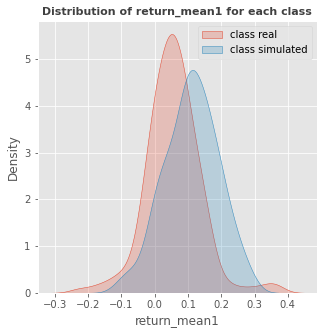

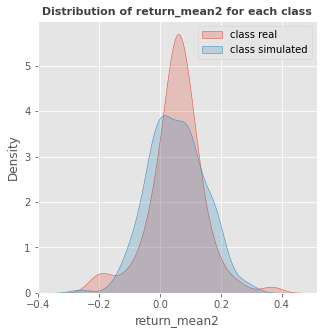

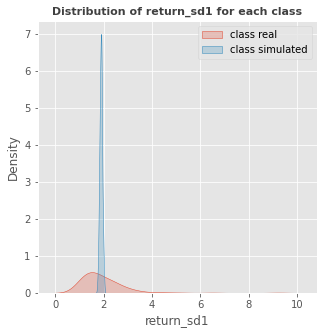

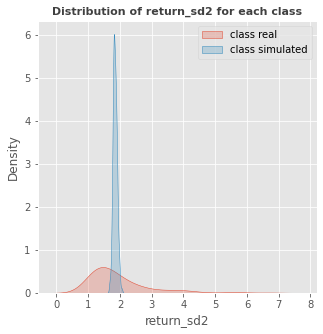

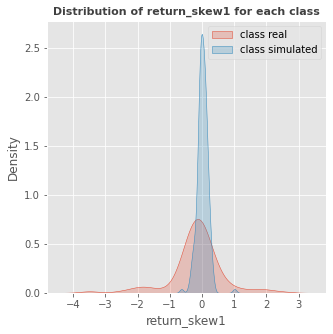

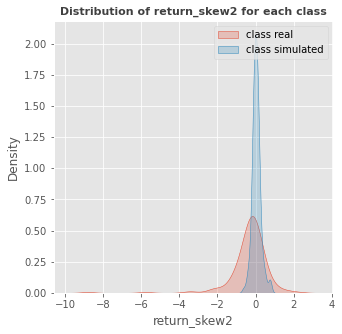

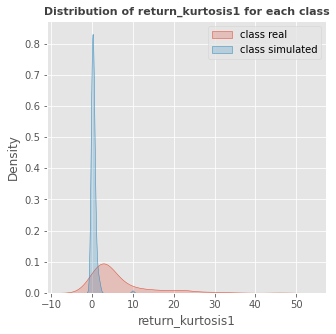

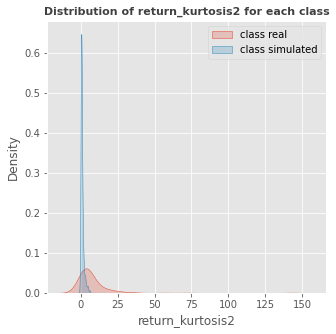

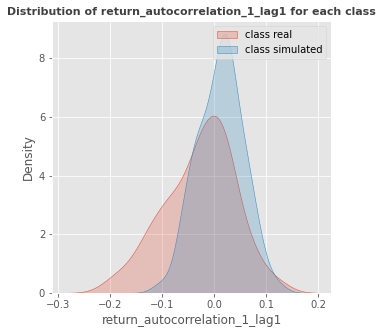

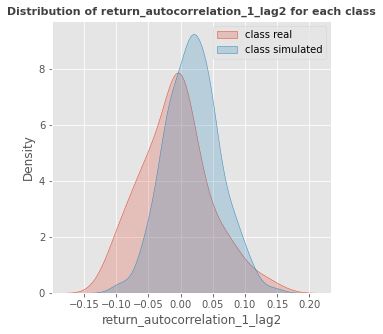

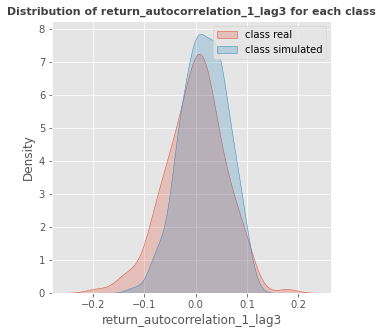

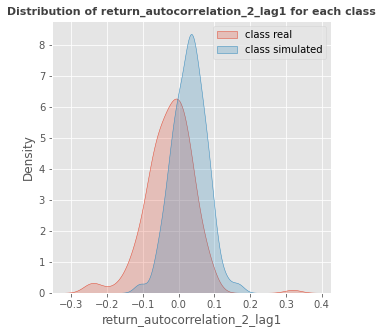

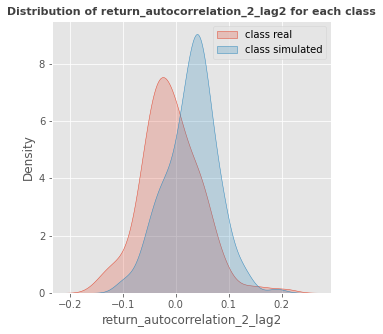

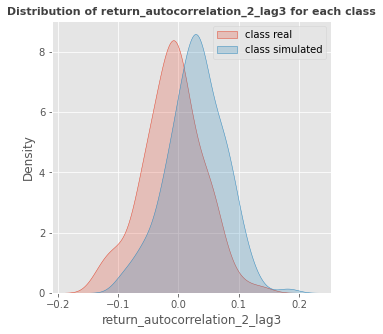

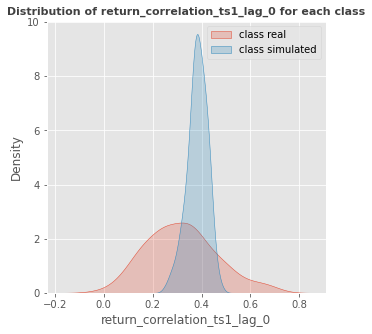

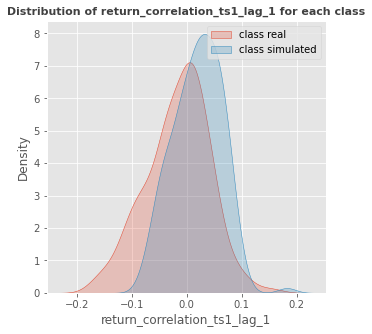

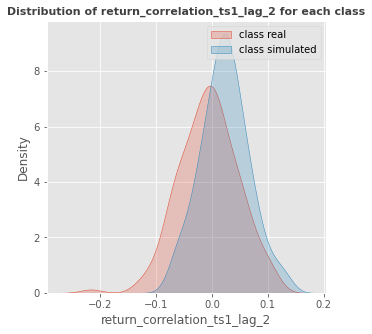

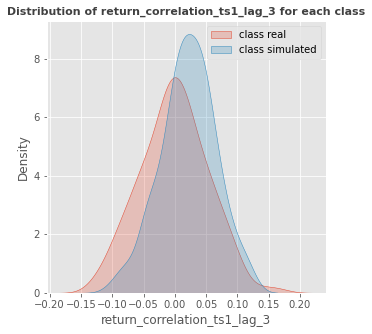

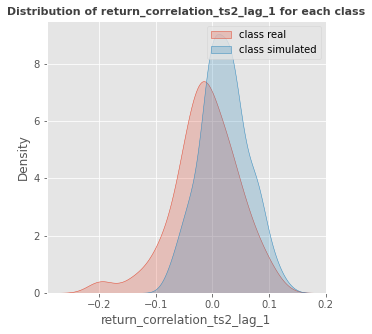

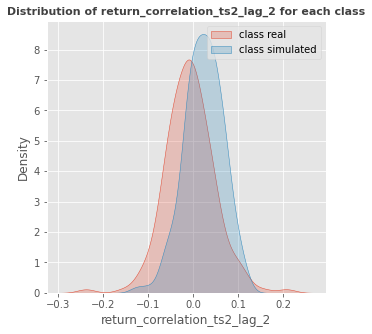

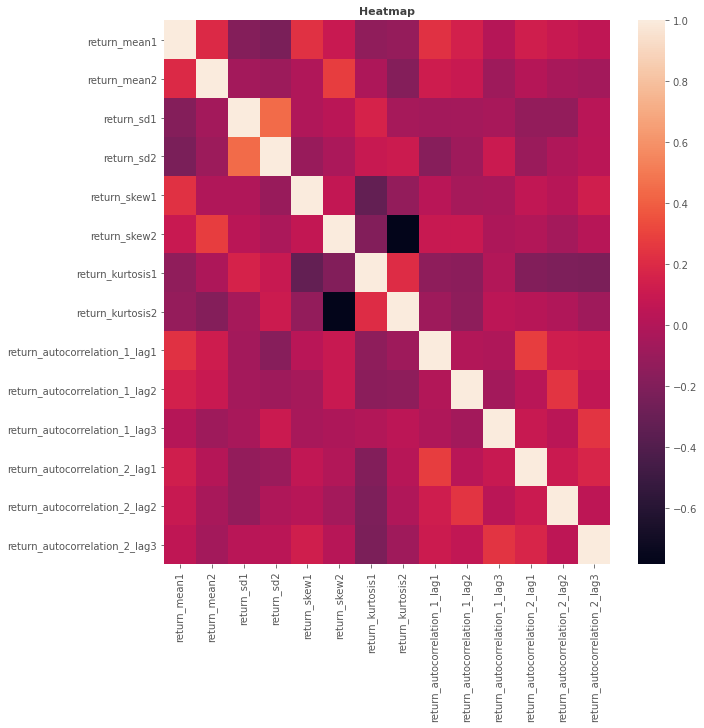

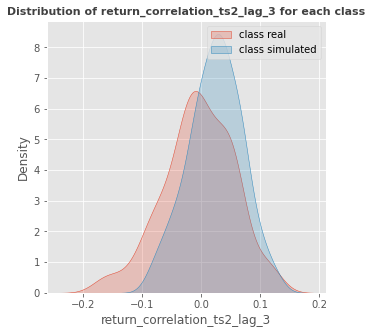

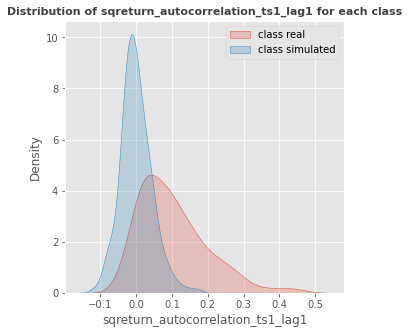

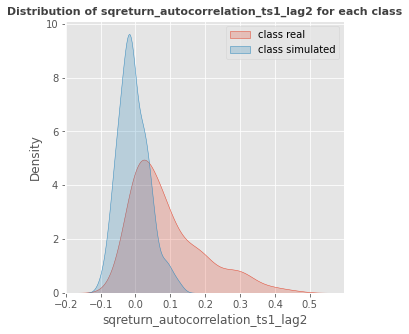

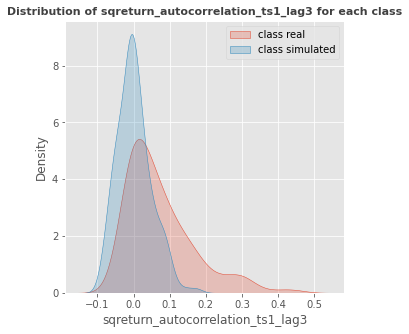

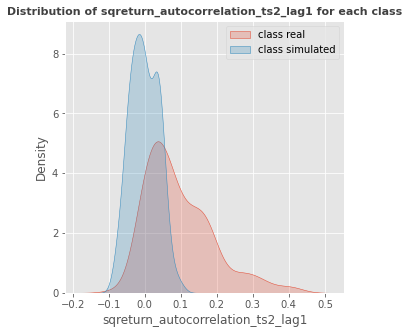

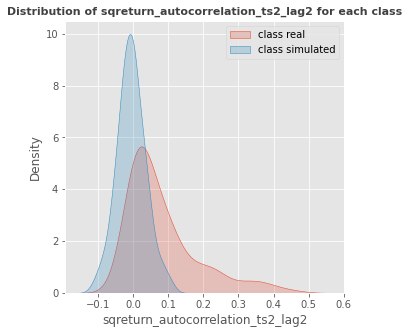

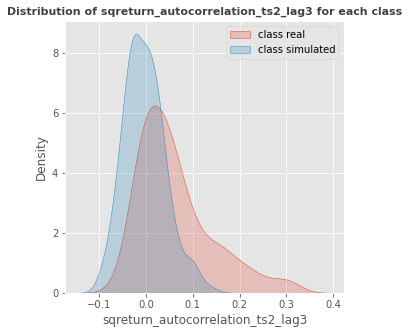

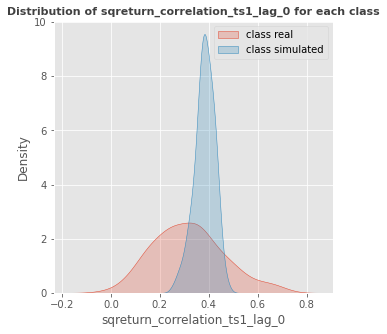

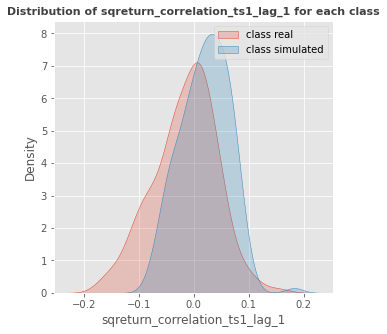

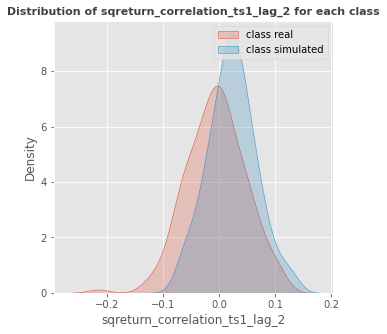

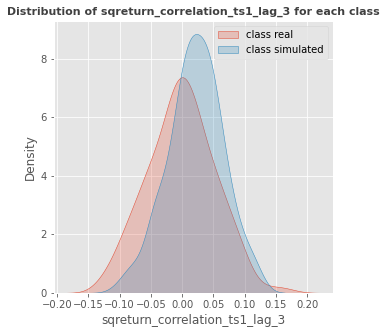

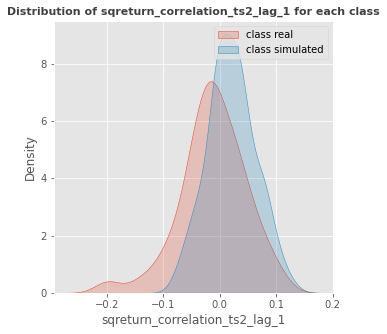

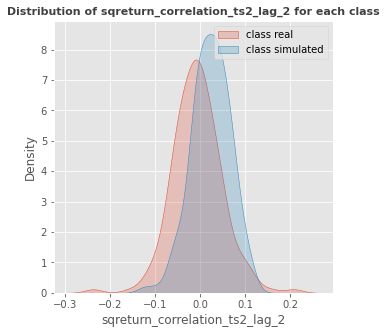

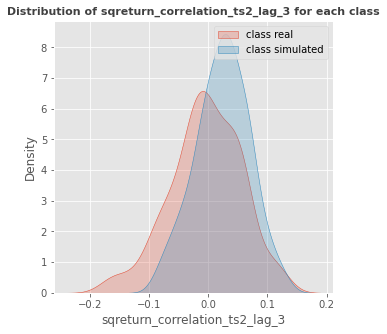

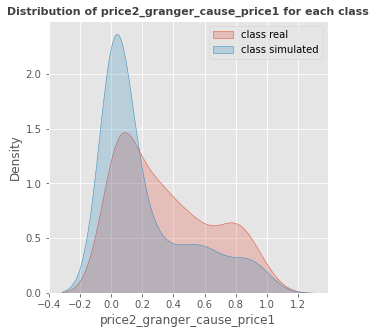

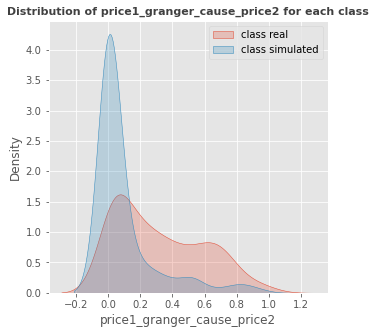

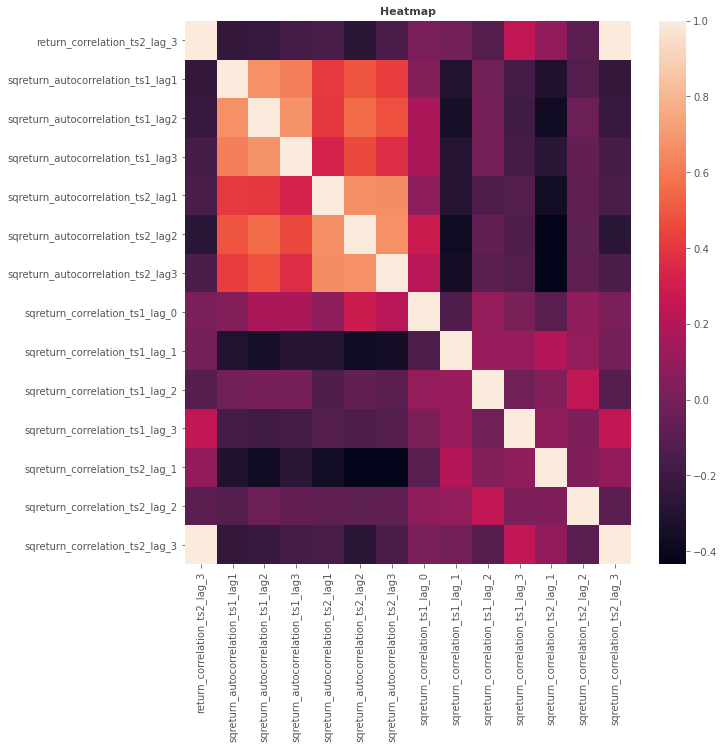

In [14]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")

In [6]:
random_seed = 9868
real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")

n_sim_jumpou_log_prices = n_jumpou_simulation(
    random_seed=random_seed, num_sim=248,
        mu11=params[4], mu12=params[5], 
        mu21=params[6], mu22=params[7], 
        sigma11=params[8], sigma12=params[9], 
        sigma21=params[10], sigma22=params[11],
        j11=params[12], j12=params[13], 
        j21=params[14], j22=params[15],
        
        alpha=2*params[0]*params[1]+0.5, 
        beta1=params[0], beta2=params[1], 
        delta0=params[2], 
        mu1=0, mu2=0, 
        lambda11=params[3], lambda12=0, 
        lambda21=0, lambda22=1/params[3],
    xinit_vec=xinit_vec, T0=T0, T=T, length=length)

n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")


simulated_statistics = create_statistics(
    label="simulated", 
    rolling_window=20, 
    return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
    price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


dataset = pd.concat([real_statistics, simulated_statistics])
X = dataset.iloc[:, 0:36]
y = dataset.iloc[:, 36]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
automl = AutoML(eval_metric='accuracy')
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)
accuracy_result = accuracy_score(y_test, predictions)

print(f"Accuracy of predictions:  {accuracy_result:.3f}")


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.2815  , p=0.2326  , df=3
likelihood ratio test: chi2=4.2632  , p=0.2344  , df=3
parameter F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.9850  , p=0.1729  , df=3
likelihood ratio test: chi2=4.9601  , p=0.1747  , df=3
parameter F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.4746  , p=0.4784  , df=2
likelihood ratio test: chi2=1.4724  , p=0.4789  , df=2
parameter F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6513  , p=0.5218  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8855  , p=0.3471  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8909  , p=0.3452  , df=1
likelihood ratio test: chi2=0.8901  , p=0.3455  , df=1
parameter F test:         F=0.8855  , p=0.3471  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7701  , p=0.3806  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7748  , p=0.3787  , df=1
likelihood ratio test: chi2=0.7742  , p=0.3789  , df=1
parameter F test:         F=0.7701  , p=0.3806  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3677  , p=0.8317  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=1.4978  , p=0.8270  , df=4
likelihood ratio test: chi2=1.4956  , p=0.8274  , df=4
parameter F test:         F=0.3677  , p=0.8317  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8695  , p=0.1146  

ssr based F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9885  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9885  , df=1
parameter F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2422  , p=0.6228  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2437  , p=0.6216  , df=1
likelihood ratio test: chi2=0.2436  , p=0.6216  , df=1
parameter F test:         F=0.2422  , p=0.6228  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2376  , p=0.7886  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.4799  , p=0.7867  , df=2
likelihood ratio test: chi2=0.4797  , p=0.7867  , df=2
parameter F test:         F=0.2376  , p=0.7886  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9098  , p=0.1492  , df_denom=493, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3228  , p=0.7243  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.6521  , p=0.7218  , df=2
likelihood ratio test: chi2=0.6517  , p=0.7219  , df=2
parameter F test:         F=0.3228  , p=0.7243  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7111  , p=0.0251  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=7.4974  , p=0.0235  , df=2
likelihood ratio test: chi2=7.4415  , p=0.0242  , df=2
parameter F test:         F=3.7111  , p=0.0251  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1959  , p=0.0744  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.2152  , p=0.0730  , df=1
likelihood ratio test: chi2=3.2049  , p=0.0734  , df=1
parameter F test:         F=3.1959  , p=0.0744  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6800  , p=0.1955  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=11.6676 , p=0.0086  , df=3
likelihood ratio test: chi2=11.5328 , p=0.0092  , df=3
parameter F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1800  , p=0.3168  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=3.5905  , p=0.3092  , df=3
likelihood ratio test: chi2=3.5776  , p=0.3108  , df=3
parameter F test:         F=1.1800  , p=0.3168  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0796  , p=0.7780  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0801  , p=0.7772  , df=1
likelihood ratio test: chi2=0.0801  , p=0.7772  , df=1
parameter F test:         F=0.0796  , p=0.7780  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4900  , p=0.4843  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.6094  , p=0.4472  , df=2
likelihood ratio test: chi2=1.6068  , p=0.4478  , df=2
parameter F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0710  , p=0.0176  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.2247  , p=0.0164  , df=2
likelihood ratio test: chi2=8.1575  , p=0.0169  , df=2
parameter F test:         F=4.0710  , p=0.0176  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4084  , p=0.5231  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4108  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4107  , p=0.5216  , df=1
parameter F test:         F=0.4084  , p=0.5231  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0695  , p=0.3016  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6434  , p=0.0269  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=7.3607  , p=0.0252  , df=2
likelihood ratio test: chi2=7.3068  , p=0.0259  , df=2
parameter F test:         F=3.6434  , p=0.0269  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2685  , p=0.0389  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.6032  , p=0.0368  , df=2
likelihood ratio test: chi2=6.5598  , p=0.0376  , df=2
parameter F test:         F=3.2685  , p=0.0389  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4345  , p=0.7837  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=1.7703  , p=0.7779  , df=4
likelihood ratio test: chi2=1.7671  , p=0.7785  , df=4
parameter F test:         F=0.4345  , p=0.7837  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5613  , p=0.1834  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5360  , p=0.8073  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=3.8699  , p=0.7946  , df=7
likelihood ratio test: chi2=3.8547  , p=0.7963  , df=7
parameter F test:         F=0.5360  , p=0.8073  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2240  , p=0.0312  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=16.0565 , p=0.0246  , df=7
likelihood ratio test: chi2=15.8005 , p=0.0270  , df=7
parameter F test:         F=2.2240  , p=0.0312  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7863  , p=0.3752  , df=1
likelihood ratio test: chi2=0.7856  , p=0.3754  , df=1
parameter F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1180  , p=0.1462  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5883  , p=0.1083  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.6039  , p=0.1066  , df=1
likelihood ratio test: chi2=2.5971  , p=0.1071  , df=1
parameter F test:         F=2.5883  , p=0.1083  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0792  , p=0.0440  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=4.1039  , p=0.0428  , df=1
likelihood ratio test: chi2=4.0871  , p=0.0432  , df=1
parameter F test:         F=4.0792  , p=0.0440  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7070  , p=0.0943  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=14.1450 , p=0.0781  , df=8
likelihood ratio test: chi2=13.9455 , p=0.0832  , df=8
parameter F test:         F=1.7070  , p=0.0943  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6345  , p=0.1125  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5039  , p=0.4781  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5070  , p=0.4765  , df=1
likelihood ratio test: chi2=0.5067  , p=0.4766  , df=1
parameter F test:         F=0.5039  , p=0.4781  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3313  , p=0.2491  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.3393  , p=0.2472  , df=1
likelihood ratio test: chi2=1.3375  , p=0.2475  , df=1
parameter F test:         F=1.3313  , p=0.2491  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8242  , p=0.1774  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.8352  , p=0.1755  , df=1
likelihood ratio test: chi2=1.8318  , p=0.1759  , df=1
parameter F test:         F=1.8242  , p=0.1774  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3090  , p=0.5785  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2741  , p=0.1322  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.2879  , p=0.1304  , df=1
likelihood ratio test: chi2=2.2826  , p=0.1308  , df=1
parameter F test:         F=2.2741  , p=0.1322  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0432  , p=0.3076  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0495  , p=0.3056  , df=1
likelihood ratio test: chi2=1.0484  , p=0.3059  , df=1
parameter F test:         F=1.0432  , p=0.3076  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6655  , p=0.1975  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.6756  , p=0.1955  , df=1
likelihood ratio test: chi2=1.6728  , p=0.1959  , df=1
parameter F test:         F=1.6655  , p=0.1975  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1818  , p=0.2775  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4674  , p=0.2263  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4763  , p=0.2244  , df=1
likelihood ratio test: chi2=1.4741  , p=0.2247  , df=1
parameter F test:         F=1.4674  , p=0.2263  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2420  , p=0.6230  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2435  , p=0.6217  , df=1
likelihood ratio test: chi2=0.2434  , p=0.6218  , df=1
parameter F test:         F=0.2420  , p=0.6230  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5113  , p=0.4749  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5144  , p=0.4732  , df=1
likelihood ratio test: chi2=0.5141  , p=0.4733  , df=1
parameter F test:         F=0.5113  , p=0.4749  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1745  , p=0.6763  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9148  , p=0.3393  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9203  , p=0.3374  , df=1
likelihood ratio test: chi2=0.9195  , p=0.3376  , df=1
parameter F test:         F=0.9148  , p=0.3393  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3692  , p=0.0209  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.4016  , p=0.0201  , df=1
likelihood ratio test: chi2=5.3726  , p=0.0205  , df=1
parameter F test:         F=5.3692  , p=0.0209  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3113  , p=0.5771  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3132  , p=0.5757  , df=1
likelihood ratio test: chi2=0.3131  , p=0.5758  , df=1
parameter F test:         F=0.3113  , p=0.5771  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4801  , p=0.2243  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5424  , p=0.1115  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.5578  , p=0.1098  , df=1
likelihood ratio test: chi2=2.5512  , p=0.1102  , df=1
parameter F test:         F=2.5424  , p=0.1115  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1897  , p=0.6634  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1908  , p=0.6622  , df=1
likelihood ratio test: chi2=0.1908  , p=0.6622  , df=1
parameter F test:         F=0.1897  , p=0.6634  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7344  , p=0.1885  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.7449  , p=0.1865  , df=1
likelihood ratio test: chi2=1.7418  , p=0.1869  , df=1
parameter F test:         F=1.7344  , p=0.1885  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5370  , p=0.4640  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2960  , p=0.2751  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=3.9437  , p=0.2676  , df=3
likelihood ratio test: chi2=3.9281  , p=0.2693  , df=3
parameter F test:         F=1.2960  , p=0.2751  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8269  , p=0.4795  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=2.5160  , p=0.4724  , df=3
likelihood ratio test: chi2=2.5096  , p=0.4736  , df=3
parameter F test:         F=0.8269  , p=0.4795  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9946  , p=0.4343  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=7.1806  , p=0.4103  , df=7
likelihood ratio test: chi2=7.1288  , p=0.4156  , df=7
parameter F test:         F=0.9946  , p=0.4343  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0907  , p=0.3679  

ssr based F test:         F=1.6220  , p=0.1834  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.9355  , p=0.1766  , df=3
likelihood ratio test: chi2=4.9111  , p=0.1784  , df=3
parameter F test:         F=1.6220  , p=0.1834  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8312  , p=0.0379  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=8.6149  , p=0.0349  , df=3
likelihood ratio test: chi2=8.5411  , p=0.0361  , df=3
parameter F test:         F=2.8312  , p=0.0379  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0912  , p=0.2967  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0978  , p=0.2947  , df=1
likelihood ratio test: chi2=1.0966  , p=0.2950  , df=1
parameter F test:         F=1.0912  , p=0.2967  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6270  , p=0.1057  , df_denom=496, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0933  , p=0.0056  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=19.0606 , p=0.0041  , df=6
likelihood ratio test: chi2=18.7028 , p=0.0047  , df=6
parameter F test:         F=3.0933  , p=0.0056  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8244  , p=0.0925  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=11.2416 , p=0.0812  , df=6
likelihood ratio test: chi2=11.1158 , p=0.0849  , df=6
parameter F test:         F=1.8244  , p=0.0925  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4518  , p=0.2288  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4606  , p=0.2268  , df=1
likelihood ratio test: chi2=1.4584  , p=0.2272  , df=1
parameter F test:         F=1.4518  , p=0.2288  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0471  , p=0.1531  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2617  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=28.1813 , p=0.0000  , df=3
likelihood ratio test: chi2=27.4128 , p=0.0000  , df=3
parameter F test:         F=9.2617  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7275  , p=0.5359  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.2136  , p=0.5293  , df=3
likelihood ratio test: chi2=2.2087  , p=0.5302  , df=3
parameter F test:         F=0.7275  , p=0.5359  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8855  , p=0.4724  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.6071  , p=0.4618  , df=4
likelihood ratio test: chi2=3.5941  , p=0.4637  , df=4
parameter F test:         F=0.8855  , p=0.4724  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3493  , p=0.0101  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5653  , p=0.0013  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=18.5980 , p=0.0009  , df=4
likelihood ratio test: chi2=18.2585 , p=0.0011  , df=4
parameter F test:         F=4.5653  , p=0.0013  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4270  , p=0.2238  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.8131  , p=0.2135  , df=4
likelihood ratio test: chi2=5.7794  , p=0.2162  , df=4
parameter F test:         F=1.4270  , p=0.2238  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7757  , p=0.0963  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7924  , p=0.0947  , df=1
likelihood ratio test: chi2=2.7847  , p=0.0952  , df=1
parameter F test:         F=2.7757  , p=0.0963  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5721  , p=0.2105  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.9143  , p=0.0000  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=40.7189 , p=0.0000  , df=8
likelihood ratio test: chi2=39.1245 , p=0.0000  , df=8
parameter F test:         F=4.9143  , p=0.0000  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0018  , p=0.4337  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=8.3010  , p=0.4046  , df=8
likelihood ratio test: chi2=8.2319  , p=0.4112  , df=8
parameter F test:         F=1.0018  , p=0.4337  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2364  , p=0.0188  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=20.9364 , p=0.0129  , df=9
likelihood ratio test: chi2=20.5031 , p=0.0150  , df=9
parameter F test:         F=2.2364  , p=0.0188  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0496  , p=0.0015  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.0789  , p=0.0002  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=29.4467 , p=0.0001  , df=7
likelihood ratio test: chi2=28.6025 , p=0.0002  , df=7
parameter F test:         F=4.0789  , p=0.0002  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7835  , p=0.6014  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=5.6559  , p=0.5805  , df=7
likelihood ratio test: chi2=5.6238  , p=0.5843  , df=7
parameter F test:         F=0.7835  , p=0.6014  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9070  , p=0.1679  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9185  , p=0.1660  , df=1
likelihood ratio test: chi2=1.9148  , p=0.1664  , df=1
parameter F test:         F=1.9070  , p=0.1679  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5790  , p=0.0061  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.7820  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=34.6791 , p=0.0000  , df=5
likelihood ratio test: chi2=33.5205 , p=0.0000  , df=5
parameter F test:         F=6.7820  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2607  , p=0.0474  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=11.5599 , p=0.0413  , df=5
likelihood ratio test: chi2=11.4272 , p=0.0435  , df=5
parameter F test:         F=2.2607  , p=0.0474  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9395  , p=0.0864  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=9.9174  , p=0.0776  , df=5
likelihood ratio test: chi2=9.8196  , p=0.0805  , df=5
parameter F test:         F=1.9395  , p=0.0864  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1169  , p=0.0622  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.9612  , p=0.0001  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=32.8215 , p=0.0001  , df=8
likelihood ratio test: chi2=31.7752 , p=0.0001  , df=8
parameter F test:         F=3.9612  , p=0.0001  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1971  , p=0.2987  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=9.9185  , p=0.2708  , df=8
likelihood ratio test: chi2=9.8200  , p=0.2779  , df=8
parameter F test:         F=1.1971  , p=0.2987  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=6.6712  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=62.4523 , p=0.0000  , df=9
likelihood ratio test: chi2=58.7951 , p=0.0000  , df=9
parameter F test:         F=6.6712  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9805  , p=0.4552  

ssr based F test:         F=2.5024  , p=0.0298  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=12.7960 , p=0.0254  , df=5
likelihood ratio test: chi2=12.6337 , p=0.0271  , df=5
parameter F test:         F=2.5024  , p=0.0298  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6185  , p=0.0238  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.3892 , p=0.0200  , df=5
likelihood ratio test: chi2=13.2117 , p=0.0215  , df=5
parameter F test:         F=2.6185  , p=0.0238  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1843  , p=0.0220  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=20.4483 , p=0.0153  , df=9
likelihood ratio test: chi2=20.0348 , p=0.0177  , df=9
parameter F test:         F=2.1843  , p=0.0220  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7238  , p=0.6872  , df_denom=473, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9592  , p=0.0006  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=20.2026 , p=0.0005  , df=4
likelihood ratio test: chi2=19.8028 , p=0.0005  , df=4
parameter F test:         F=4.9592  , p=0.0006  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2543  , p=0.2871  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.1099  , p=0.2762  , df=4
likelihood ratio test: chi2=5.0838  , p=0.2788  , df=4
parameter F test:         F=1.2543  , p=0.2871  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1845  , p=0.0177  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=22.8209 , p=0.0114  , df=10
likelihood ratio test: chi2=22.3064 , p=0.0136  , df=10
parameter F test:         F=2.1845  , p=0.0177  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6401  , p=0.

parameter F test:         F=3.7602  , p=0.0003  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4730  , p=0.1644  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.2049 , p=0.1423  , df=8
likelihood ratio test: chi2=12.0562 , p=0.1487  , df=8
parameter F test:         F=1.4730  , p=0.1644  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3429  , p=0.0105  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.4756 , p=0.0064  , df=10
likelihood ratio test: chi2=23.8851 , p=0.0079  , df=10
parameter F test:         F=2.3429  , p=0.0105  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8071  , p=0.6219  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.4321  , p=0.5867  , df=10
likelihood ratio test: chi2=8.3605  , p=0.5937  , df=10
parameter F test:         F=0.8071  , p=0.6219  , df_denom=470, df_num=10

Granger Ca


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3037  , p=0.0120  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.0664 , p=0.0074  , df=10
likelihood ratio test: chi2=23.4951 , p=0.0091  , df=10
parameter F test:         F=2.3037  , p=0.0120  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6160  , p=0.0990  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=16.8824 , p=0.0770  , df=10
likelihood ratio test: chi2=16.5986 , p=0.0837  , df=10
parameter F test:         F=1.6160  , p=0.0990  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7639  , p=0.0647  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=18.4266 , p=0.0482  , df=10
likelihood ratio test: chi2=18.0893 , p=0.0535  , df=10
parameter F test:         F=1.7639  , p=0.0647  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.05


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5994  , p=0.0105  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6392  , p=0.0100  , df=1
likelihood ratio test: chi2=6.5955  , p=0.0102  , df=1
parameter F test:         F=6.5994  , p=0.0105  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1889  , p=0.0412  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2142  , p=0.0401  , df=1
likelihood ratio test: chi2=4.1965  , p=0.0405  , df=1
parameter F test:         F=4.1889  , p=0.0412  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7381  , p=0.0097  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7788  , p=0.0092  , df=1
likelihood ratio test: chi2=6.7332  , p=0.0095  , df=1
parameter F test:         F=6.7381  , p=0.0097  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6052 , p=0.0007  

ssr based F test:         F=3.9499  , p=0.0016  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=20.1974 , p=0.0011  , df=5
likelihood ratio test: chi2=19.7970 , p=0.0014  , df=5
parameter F test:         F=3.9499  , p=0.0016  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6573  , p=0.0037  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=27.7605 , p=0.0020  , df=10
likelihood ratio test: chi2=27.0041 , p=0.0026  , df=10
parameter F test:         F=2.6573  , p=0.0037  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5495  , p=0.1190  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=16.1869 , p=0.0944  , df=10
likelihood ratio test: chi2=15.9258 , p=0.1018  , df=10
parameter F test:         F=1.5495  , p=0.1190  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4613 , p=0.0005  , df_denom=497, df_num=1
ssr based c


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8609  , p=0.0019  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=19.7423 , p=0.0014  , df=5
likelihood ratio test: chi2=19.3595 , p=0.0016  , df=5
parameter F test:         F=3.8609  , p=0.0019  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9299  , p=0.0879  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=9.8685  , p=0.0790  , df=5
likelihood ratio test: chi2=9.7716  , p=0.0820  , df=5
parameter F test:         F=1.9299  , p=0.0879  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8406  , p=0.5896  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.7813  , p=0.5530  , df=10
likelihood ratio test: chi2=8.7037  , p=0.5604  , df=10
parameter F test:         F=0.8406  , p=0.5896  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4903  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.7798 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=46.0207 , p=0.0000  , df=2
likelihood ratio test: chi2=44.0206 , p=0.0000  , df=2
parameter F test:         F=22.7798 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5484  , p=0.2136  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.1280  , p=0.2093  , df=2
likelihood ratio test: chi2=3.1183  , p=0.2103  , df=2
parameter F test:         F=1.5484  , p=0.2136  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0597  , p=0.0809  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0782  , p=0.0793  , df=1
likelihood ratio test: chi2=3.0688  , p=0.0798  , df=1
parameter F test:         F=3.0597  , p=0.0809  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9025  , p=0.0030  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2751  , p=0.0275  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=16.4247 , p=0.0215  , df=7
likelihood ratio test: chi2=16.1576 , p=0.0237  , df=7
parameter F test:         F=2.2751  , p=0.0275  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1828  , p=0.3110  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=8.5386  , p=0.2875  , df=7
likelihood ratio test: chi2=8.4656  , p=0.2933  , df=7
parameter F test:         F=1.1828  , p=0.3110  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5299  , p=0.0038  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=13.7834 , p=0.0032  , df=3
likelihood ratio test: chi2=13.5961 , p=0.0035  , df=3
parameter F test:         F=4.5299  , p=0.0038  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1699  , p=0.0062  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.28 seconds
2_DecisionTree accuracy 0.931034 trained in 12.09 seconds
3_Linear accuracy 0.988506 trained in 3.55 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.6 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.96 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.93 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.41 seconds
AutoML fit time: 39.45 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.973


An input array is constant; the correlation coefficent is not defined.


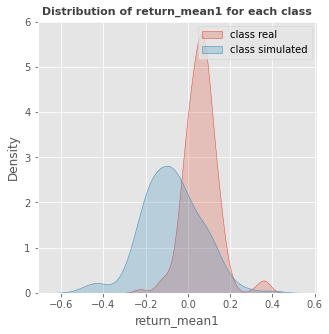

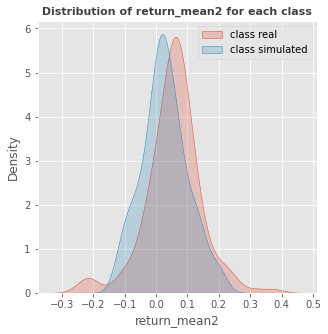

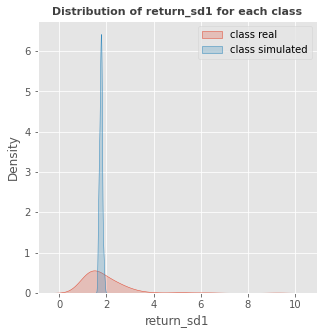

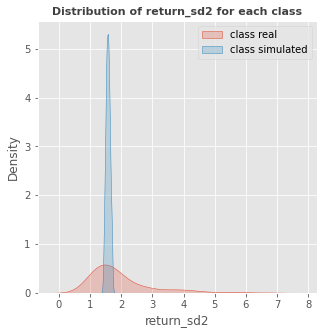

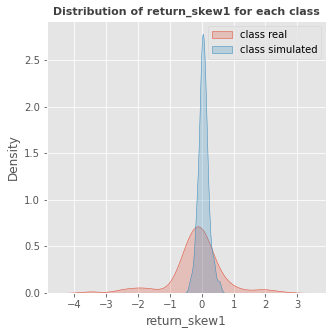

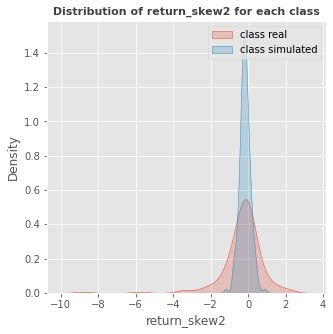

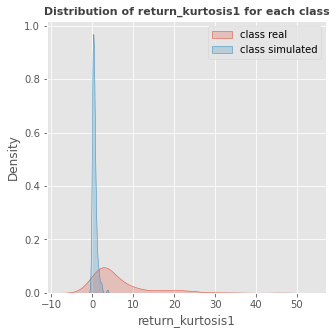

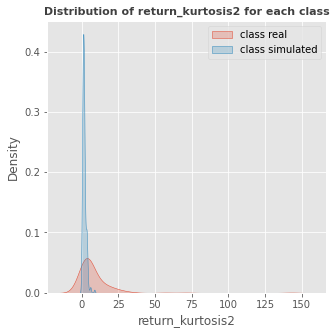

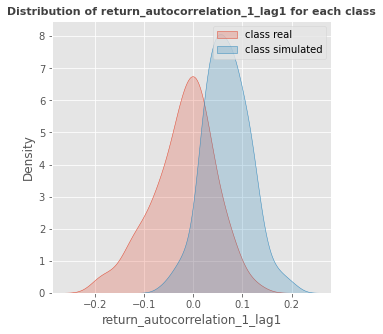

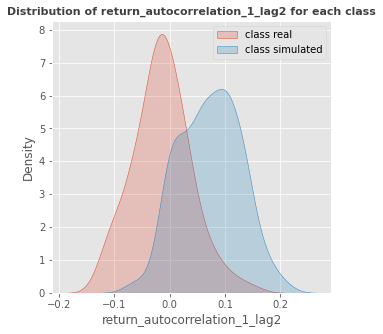

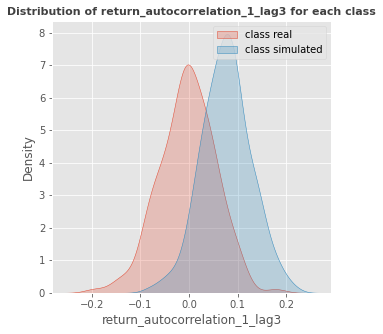

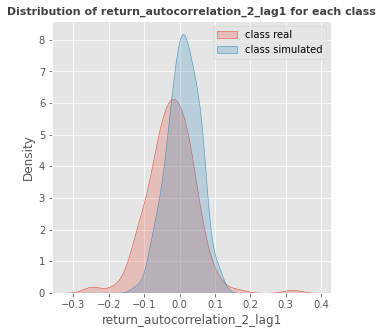

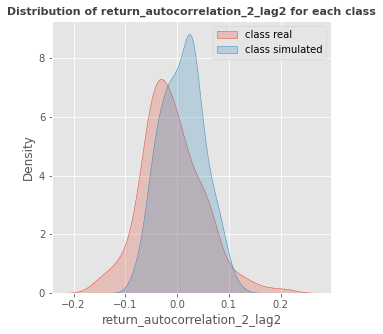

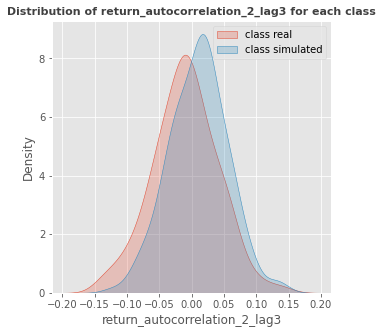

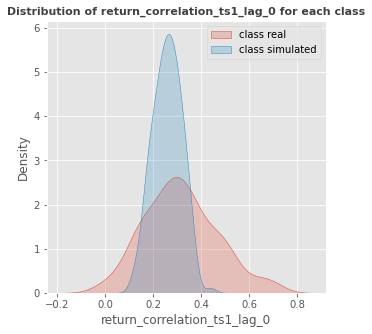

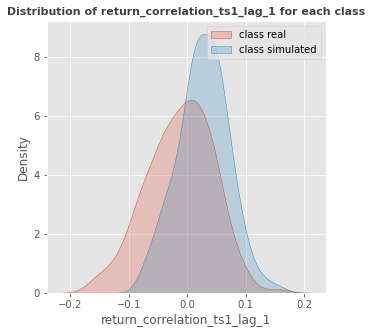

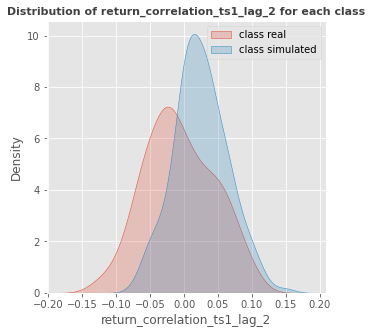

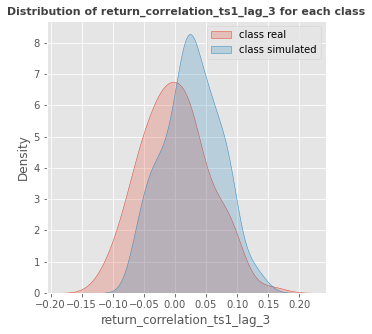

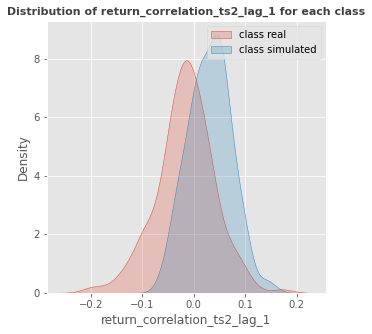

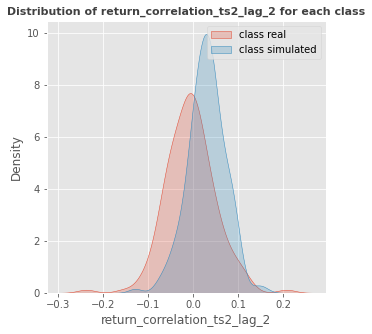

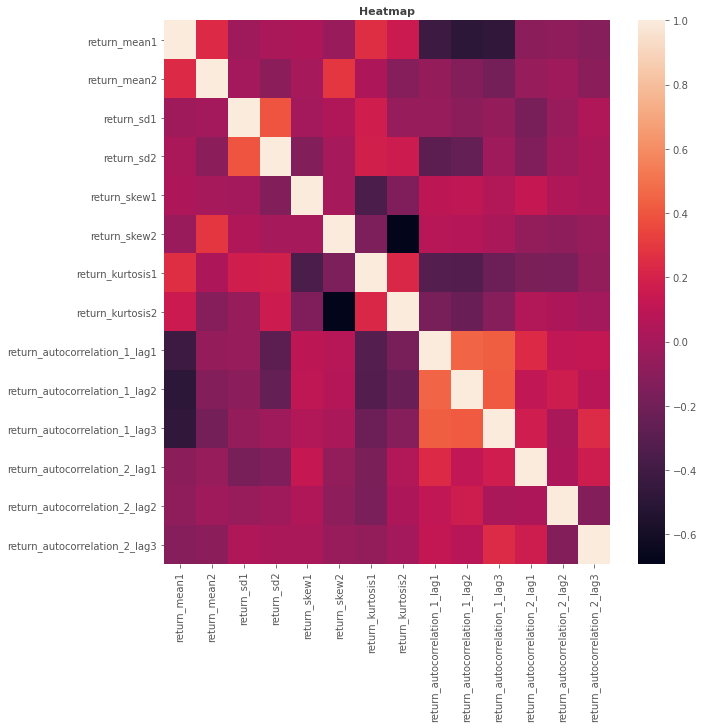

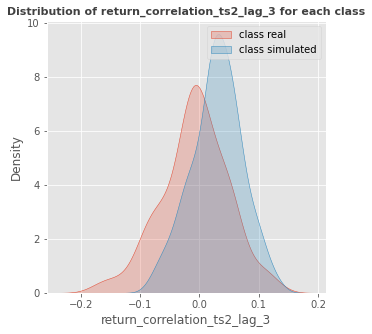

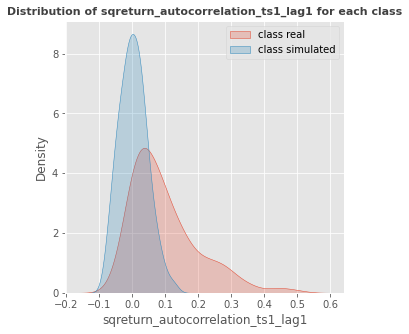

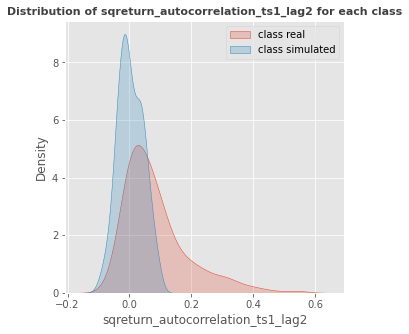

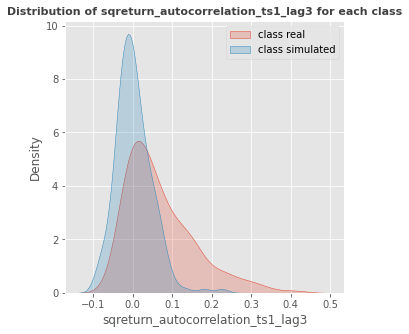

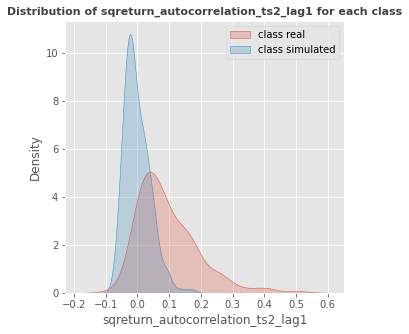

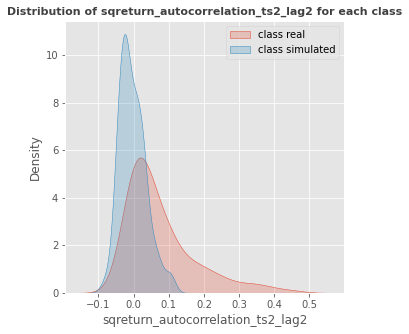

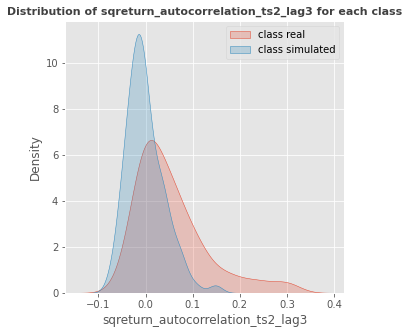

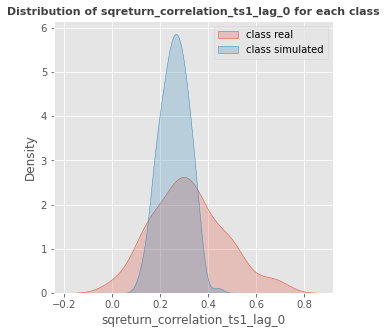

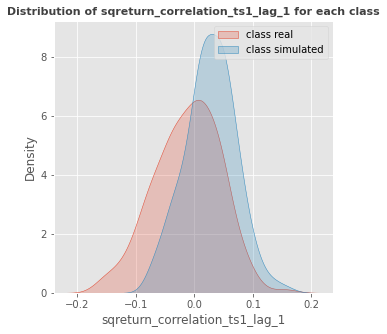

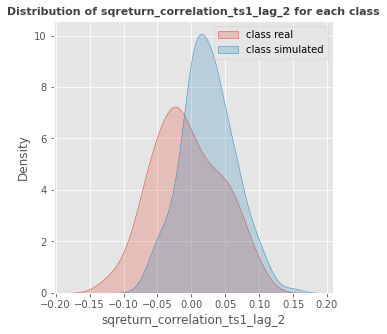

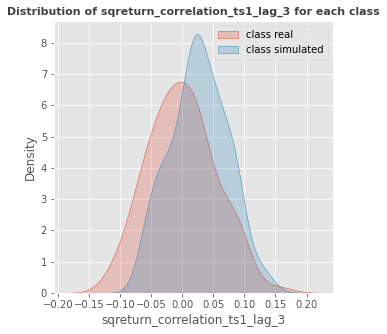

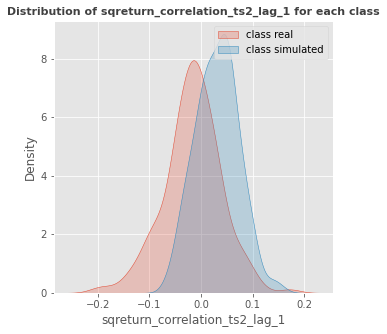

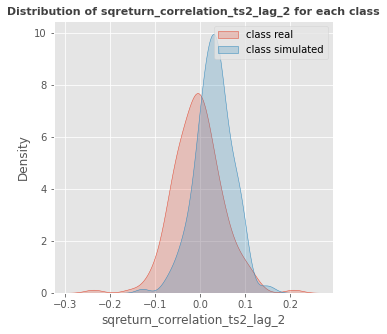

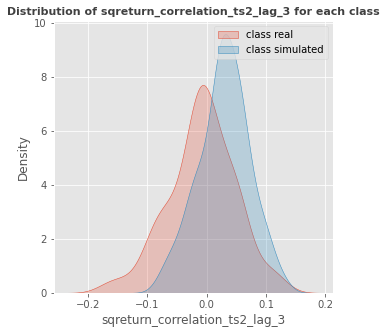

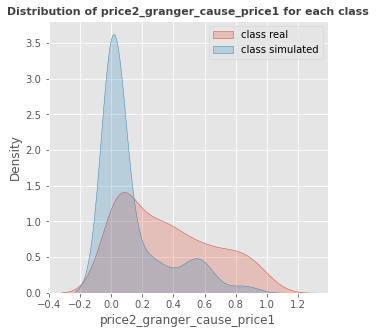

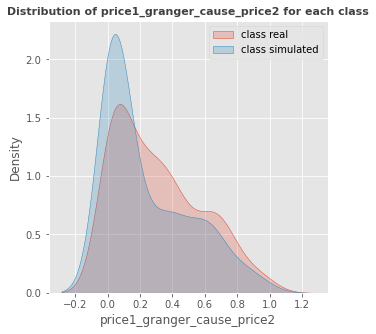

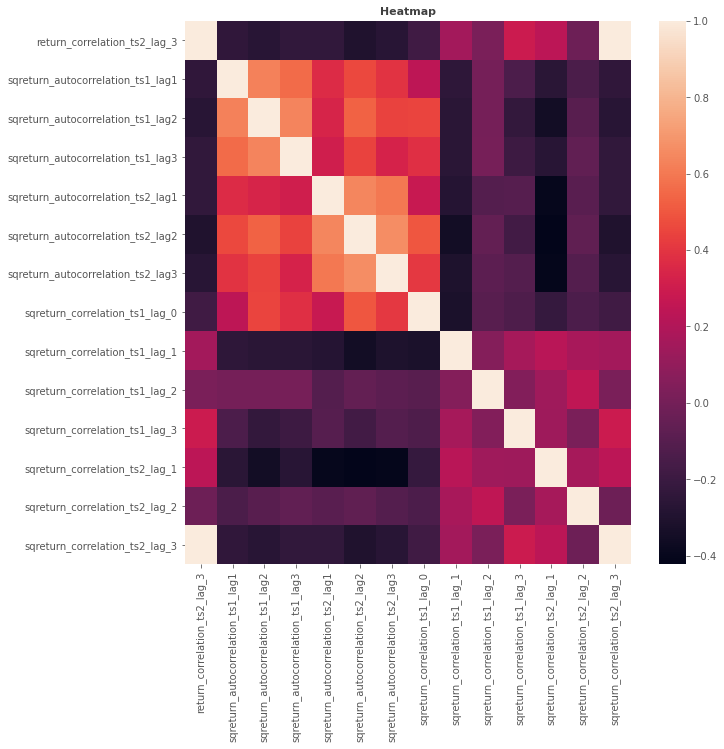

In [7]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump_2")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump_2")